In [315]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import seaborn as sns
# import cobra
import scipy.stats as st
import scipy
sys.path.append('../../code/')
sys.path.append('/Users/ssulheim/git/mwf_gems/code/python')
import leakage_reframed
import ng_utils
import reframed
from sklearn.metrics import auc

## Note run in condas env pandas2

In [36]:

folder = Path('/Users/ssulheim/Library/CloudStorage/OneDrive-UniversitédeLausanne/UNIL/leakage/experimental work/sintef_sept_23/exometabolome')

In [37]:
fn = folder / 'SM_Quantitative_Results.xlsx'
mapping_fn = folder / 'met_to_bigg.csv'
od_fn = folder / '..' / 'REL-F-U37-23_OD_TV.xlsx'

## Read mapping

In [38]:
mapping_dict = pd.read_csv(mapping_fn, index_col = 0).to_dict()['BiGG ID']

In [39]:
mapping_dict

{'SEBACOYL-L-CARNITINE (C10-DC)': nan,
 'DEOXYCARNITINE (DEOXY-C0)': 'gbbtn',
 'GLUTARYLCARNITINE (C5-DC)': nan,
 'ALPHA-AMINOBUTYRATE': nan,
 'CREATINE': 'crn',
 'ALPHA-AMINOADIPATE': nan,
 'CIS-ACONITATE': 'acon_C',
 'CITRATE': 'cit',
 'HEXOSES including Glucose and Fructose': 'fru',
 'GLUTARATE': 'glutar',
 'ISOCITRATE': 'icit',
 'LACTATE': 'lac__L',
 'MALATE': 'mal__L',
 'NAD': 'nad',
 'SUCCINATE': 'succ',
 'TRANS-ACONITATE': 'acon_T',
 'ASPARAGINE': 'asn__L',
 'ASPARTATE': 'asp__L',
 'BETA-ALANINE': 'ala_B',
 'GAMMA-AMINOBUTYRATE': '4abut',
 'GLUTAMATE': 'glu__L',
 'GLUTAMINE': 'gln__L',
 'GLYCINE': 'gly',
 'ISOLEUCINE': 'ile__L',
 'LEUCINE': 'leu__L',
 'LYSINE': 'lys__L',
 'METHIONINE': 'met__L',
 'PHENYLALANINE': 'phe__L',
 'PIPECOLIC ACID': nan,
 'PROLINE': 'pro__L',
 'SERINE': 'ser__L',
 'TYROSINE': 'tyr__L',
 'VALINE': 'val__L',
 'ALANINE': 'ala__L',
 'PYRUVATE': 'pyr',
 'CITRULLINE': 'citr__L',
 'HISTIDINE': 'his__L',
 'MALONYLCARNITINE (C3:DC)': nan,
 'FRUCTOSE-6-PHOSPHATE'

## Read OD and convert to biomass

In [40]:
od_df = pd.read_excel(od_fn, skiprows=2, nrows=21)
od_df.drop(index = 0, inplace=True)

In [41]:
rel_to_info = {
    'REL01': {'M': 'M1', 'CS': 'Galactose'},
    'REL02': {'M': 'M2', 'CS': 'Galactose'},
    'REL03': {'M': 'M3', 'CS': 'Galactose'},
    'REL04': {'M': 'M5', 'CS': 'L-malate'},
    'REL05': {'M': 'M6', 'CS': 'L-malate'},
    'REL06': {'M': 'M7', 'CS': 'L-malate'},
    'REL07': {'M': 'M9', 'CS': 'L-alanine'},
    'REL08': {'M': 'M10', 'CS': 'L-alanine'},
    'REL09': {'M': 'M11', 'CS': 'L-alanine'}
    }
M_to_rel = {dic['M']:rel for rel, dic in rel_to_info.items()}


In [42]:
od_df.rename(columns={'Unnamed: 0': 'Timestamp', 'Unnamed: 1': 'Time', 'Unnamed: 2': 'Hours'}, inplace=True)

In [43]:
gDW_per_OD = {
    'Galactose': 0.35, # gDW/L/OD,
    'L-malate':  0.28,
    'L-alanine': 0.3
}

In [44]:
gdw_df = pd.DataFrame()
gdw_df['Hours'] = od_df['Hours'].astype(float).round(2)

In [45]:
for rel, dic in rel_to_info.items():
    gdw_df[rel] = od_df[rel]*gDW_per_OD[dic['CS']]

(0.0, 1.5)

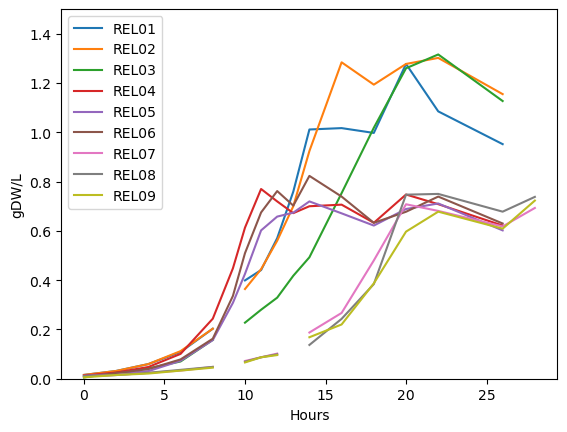

In [314]:
gdw_df.plot(x = 'Hours')
plt.ylabel('gDW/L')
plt.xlabel('Hours')
# plt.xlim(0, 20)
plt.ylim(0,1.5)

In [336]:
# Gives basically exactly same results as scipy
data = []
for rel in rel_to_info.keys():
    for h in gdw_df['Hours'].unique():
        hidx = gdw_df.Hours <= h+0.5
        x = gdw_df.loc[hidx, 'Hours']
        y = gdw_df.loc[hidx, rel]
        nanidx = y.isna()
        if len(y)>1:
            auc_val = auc(x[~nanidx], y[~nanidx])
            data.append([rel, h, auc_val])
df_auc = pd.DataFrame(data, columns=['REL', 'Hours', 'AUC gDW/L'])

# Create integrated biomass df


In [387]:
int_gdw_data = []
for rel in rel_to_info.keys():
    for h in gdw_df['Hours'][1:]:
        gdw = gdw_df[['Hours', rel]].copy()
        if (gdw['Hours']==h).sum() == 0:
            continue
        gdw.dropna(inplace=True)
        tidx = gdw.Hours < h+0.5
        int_gdw = scipy.integrate.simpson(gdw.loc[tidx, rel], gdw.loc[tidx, 'Hours'])
        int_gdw_data.append([rel, h, int_gdw])
int_gdw_df = pd.DataFrame(int_gdw_data, columns = ['REL', 'Hours', 'Integrated biomass'])
int_gdw_dict = int_gdw_df.set_index(['REL', 'Hours'])['Integrated biomass'].to_dict()

In [388]:
# sns.lineplot(data = df_auc, x = 'Hours', y = 'AUC gDW/L', hue = 'REL')


Text(0, 0.5, 'AUC gDW/L')

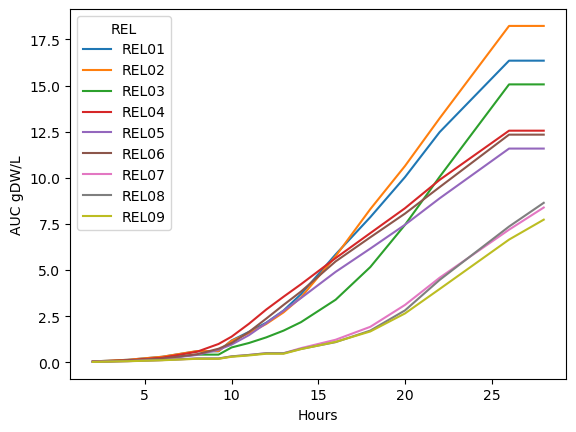

In [389]:
sns.lineplot(data = int_gdw_df, x = 'Hours', y = 'Integrated biomass', hue = 'REL')
# plt.xlim(0, 15)
# plt.ylim(0, 6)
plt.ylabel('AUC gDW/L')

## Read LC-MS

In [390]:
df = pd.read_excel(fn, nrows=46)

In [391]:
df.columns = [x.rstrip(' ') for x in df.columns]

In [392]:
df.drop(index = 0, inplace=True)

In [393]:
data_columns = ['PHENYLALANINE', 'LEUCINE',
       'ISOLEUCINE', 'METHIONINE', 'GAMMA-AMINOBUTYRATE', 'PROLINE',
       'TYROSINE', 'VALINE', 'PIPECOLIC ACID', 'ALPHA-AMINOBUTYRATE',
       'BETA-ALANINE', 'ALANINE', 'CREATINE', 'ALPHA-AMINOADIPATE',
       'GLYCINE', 'GLUTAMINE', 'GLUTAMATE', 'SERINE', 'ASPARAGINE',
       'ASPARTATE', 'LYSINE', 'PYRUVATE', 'LACTATE',
       'HEXOSES including Glucose and Fructose', 'NAD',
       'SUCCINATE', 'MALATE', 'CIS-ACONITATE', 'CITRATE', 'ISOCITRATE',
       'TRANS-ACONITATE']
control_samples = ['\xa0 M9 Alanine_001', 'M9 Alanine_002', '\xa0\xa0 M9 Alanine_003',
       ' M9 Galactose_001', ' M9 Galactose_002', ' M9 Galactose_003',
       'M9 malate_001', 'M9 malate_002', 'M9 malate_003']

In [394]:
control_idx = df['USER CODE'].isin(control_samples)

In [395]:
df.rename(columns = {'Class 1':'Carbon source', 'Class 2':'Timepoint-tag'}, inplace=True)

# Drop columns that are not interesting (doesn't map to model)

In [396]:
df.drop(columns = ['SEBACOYL-L-CARNITINE (C10-DC)', 'DEOXYCARNITINE (DEOXY-C0)',
       'GLUTARYLCARNITINE (C5-DC)', 'GLUTARATE'], inplace=True)

## Outliers in medium measurements

We have double checked Malate and indeed, the higher values of Malate observed in the highlighted samples is due to a carry-over from the fresh media Malate. All samples were blinded randomized for the analysis and SM_MPTA_112023_39_Galactose-T8_M3_3; SM_MPTA_112023_ FreshMedia_M9 Alanine_003_39 and also SM_MPTA_112023_88_L-alanine-T18_M9_31 were injected just after the A M9_malate sample. What explains the 10-fold difference observed.
 
We have a LC-MS and autosampler wash step before and after each injection in order to minimize / reduce the carry-over but in this case the concentration of Malate in the Malate-fresh media was to high in comparison to the other values.


In [397]:
df.loc[39, ['SUCCINATE', 'MALATE']] = np.nan
# df['MALATE'] = 'ND'
# Also errors with malate
# Galactose-T12_M1_4, Galactose-T8_M3, Galactose-T14_M2, Galactose-T14_M3, Galactose-T6_M2, Galactose-T12_M2, L-alanine-T18_M11, L-alanine-T18_M9

# FOr hexose
# L-alanine-T18_M11

In [398]:
df.tail()

Sample_ID          USER CODE  \
41  SM_MPTA_112023_ FreshMedia_M9 Galactose_002_41   M9 Galactose_002   
42  SM_MPTA_112023_ FreshMedia_M9 Galactose_003_42   M9 Galactose_003   
43     SM_MPTA_112023_ FreshMedia_M9 malate_001_43      M9 malate_001   
44     SM_MPTA_112023_ FreshMedia_M9 malate_002_44      M9 malate_002   
45     SM_MPTA_112023_ FreshMedia_M9 malate_003_45      M9 malate_003   

   Carbon source Timepoint-tag PHENYLALANINE LEUCINE ISOLEUCINE METHIONINE  \
41     Galactose            T0      0.007935      ND         ND         ND   
42     Galactose            T0      0.001259      ND         ND         ND   
43      L-malate            T0      0.051862      ND         ND         ND   
44      L-malate            T0      0.049358      ND   0.063293         ND   
45      L-malate            T0      0.040061      ND   0.039175         ND   

   GAMMA-AMINOBUTYRATE   PROLINE  ... PYRUVATE    LACTATE  \
41            0.028205  0.027638  ...       ND    4.28256   
42                  ND  0.015408  ...       ND    1.50591   
43                  ND  0.071103  ...       ND  18.173573   
44                  ND  0.021933  ...       ND   9.968043   
45                  ND        ND  ...       ND  11.473287   

   HEXOSES including Glucose and Fructose NAD   SUCCINATE        MALATE  \
41                           37352.790874  ND          ND      0.131436   
42                            40693.20641  ND          ND      2.256583   
43                                     ND  ND  967.347454  26034.910584   
44                                     ND  ND  625.067213   26893.54499   
45                                     ND  ND  648.210703  29258.014474   

   CIS-ACONITATE CITRATE ISOCITRATE TRANS-ACONITATE  
41            ND      ND         ND              ND  
42            ND      ND         ND              ND  
43            ND      ND         ND              ND  
44            ND      ND         ND              ND  
45            ND      ND         ND              ND  

[5 rows x 35 columns]

# Make long table


In [399]:
dfl = df.loc[:,:].melt(id_vars=['Sample_ID', 'USER CODE', 'Carbon source', 'Timepoint-tag'], value_vars=data_columns, value_name='Concentration [uM]', var_name = 'Metabolite')

In [400]:
dfl['Hours'] = [int(x[1].split('-T')[-1]) if 'T' in x[1] else 0 for x in dfl['USER CODE'].str.split(' ') ]
dfl['Hours'].replace(9, 9.25, inplace=True)
dfl.replace('ND', np.nan, inplace=True)

In [401]:
control_idx_l = dfl.Hours == 0

In [402]:
dfl['Timepoint'] = dfl['Timepoint-tag'].str.strip('T').astype(int)


dfl['M'] = [x[-1] for x in dfl['USER CODE'].str.split(' ')]

In [403]:
dfl['Hours'].unique()

array([ 6.  ,  8.  , 12.  , 14.  , 16.  , 18.  , 20.  ,  9.25, 10.  ,
       11.  , 13.  , 22.  ,  0.  ])

In [404]:
dfl_to_export = dfl.copy()

## Export data


In [405]:
dfl_to_export.columns

Index(['Sample_ID', 'USER CODE', 'Carbon source', 'Timepoint-tag',
       'Metabolite', 'Concentration [uM]', 'Hours', 'Timepoint', 'M'],
      dtype='object')

In [406]:
gdw_df.to_csv('gDW.csv')


dfl_to_export['Bioreactor'] = dfl_to_export['M']
export_cols = ['Sample_ID', 'Carbon source', 'Metabolite', 'Concentration [uM]',
               'Hours', 'Timepoint', 'Bioreactor']

dfl_to_export[export_cols].to_csv('absolute_concentrations_sintef_snorre.csv')
int_gdw_df.to_csv('auc_gDW.csv')

## Read medium values

In [350]:
control_df = df.loc[control_idx,:].copy()
# control_df.fillna(0, inplace = True)
control_df.replace('ND', np.nan, inplace=True)
medium_dict = control_df.groupby(by = 'Carbon source').mean(data_columns).to_dict(orient = 'index')


In [351]:
control_df = control_df[['Carbon source']+data_columns]

# Plot data

In [353]:
ax = sns.relplot(data = dfl.loc[dfl.Timepoint != 4,:], x = 'Timepoint', y = 'Concentration [uM]', hue = 'Carbon source', col = 'Metabolite', col_wrap=4, facet_kws={'sharey': False})
ax.map_dataframe(sns.lineplot, 'Timepoint', 'Concentration [uM]', hue = 'Carbon source', style = 'M')
plt.show()

# Estimate rate per bioreactor


M1 Galactose PHENYLALANINE 1.2315561015131713e-05 3.414898263835093e-06 0.2772832077758636


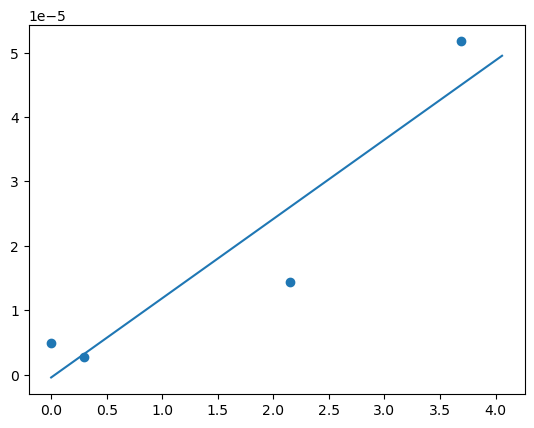

M1 Galactose LEUCINE 0.0002996785150166912 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M1 Galactose ISOLEUCINE -1.0952734720723657e-05 3.484217338740509e-06 0.31811391653155124


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


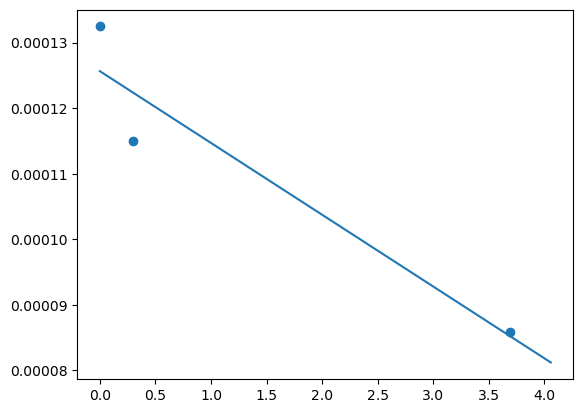

M1 Galactose METHIONINE 3.0726607433228778e-06 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


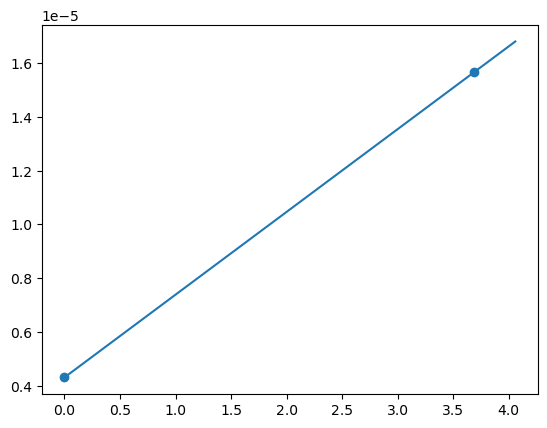

M1 Galactose GAMMA-AMINOBUTYRATE 0.001950981498371072 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


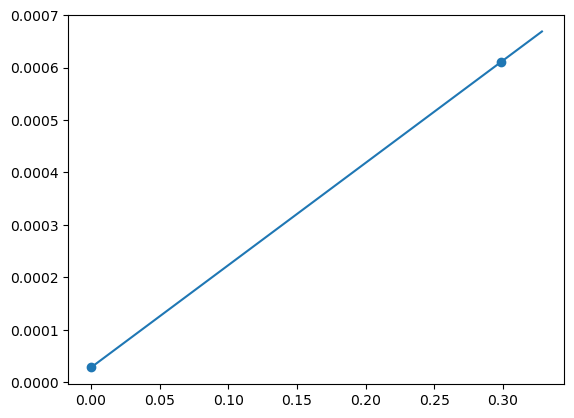

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M1 Galactose PROLINE -6.6703069307007045e-06 inf inf


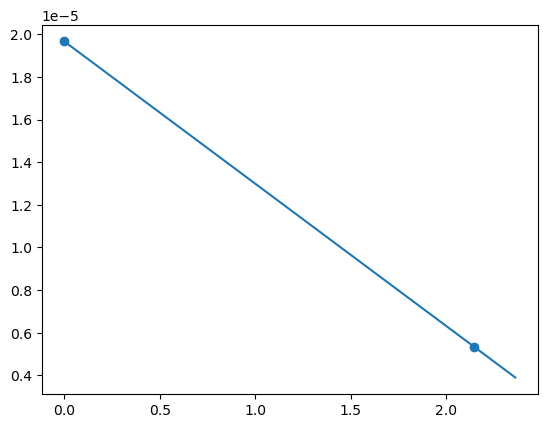

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M1 Galactose VALINE 1.003875668312619e-05 inf inf


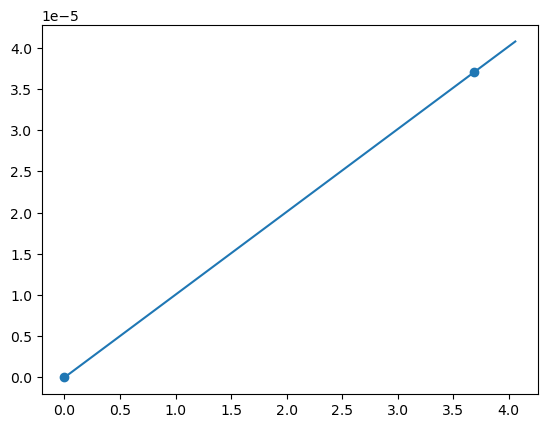

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M1 Galactose PIPECOLIC ACID 1.1750295234239789e-05 inf inf


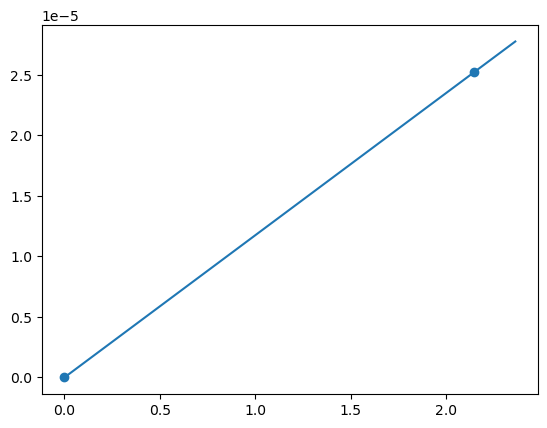

M1 Galactose BETA-ALANINE 3.075659697996716e-05 4.790429037147761e-06 0.15575289555824184


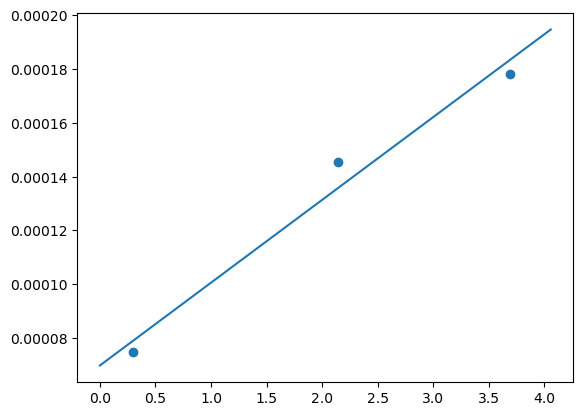

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M1 Galactose ALANINE -0.0005046700957951327 inf inf


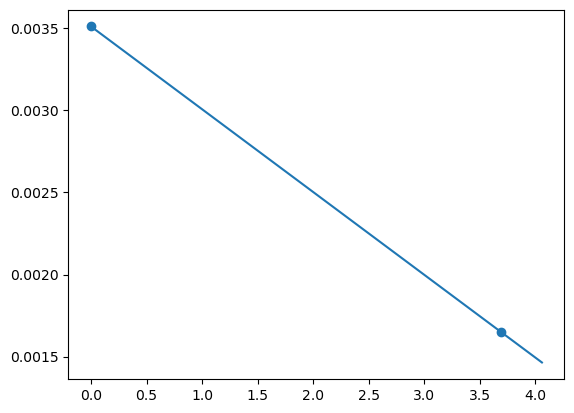

M1 Galactose CREATINE 1.4396009625111046e-06 2.7684626925031466e-07 0.19230764389557647


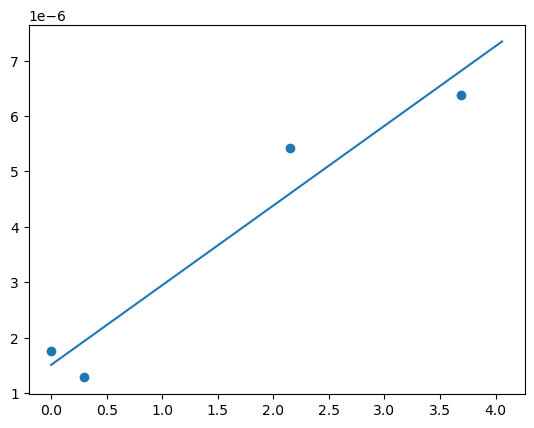

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M1 Galactose ALPHA-AMINOADIPATE 4.012316727541647e-05 inf inf


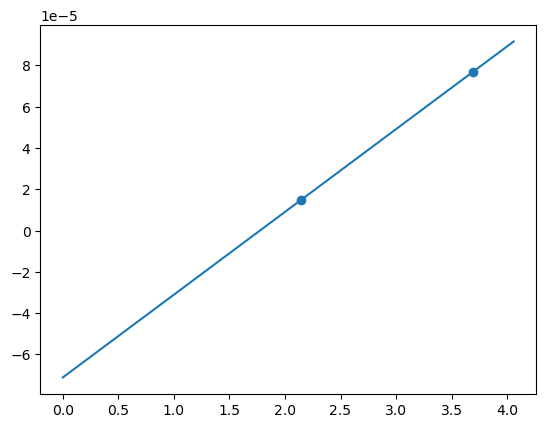

M1 Galactose GLUTAMATE 0.0025389279658078598 0.000579066474226575 0.22807518843580987


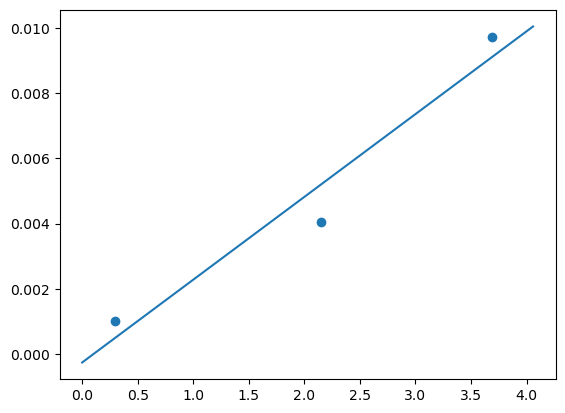

M1 Galactose ASPARAGINE -3.3636898984904674e-05 2.102880478681067e-05 0.6251707327791372


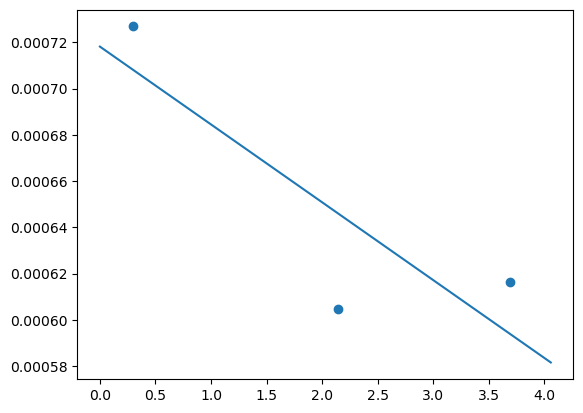

M1 Galactose ASPARTATE 0.00010132233786927824 1.4668033105995454e-05 0.14476603495785426


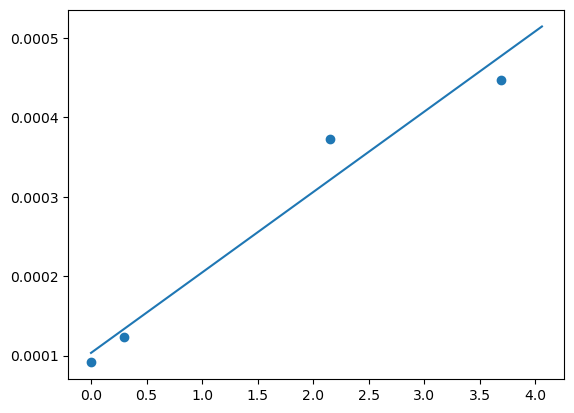

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M1 Galactose PYRUVATE 0.001926985281189744 inf inf


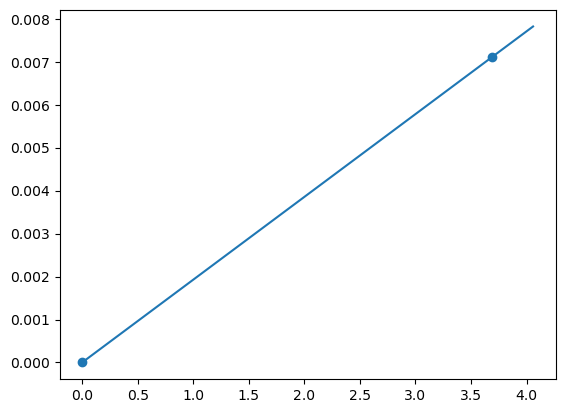

M1 Galactose LACTATE nan nan nan


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


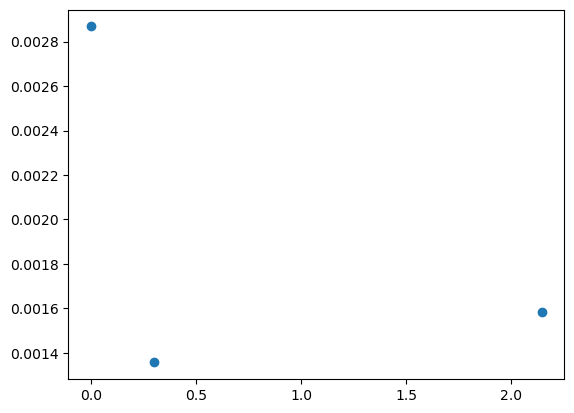

M1 Galactose HEXOSES including Glucose and Fructose -7.337311317516333 2.19194876554016 0.29874005213699056


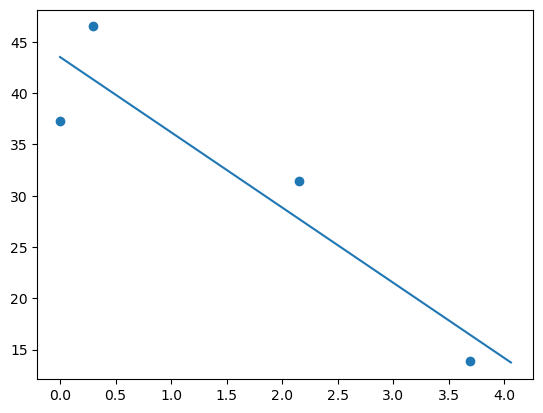

M1 Galactose NAD 1.9222793110562278e-05 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


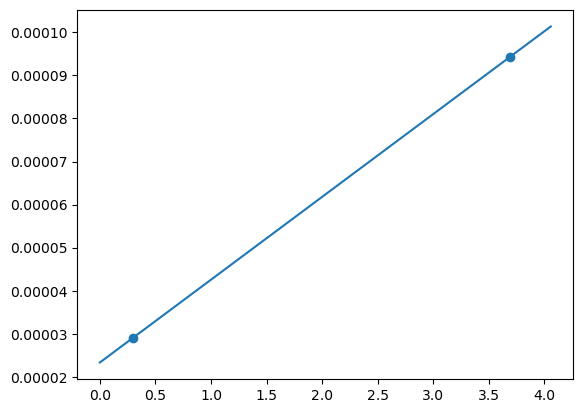

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M1 Galactose SUCCINATE 0.010565390162898461 inf inf


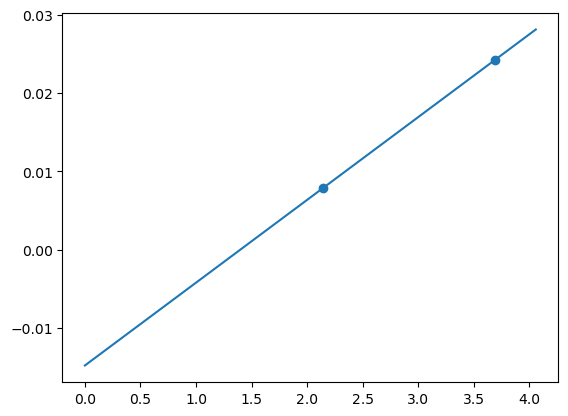

M1 Galactose MALATE 0.0007392245896459692 0.0019875301211464682 2.688668841628144


M1 Galactose CIS-ACONITATE 9.486394767842246e-05 2.2247498370389566e-06 0.02345200565108881


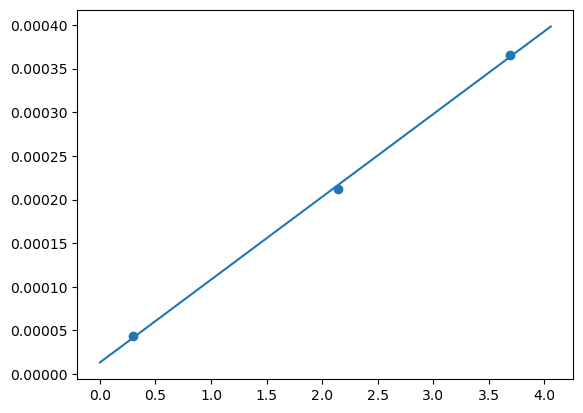

M1 Galactose CITRATE 9.501819893633713e-05 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M1 Galactose ISOCITRATE 6.609846430765805e-05 inf inf


M1 Galactose TRANS-ACONITATE 8.189257149682577e-06 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


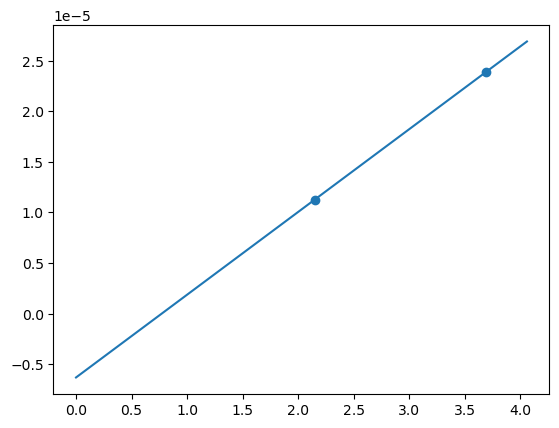

M2 Galactose PHENYLALANINE 1.019937352646367e-05 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


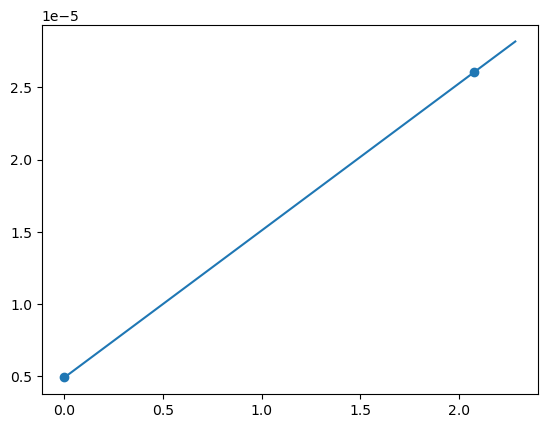

M2 Galactose LEUCINE 0.00011992447818064626 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


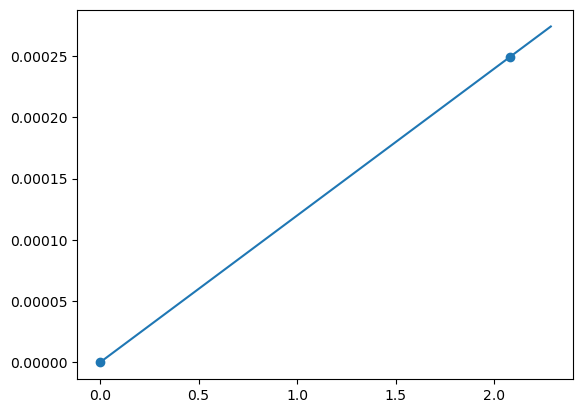

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M2 Galactose ISOLEUCINE nan nan nan


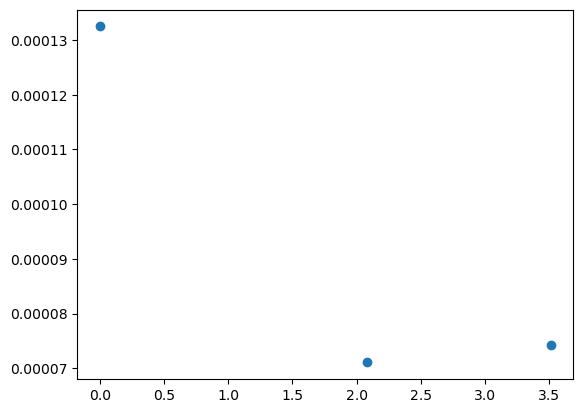

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M2 Galactose METHIONINE -1.2220031487298393e-06 inf inf


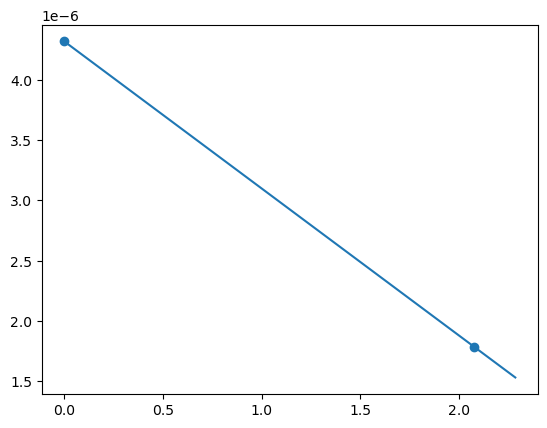

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M2 Galactose GAMMA-AMINOBUTYRATE nan nan nan


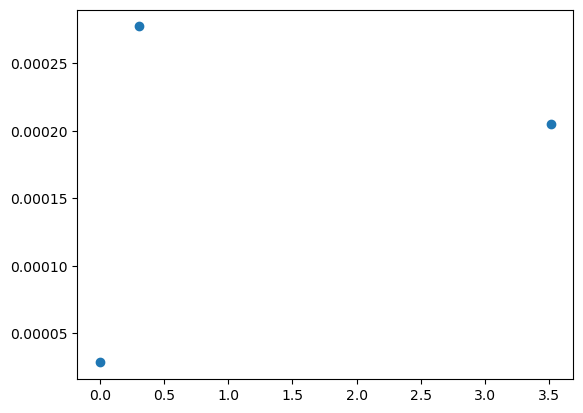

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M2 Galactose PROLINE -4.114485350032134e-06 inf inf


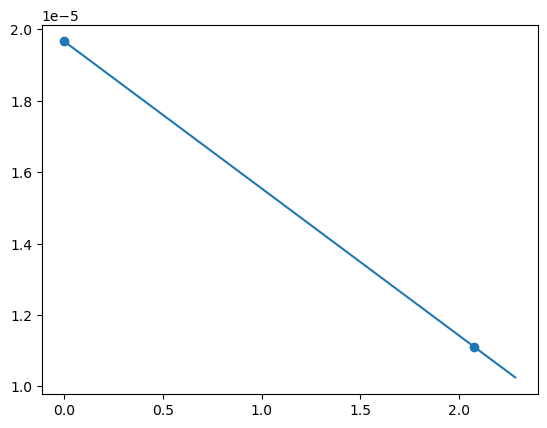

M2 Galactose PIPECOLIC ACID 4.779579625964581e-06 1.0472502249398713e-06 0.21910927464222812


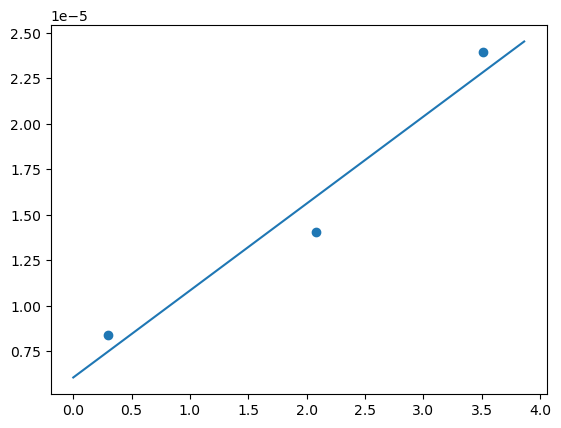

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M2 Galactose BETA-ALANINE 2.646915988825136e-05 inf inf


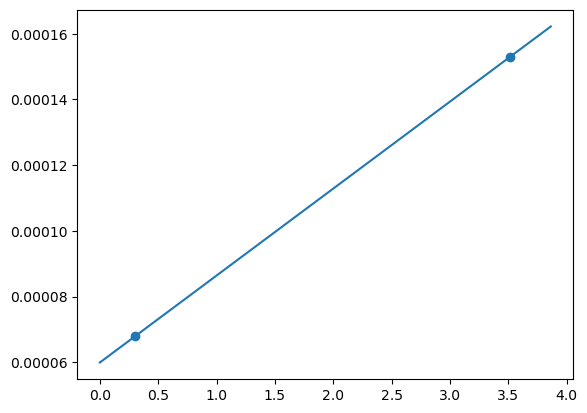

M2 Galactose CREATINE 1.4840033656405862e-06 3.9183080557778515e-07 0.26403633216063976


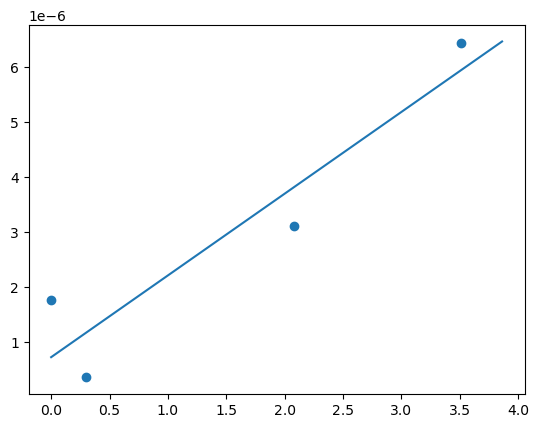

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M2 Galactose ALPHA-AMINOADIPATE 9.285030879429485e-06 inf inf


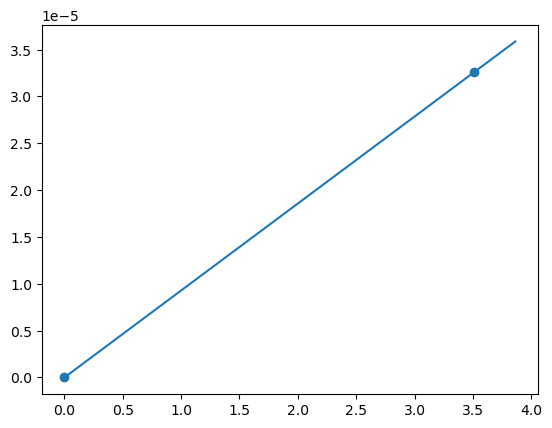

M2 Galactose GLUTAMATE 0.0008526467211518818 0.00028981210740856774 0.3398970525765308


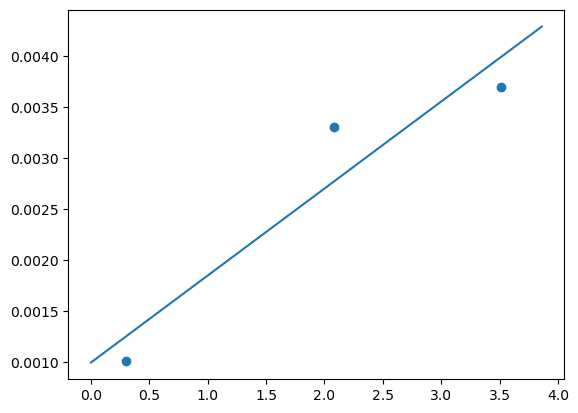

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M2 Galactose ASPARAGINE 3.138503782778961e-05 inf inf


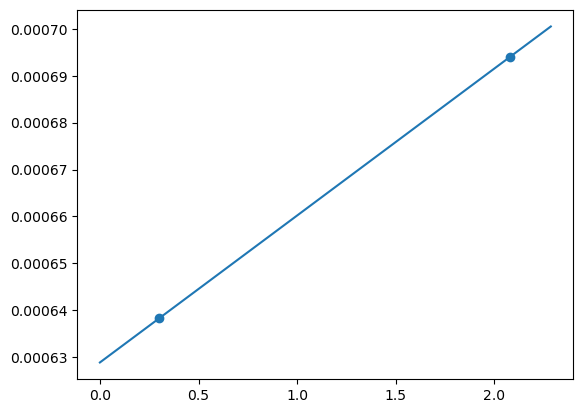

M2 Galactose ASPARTATE 9.564023592770225e-05 1.9657073697504925e-05 0.20553142207181907


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M2 Galactose PYRUVATE 0.0027316919000449883 inf inf


M2 Galactose LACTATE nan nan nan


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M2 Galactose HEXOSES including Glucose and Fructose -7.998748566662081 1.0264502250154999 0.1283263521113332


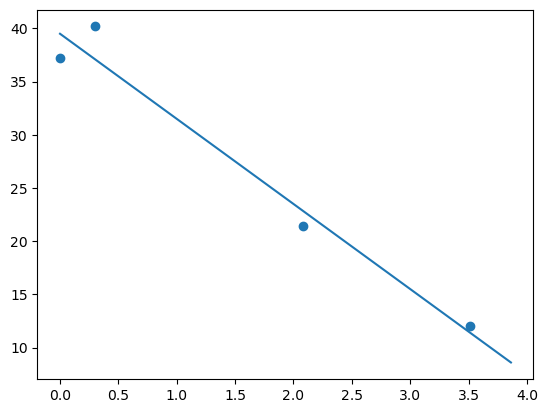

M2 Galactose NAD 1.5130334578752855e-05 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M2 Galactose SUCCINATE 0.009698679893093554 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M2 Galactose MALATE 0.001709109058955602 0.00037901560090734565 0.22176209231431582


M2 Galactose CIS-ACONITATE 0.00012053815299978307 2.064427634139551e-06 0.0171267568214959


M2 Galactose ISOCITRATE 6.453172676064346e-05 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M2 Galactose TRANS-ACONITATE 5.333708396977559e-06 8.972950927801171e-07 0.16823099914659478


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M3 Galactose PHENYLALANINE 1.876260948454432e-05 1.195798026985265e-05 0.6373303393487469


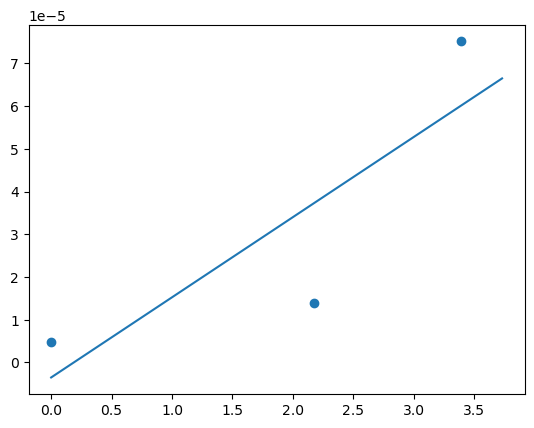

M3 Galactose LEUCINE 0.00011510686077082294 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


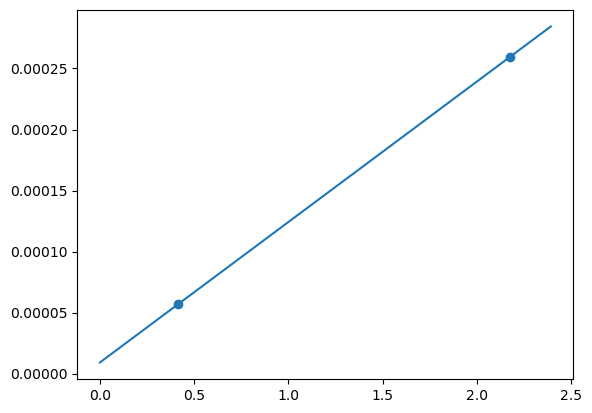

M3 Galactose ISOLEUCINE -1.9424173008247427e-05 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M3 Galactose METHIONINE 1.0073867786488653e-05 inf inf


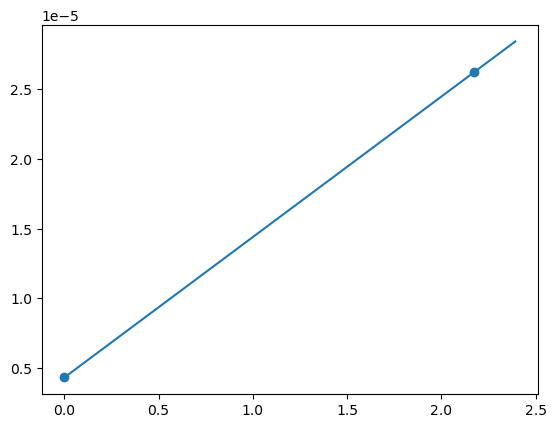

M3 Galactose GAMMA-AMINOBUTYRATE 0.00011784870161500641 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


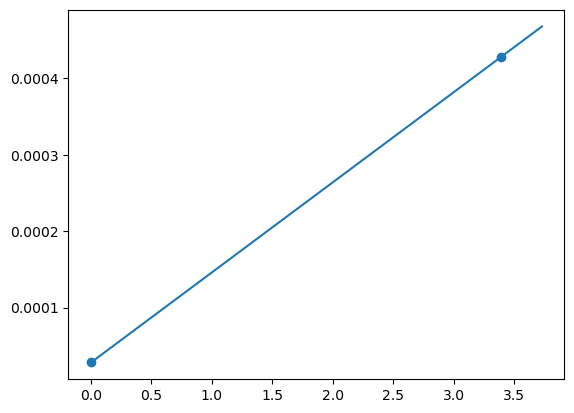

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M3 Galactose PROLINE 1.0575478841330041e-05 inf inf


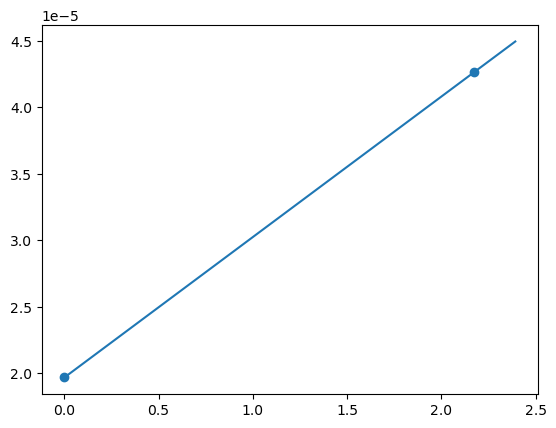

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M3 Galactose TYROSINE 8.901691877122514e-07 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M3 Galactose VALINE 8.062516947423461e-06 inf inf


M3 Galactose PIPECOLIC ACID 4.955681948750655e-06 2.473959655073567e-07 0.04992167941078746


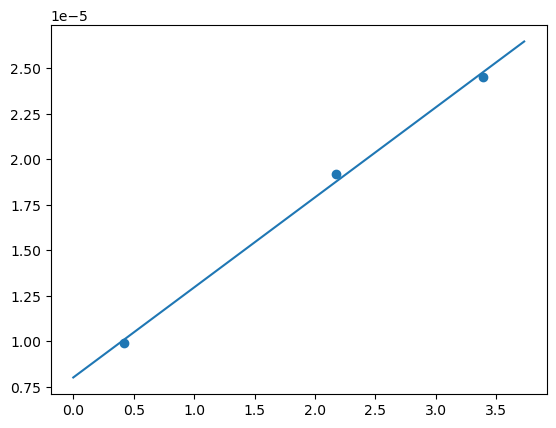

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M3 Galactose BETA-ALANINE 3.316007491772437e-05 inf inf


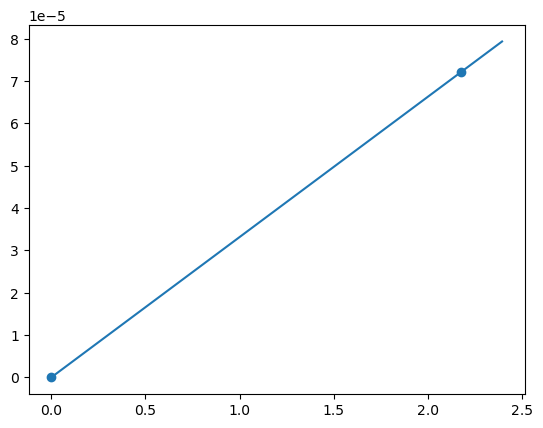

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M3 Galactose ALANINE -0.0006857539612929944 inf inf


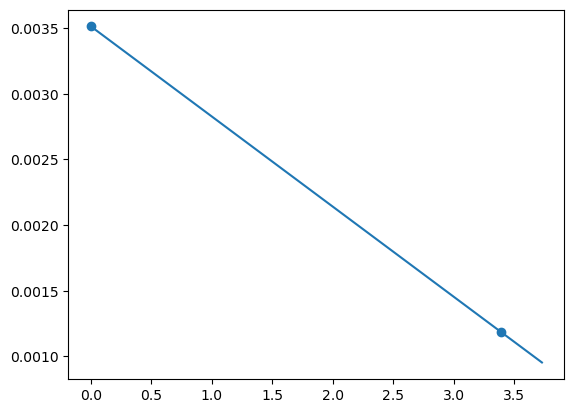

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M3 Galactose CREATINE 5.297186146912878e-08 4.90296075691996e-07 9.255783393183819


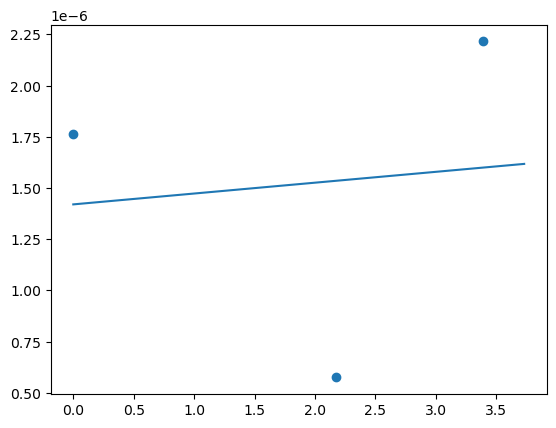

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M3 Galactose ALPHA-AMINOADIPATE 1.325374470532785e-05 inf inf


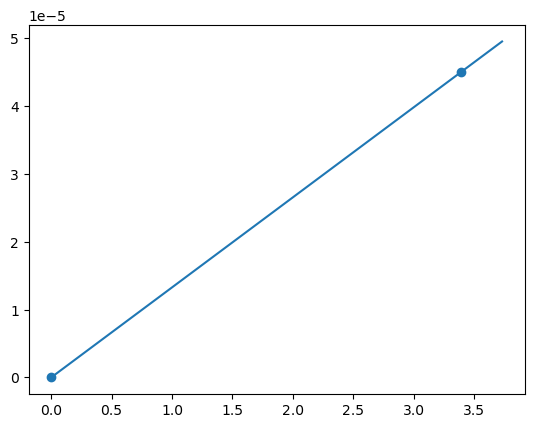

M3 Galactose GLUTAMINE 1.6705104541203595e-05 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M3 Galactose GLUTAMATE 0.005496211887256467 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M3 Galactose ASPARAGINE -0.00031676633923231933 inf inf


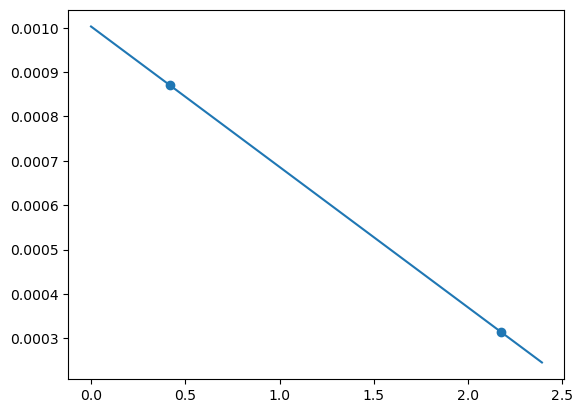

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M3 Galactose ASPARTATE 0.00016935102642823407 1.2396762540395506e-05 0.07320157900341327


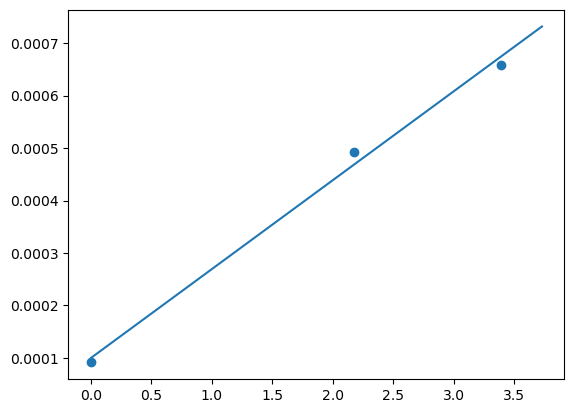

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M3 Galactose LYSINE 0.0001638372137052774 inf inf


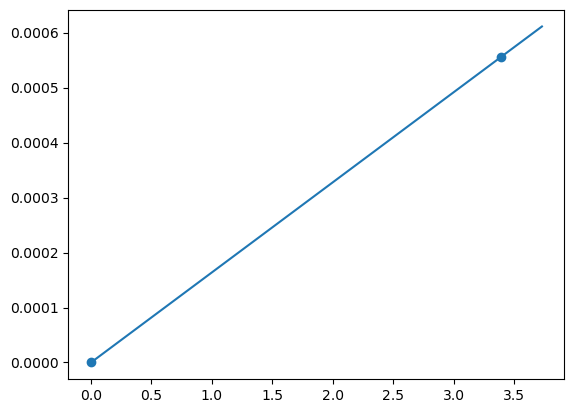

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M3 Galactose LACTATE -0.0005920570587942025 0.0005554986973290968 0.9382519625058414


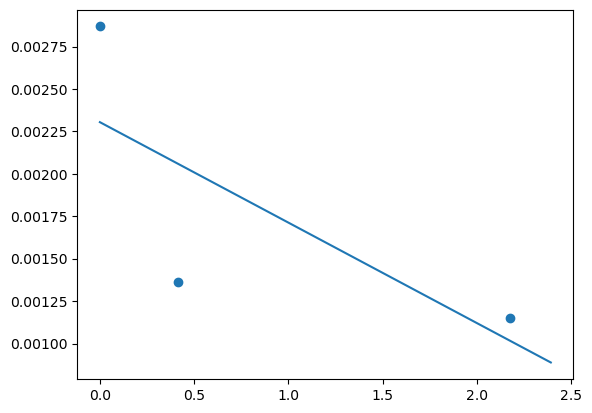

M3 Galactose HEXOSES including Glucose and Fructose -5.908608873647218 1.0903950081012452 0.18454344015974358


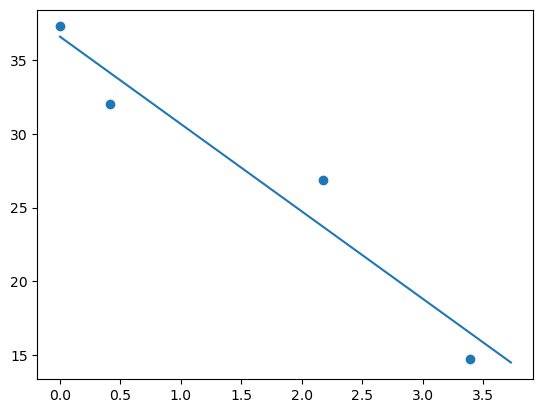

M3 Galactose NAD -1.2960669960446934e-07 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


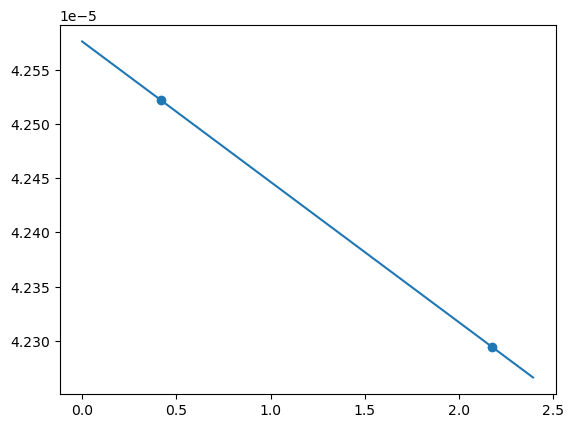

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M3 Galactose SUCCINATE 0.04670561806065026 inf inf


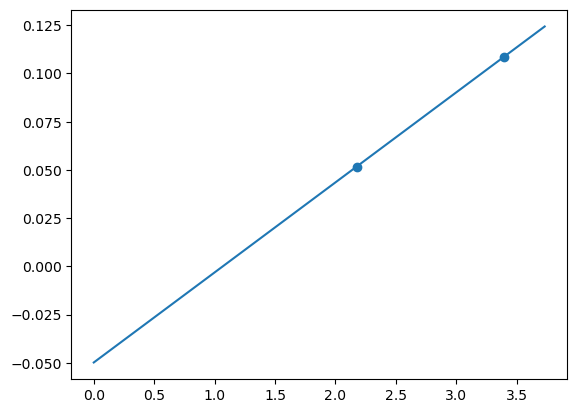

M3 Galactose MALATE -0.0009376163203328494 0.0017662172249223995 1.883731315913316


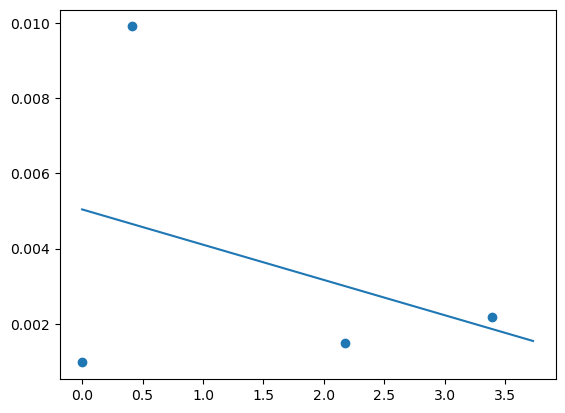

M3 Galactose CIS-ACONITATE 8.9566945919439e-05 1.1315734390241891e-05 0.12633828555927126


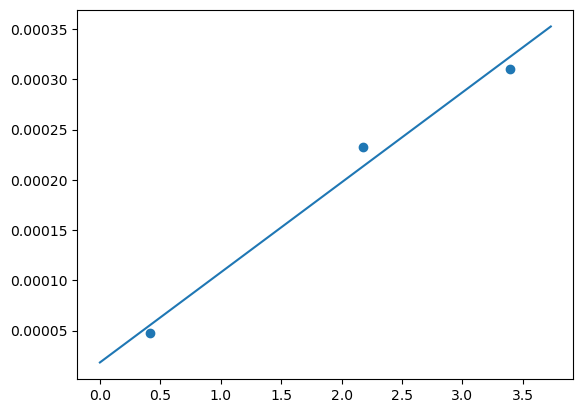

M3 Galactose ISOCITRATE 2.2234640204471654e-05 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


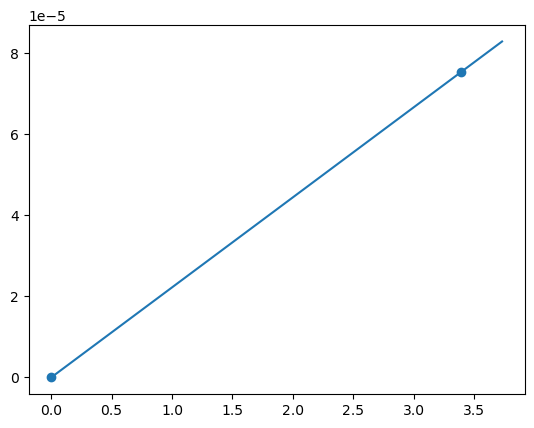

M3 Galactose TRANS-ACONITATE 4.145615851519875e-06 4.559460833663719e-07 0.10998271419654379


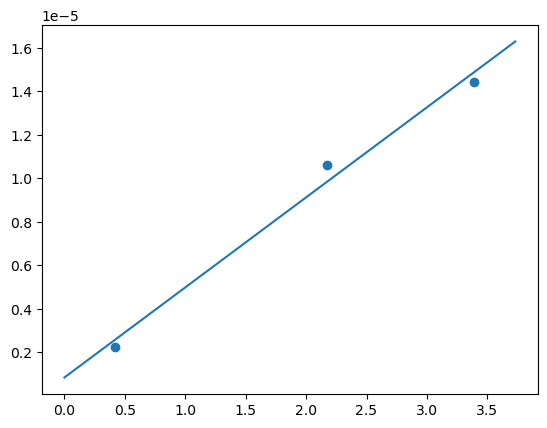

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M5 L-malate ISOLEUCINE nan nan nan


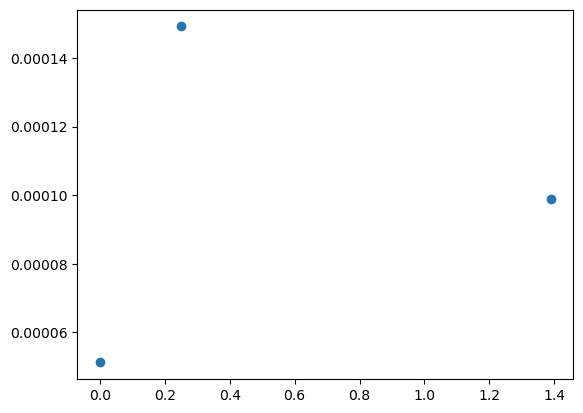

M5 L-malate METHIONINE 5.0335316941599754e-05 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


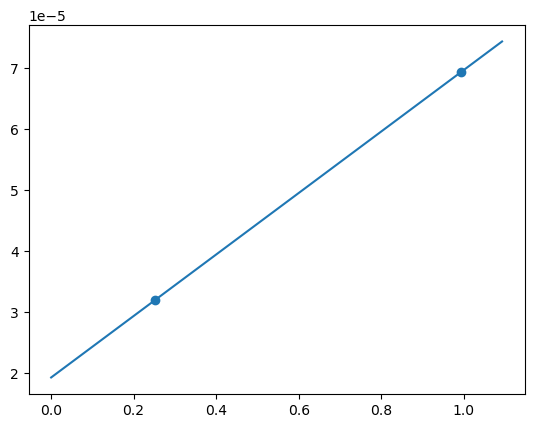

M5 L-malate GAMMA-AMINOBUTYRATE 0.001168384362453835 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


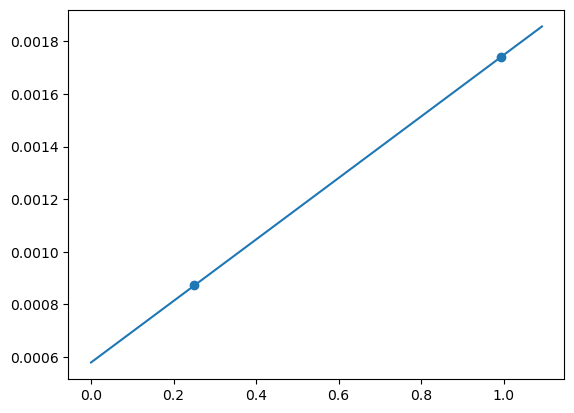

M5 L-malate PROLINE -1.807933362545196e-05 1.2488622036804714e-05 0.6907678289217098


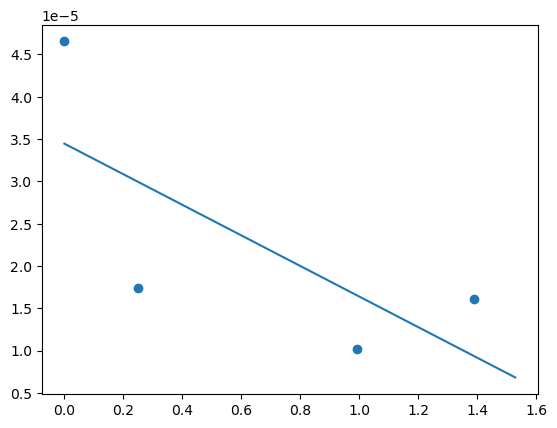

M5 L-malate TYROSINE 6.868467660390813e-06 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


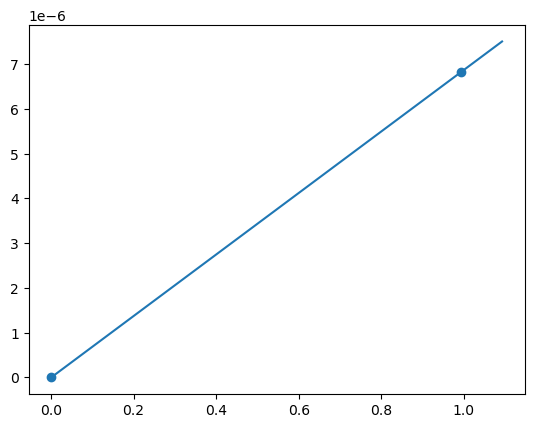

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M5 L-malate PIPECOLIC ACID 1.2302451673184252e-05 inf inf


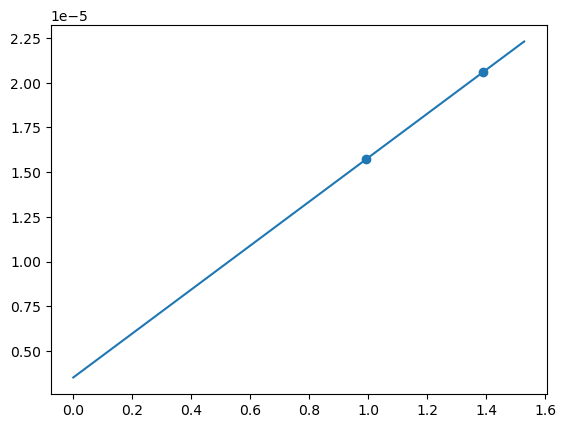

M5 L-malate BETA-ALANINE 0.00013146747057611312 1.4202819729431788e-05 0.10803295801761899


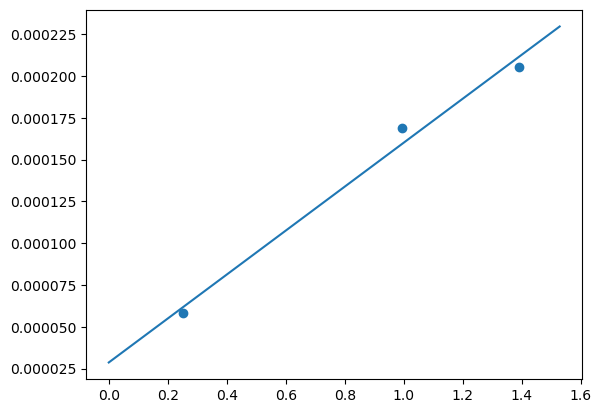

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M5 L-malate ALANINE -0.0024966130317279176 inf inf


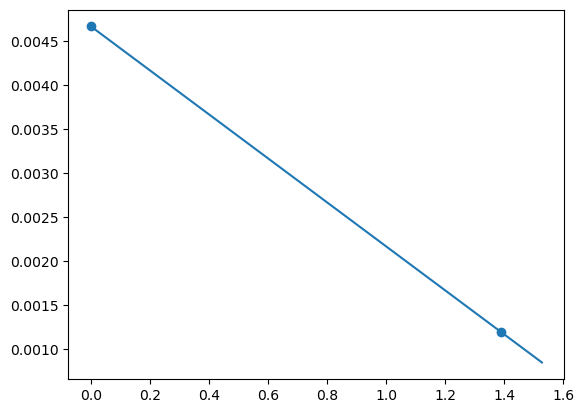

M5 L-malate CREATINE 7.567969439142998e-07 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


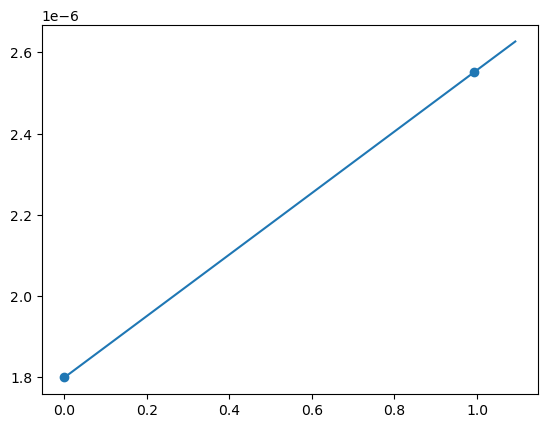

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M5 L-malate ALPHA-AMINOADIPATE 3.8280642398349684e-05 inf inf


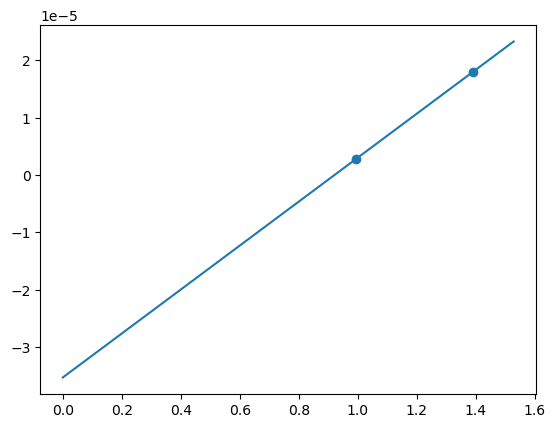

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M5 L-malate GLUTAMINE 0.00016978509468232992 inf inf


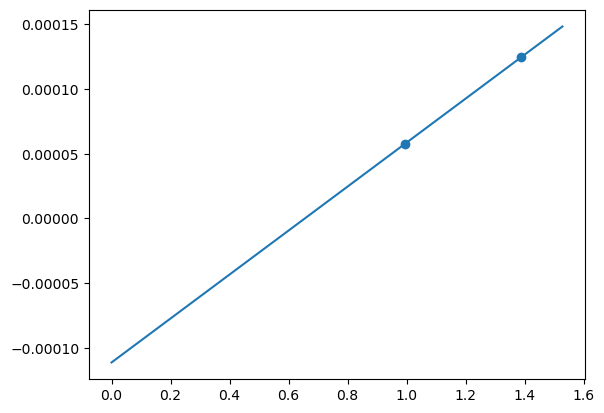

M5 L-malate GLUTAMATE 0.005263660879907861 0.0035533811089210722 0.6750778954025765


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


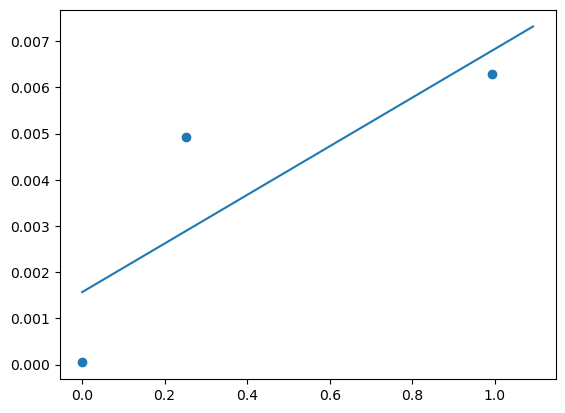

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M5 L-malate ASPARAGINE 0.0003959993108333265 1.207750726245673e-05 0.030498808790957906


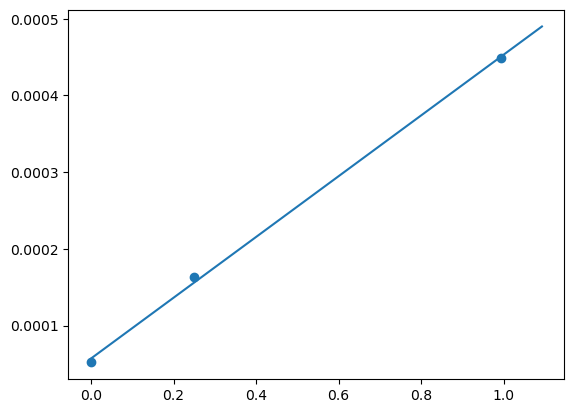

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M5 L-malate ASPARTATE 0.005199377794291454 0.004540495519096101 0.8732767070862288


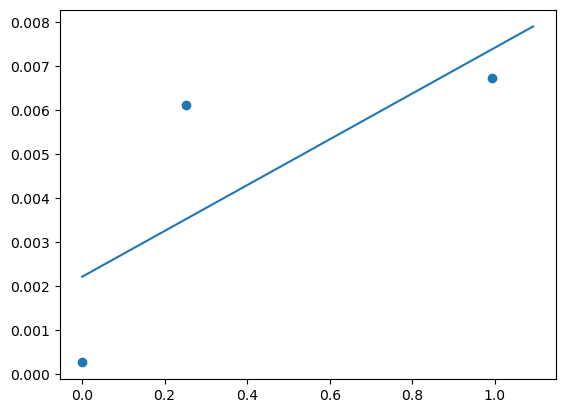

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M5 L-malate LYSINE 5.540233989324562e-05 inf inf


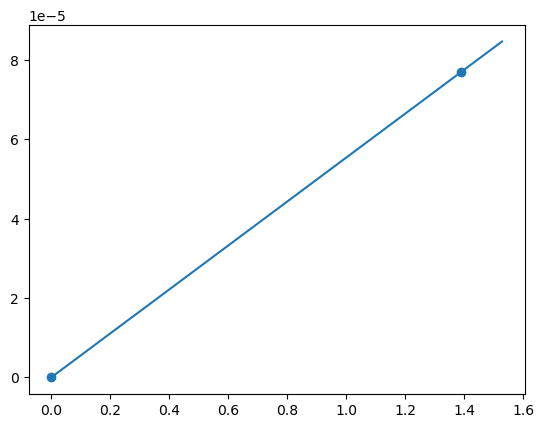

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M5 L-malate PYRUVATE 0.04756856114620785 inf inf


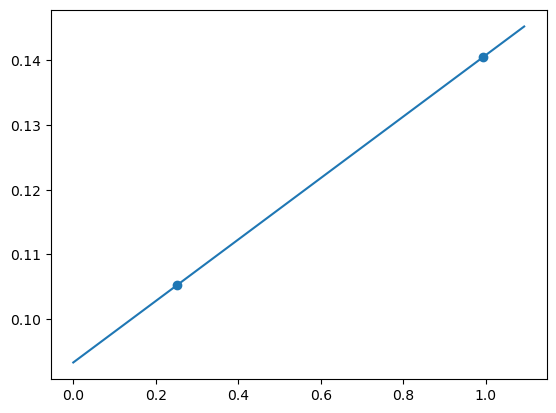

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M5 L-malate LACTATE -0.008698737755318684 inf inf


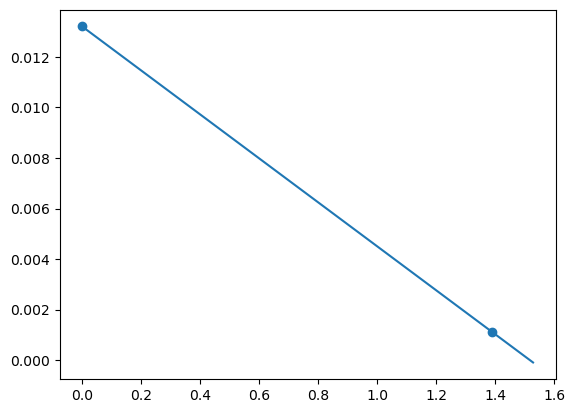

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M5 L-malate NAD 3.438302949493883e-07 inf inf


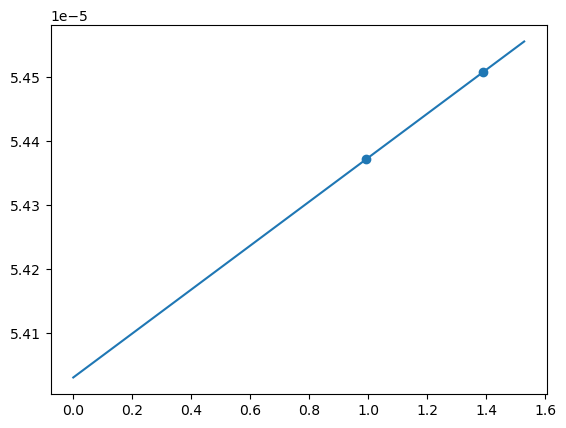

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M5 L-malate SUCCINATE -0.46418231750310773 0.28299727456314605 0.6096683649765512


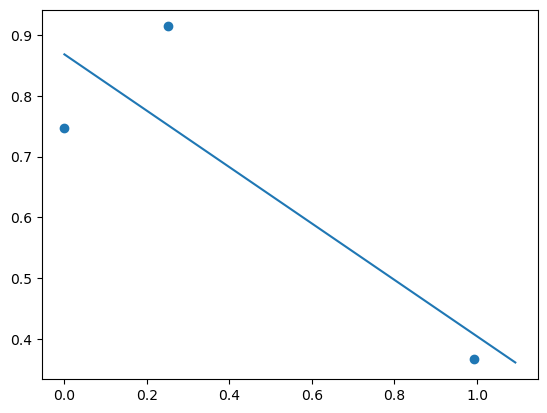

M5 L-malate MALATE -18.66995512919513 1.33046267760167 0.07126223220114546


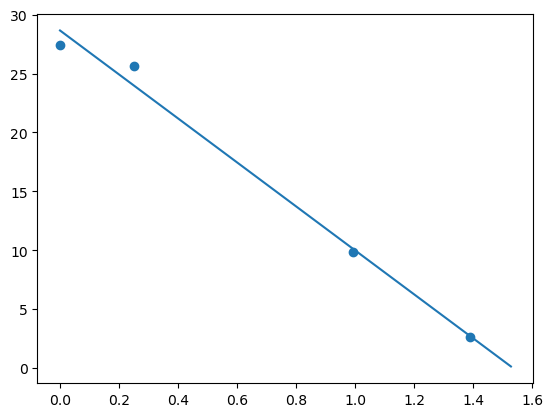

M5 L-malate CIS-ACONITATE 0.0005059398325210596 9.341685312941974e-05 0.18464024203022458


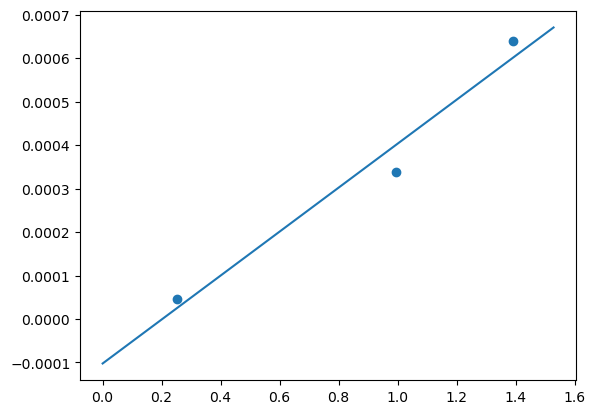

M5 L-malate CITRATE 0.0169680950289414 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


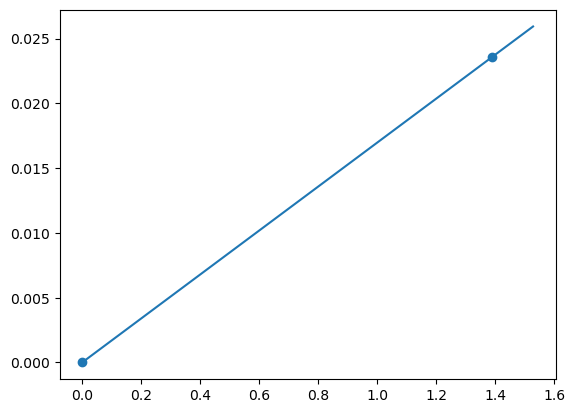

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M5 L-malate ISOCITRATE 0.0012180902075337831 inf inf


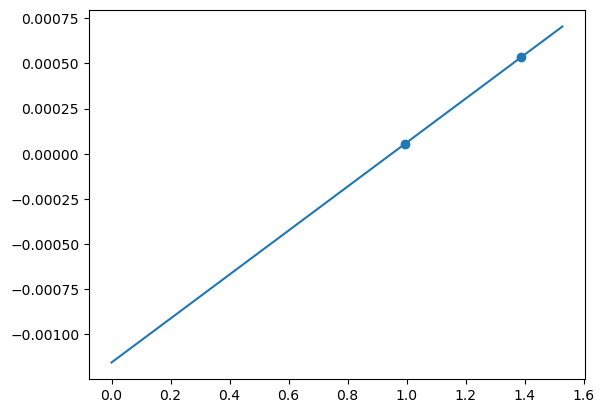

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M5 L-malate TRANS-ACONITATE 6.600418284420572e-07 inf inf


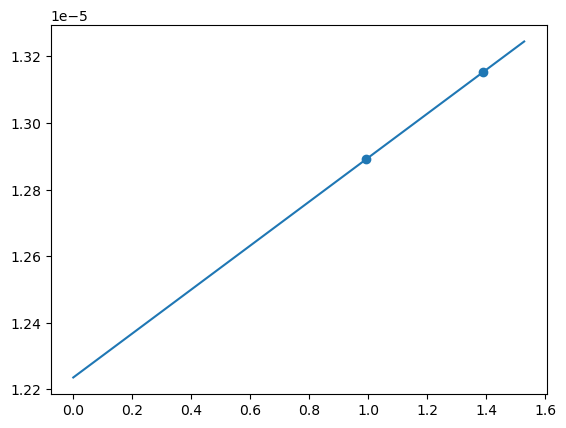

M6 L-malate PHENYLALANINE nan nan nan


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


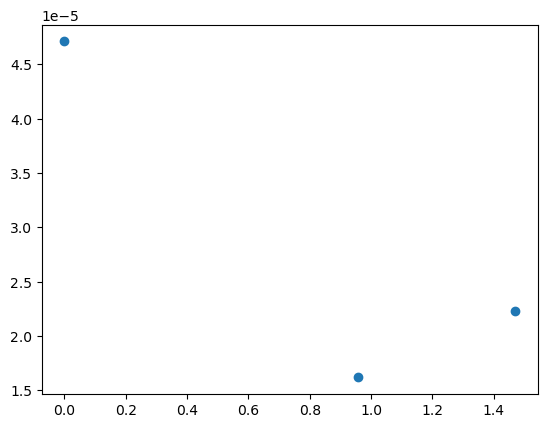

M6 L-malate LEUCINE 7.221432413508223e-05 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


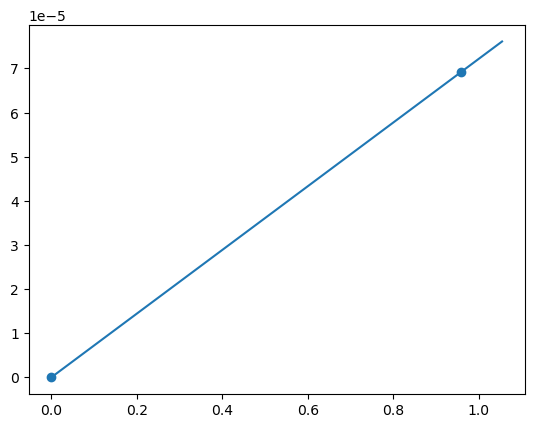

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M6 L-malate ISOLEUCINE 4.476141067214557e-05 inf inf


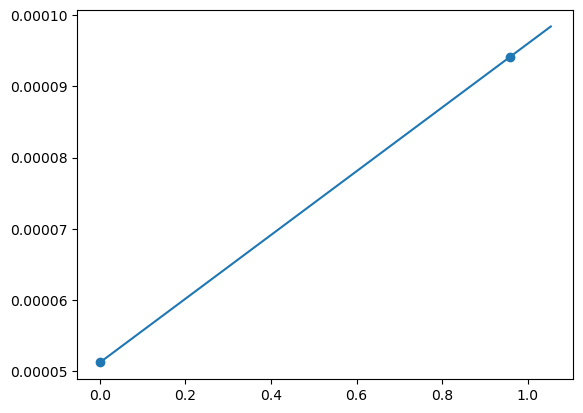

M6 L-malate METHIONINE 2.9669565812163154e-05 1.1663880620585834e-06 0.03931260974437375


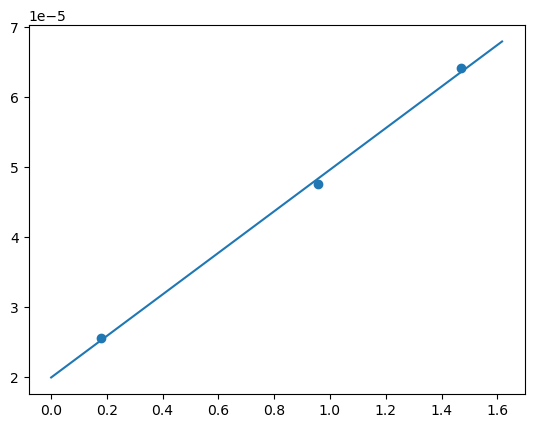

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M6 L-malate GAMMA-AMINOBUTYRATE -4.140227185514265e-07 inf inf


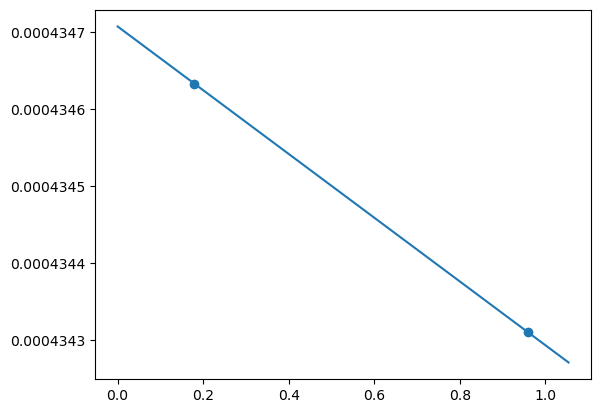

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M6 L-malate PROLINE -2.195264990551814e-05 inf inf


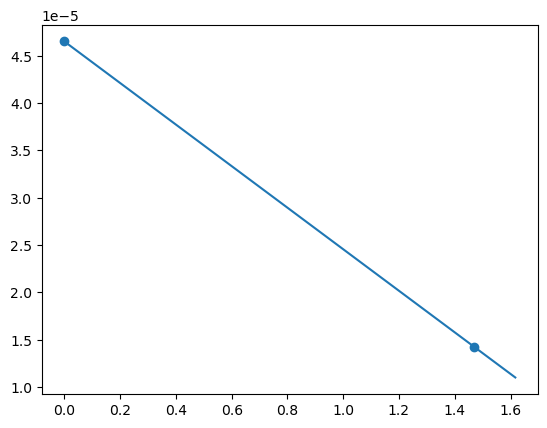

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M6 L-malate PIPECOLIC ACID 1.5083042870664027e-06 inf inf


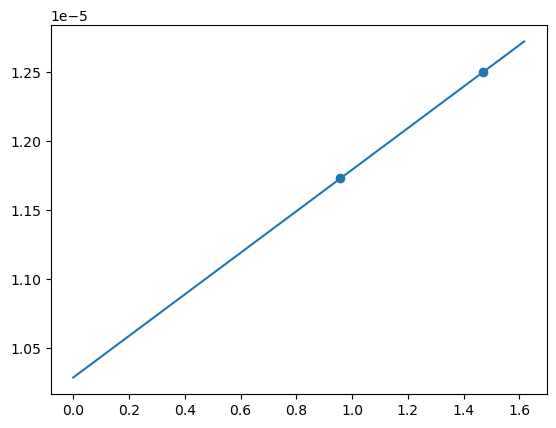

M6 L-malate BETA-ALANINE 0.00010157100659164843 1.106769927666098e-05 0.10896514318458089


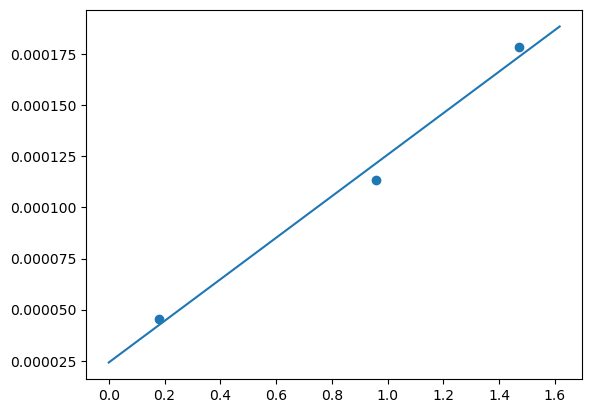

M6 L-malate CREATINE -2.5485914326695546e-07 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


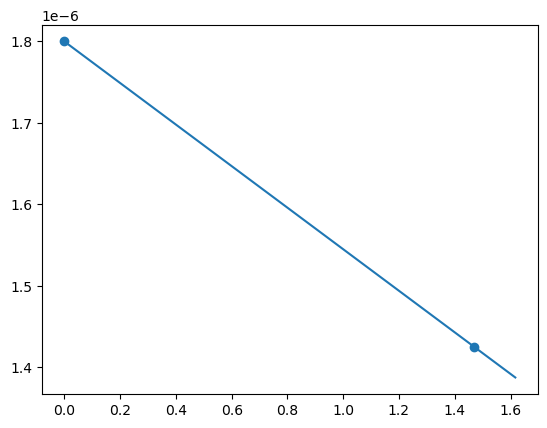

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M6 L-malate ALPHA-AMINOADIPATE 6.0885824060188946e-05 inf inf


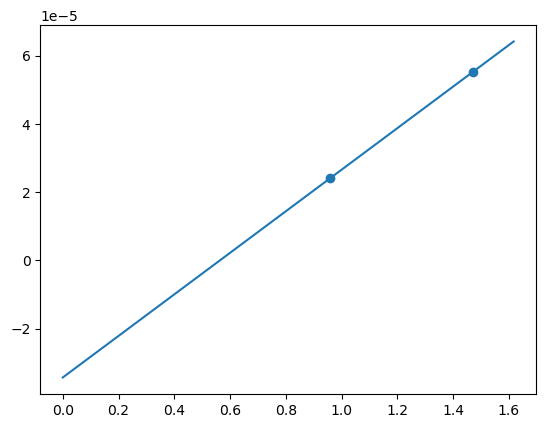

M6 L-malate GLUTAMATE 0.004152712751493519 0.001327449985708223 0.31965851363805675


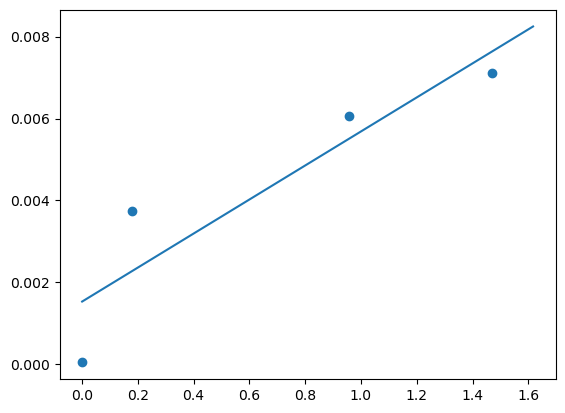

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M6 L-malate ASPARAGINE 0.00021080870227076776 0.00010575787682206039 0.5016769975948262


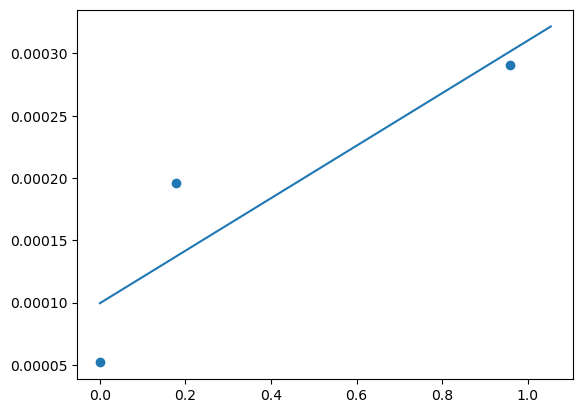

M6 L-malate ASPARTATE 0.005384987611536137 0.006210366393525982 1.153274035435412


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


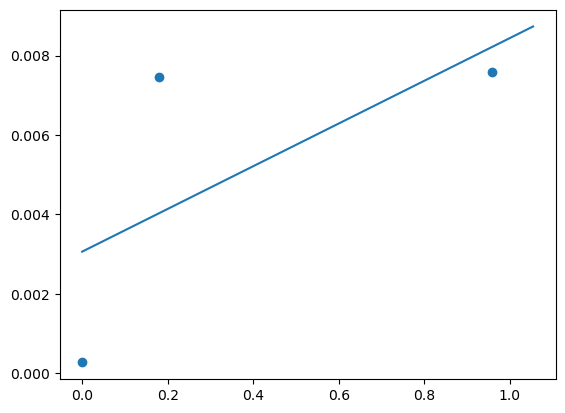

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M6 L-malate PYRUVATE 0.28071339237594006 inf inf


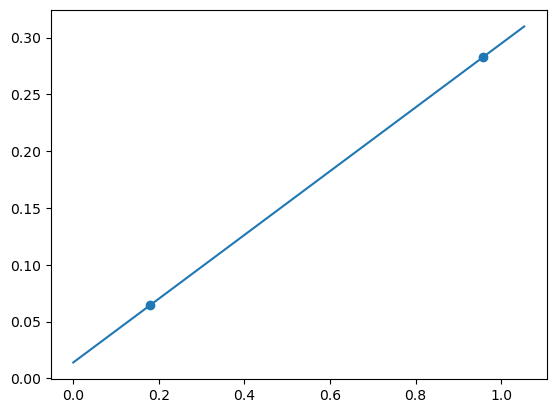

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M6 L-malate LACTATE nan nan nan


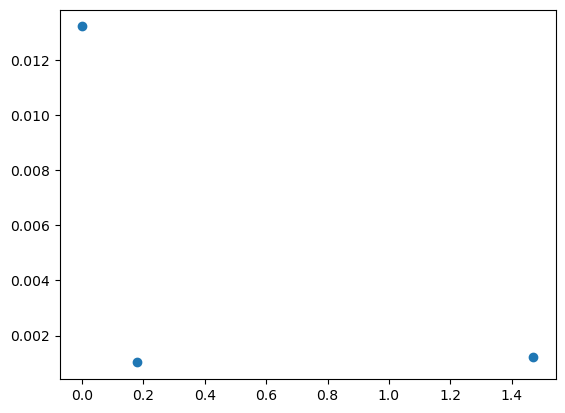

M6 L-malate NAD -3.642493957034573e-05 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


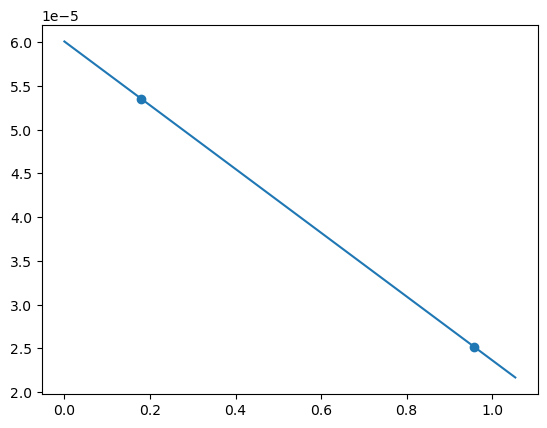

M6 L-malate SUCCINATE nan nan nan


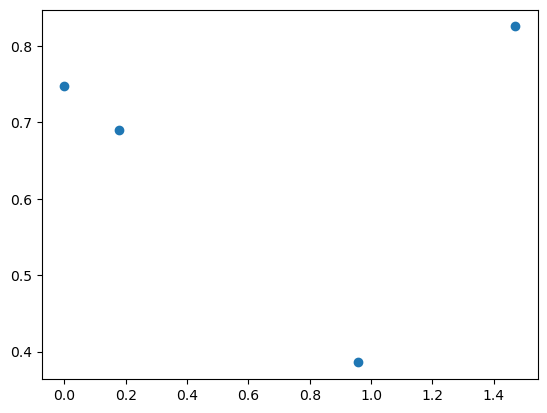

M6 L-malate MALATE -14.348103099367647 2.3044043912522234 0.16060690220115464


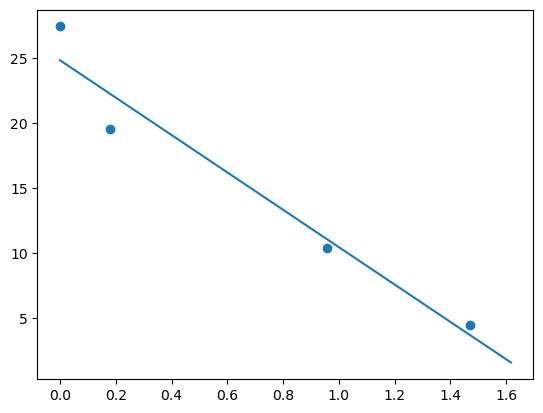

M6 L-malate CIS-ACONITATE 0.00038072754659017127 3.311646071525446e-05 0.08698204532834132


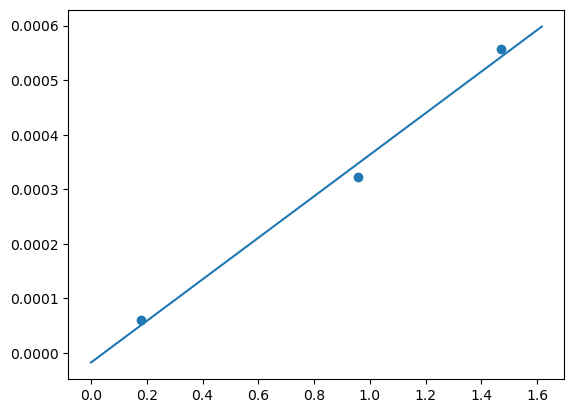

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M6 L-malate CITRATE 0.0035006826252152834 inf inf


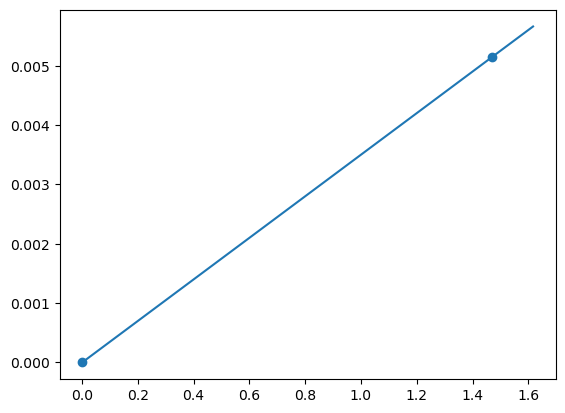

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M6 L-malate ISOCITRATE 0.0008585405902567478 inf inf


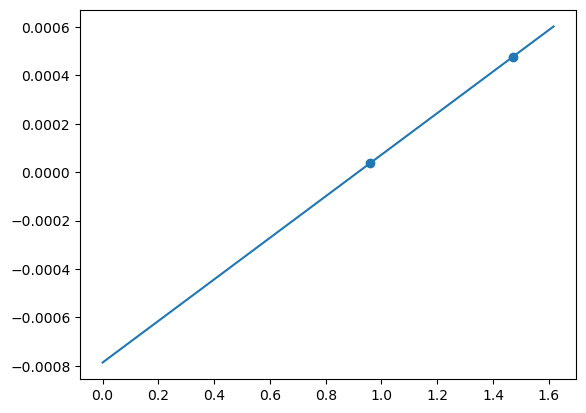

M6 L-malate TRANS-ACONITATE 2.1841204978992686e-05 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


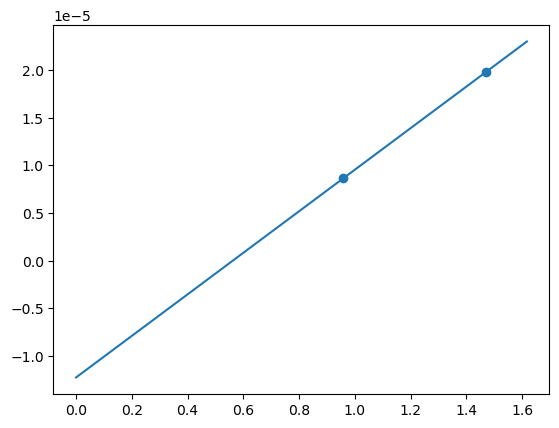

M7 L-malate PHENYLALANINE nan nan nan


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


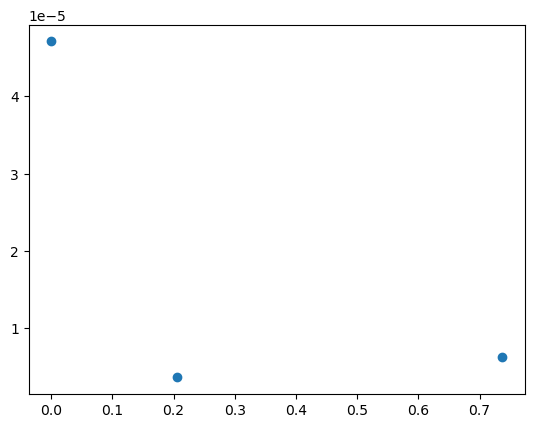

M7 L-malate LEUCINE 5.368934579134557e-05 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


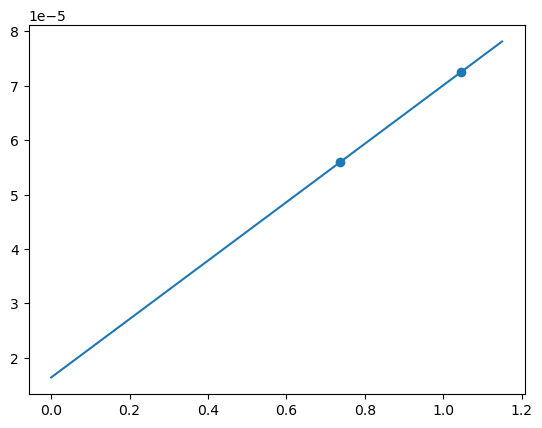

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M7 L-malate ISOLEUCINE nan nan nan


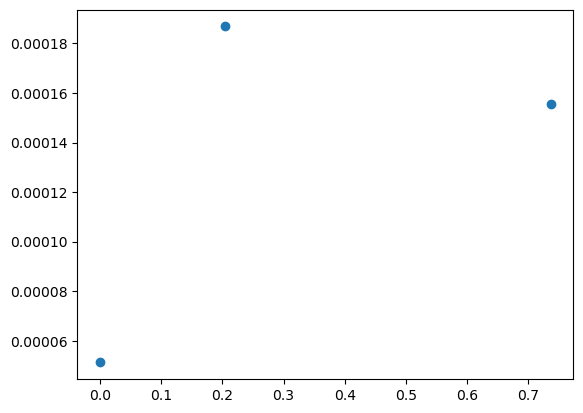

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M7 L-malate METHIONINE 1.2785878349094655e-05 inf inf


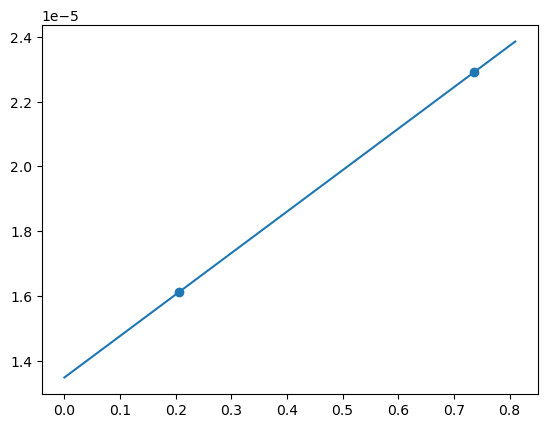

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M7 L-malate GAMMA-AMINOBUTYRATE 0.001987083996213749 inf inf


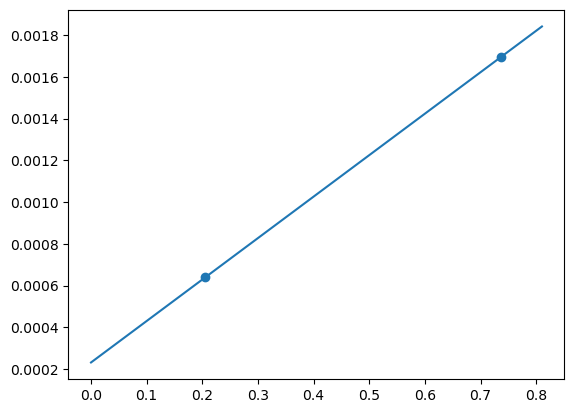

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M7 L-malate PROLINE -2.607927913418704e-05 inf inf


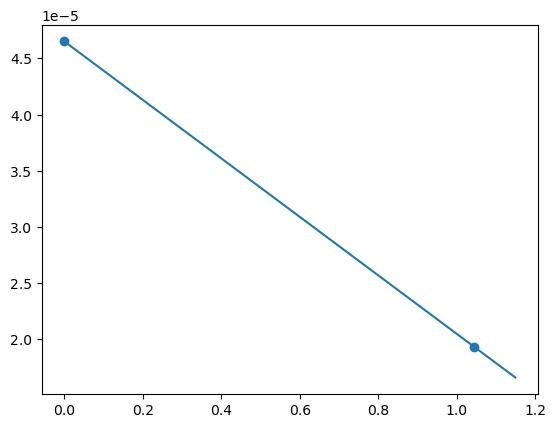

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M7 L-malate PIPECOLIC ACID 5.5424620833793605e-05 inf inf


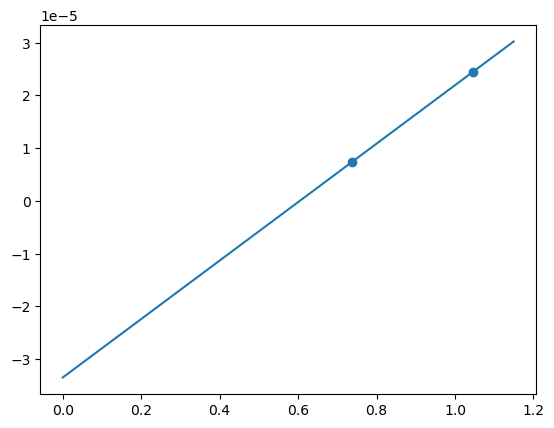

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M7 L-malate BETA-ALANINE 0.0005466337315706127 inf inf


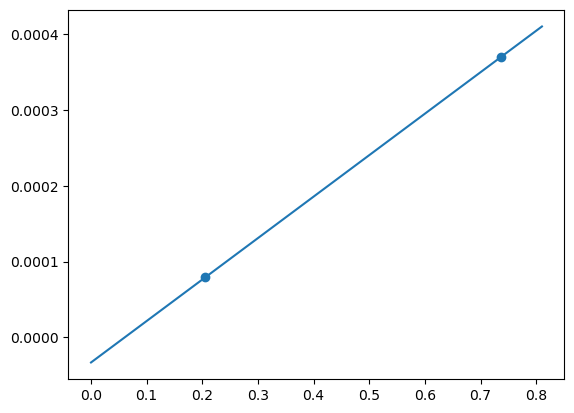

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M7 L-malate CREATINE -4.546045813804989e-07 inf inf


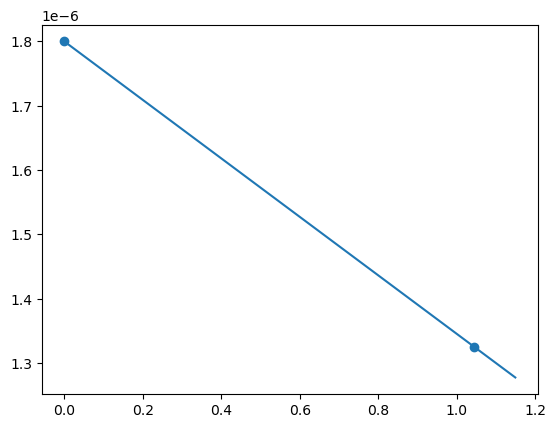

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M7 L-malate ALPHA-AMINOADIPATE 3.4286529411194066e-05 inf inf


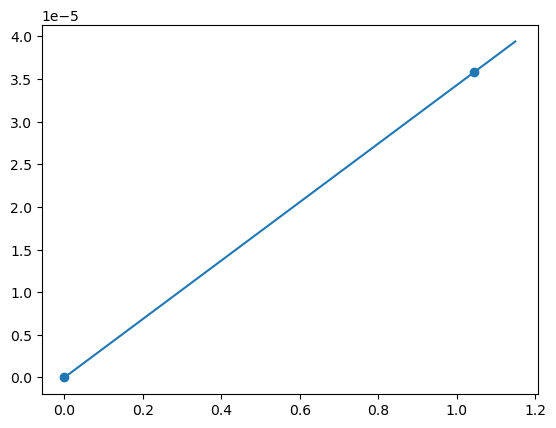

M7 L-malate GLUTAMATE nan nan nan


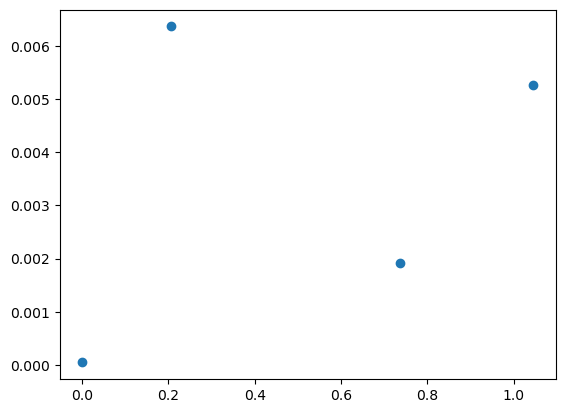

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M7 L-malate ASPARAGINE 0.00024046090072871764 8.214372124767042e-05 0.341609471638564


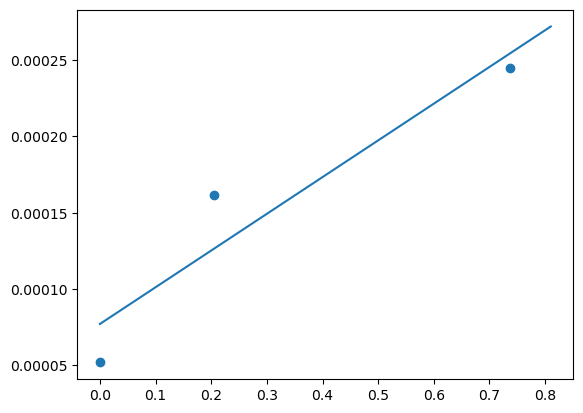

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M7 L-malate ASPARTATE nan nan nan


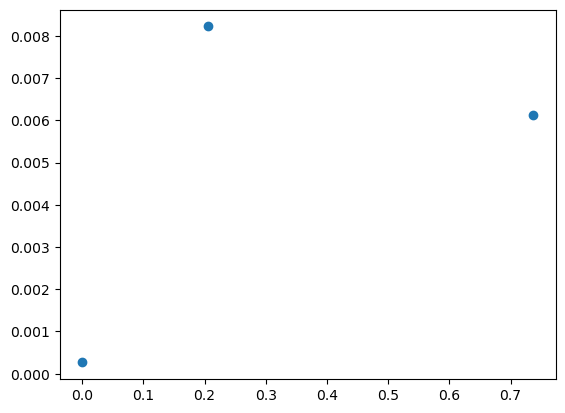

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M7 L-malate PYRUVATE 0.07765510542278982 inf inf


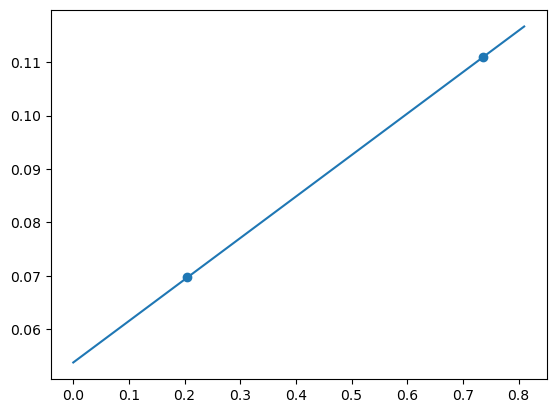

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M7 L-malate LACTATE -0.011638334115026312 inf inf


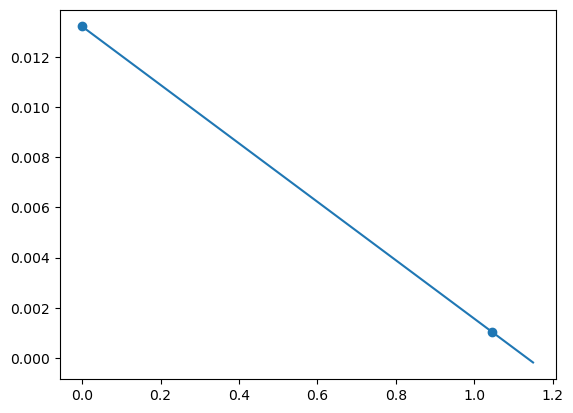

M7 L-malate NAD 6.932914936658831e-05 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


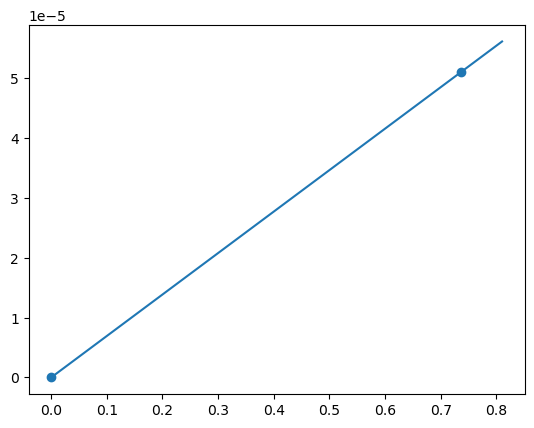

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M7 L-malate SUCCINATE nan nan nan


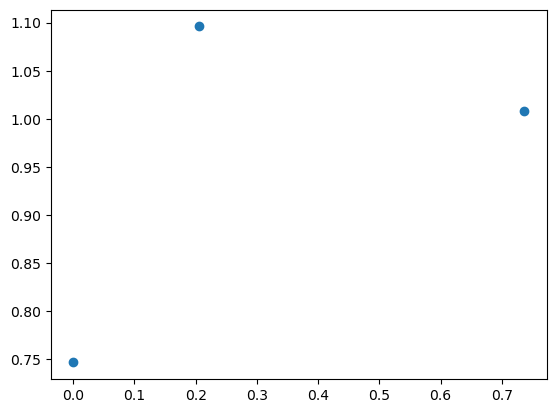

M7 L-malate MALATE -19.406590173926638 0.12870085969947628 0.006631812108465604


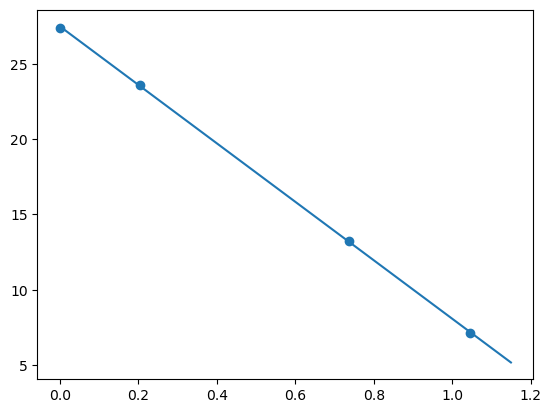

M7 L-malate CIS-ACONITATE 0.0005312097236312862 6.873700730644081e-05 0.12939711802819204


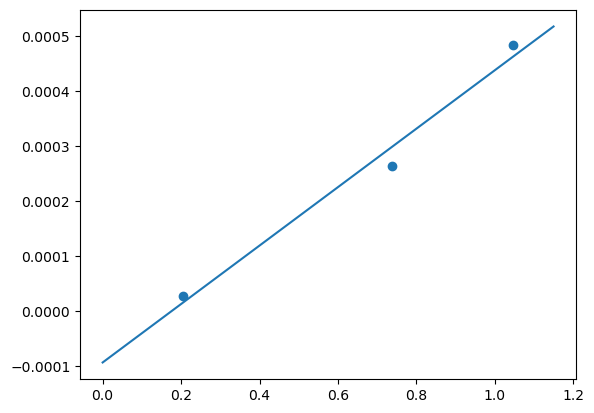

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M7 L-malate CITRATE 0.00010428178860988762 inf inf


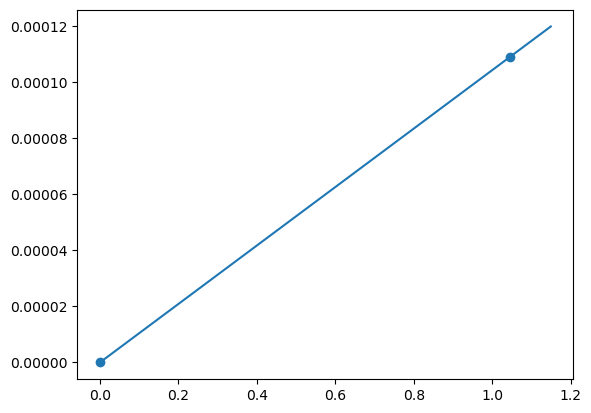

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M7 L-malate ISOCITRATE 0.00014715585862076154 inf inf


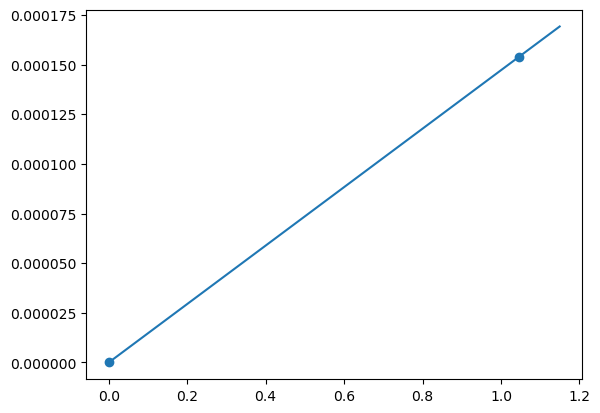

M7 L-malate TRANS-ACONITATE 1.444920008046883e-05 1.7810197823287726e-06 0.12326078761523969


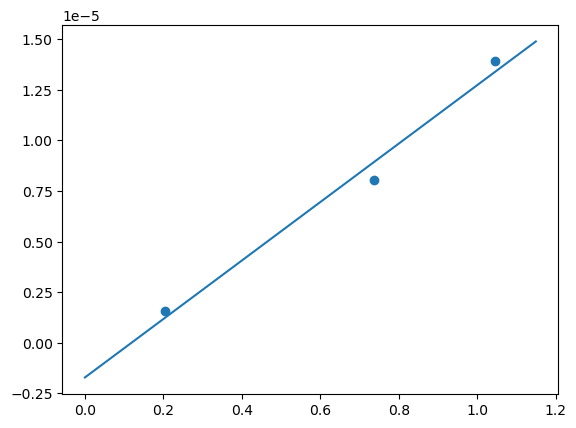

M9 L-alanine PHENYLALANINE 5.8196472337569e-06 7.079157123852594e-07 0.12164237520772564


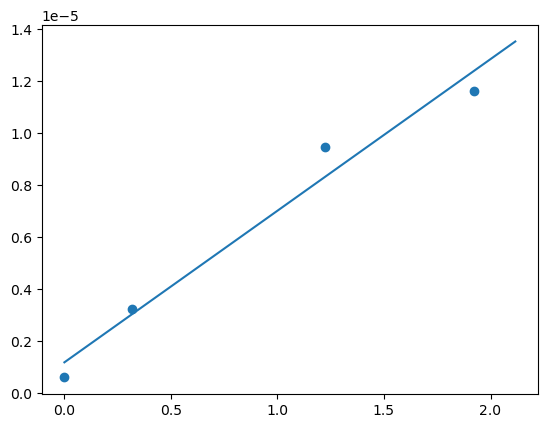

M9 L-alanine LEUCINE 0.00010947460562761029 3.457698580920679e-05 0.3158448081267737


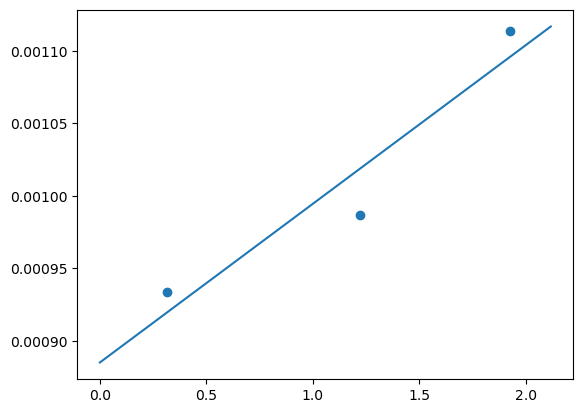

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M9 L-alanine ISOLEUCINE 0.0007341903741088777 inf inf


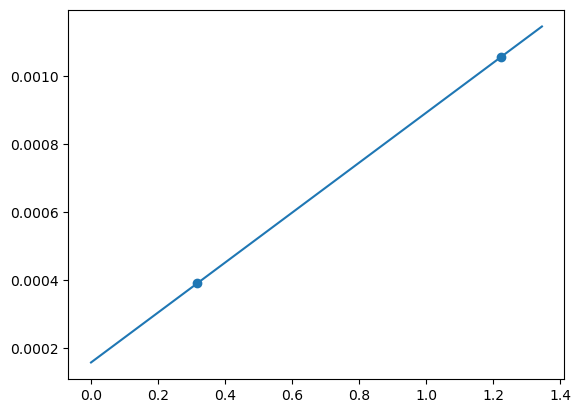

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M9 L-alanine METHIONINE 1.1725140019988843e-05 6.6620258185482795e-06 0.5681830500267765


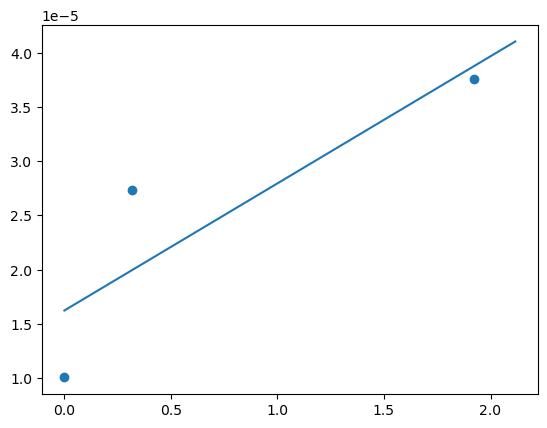

M9 L-alanine GAMMA-AMINOBUTYRATE 0.0074576921296847605 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


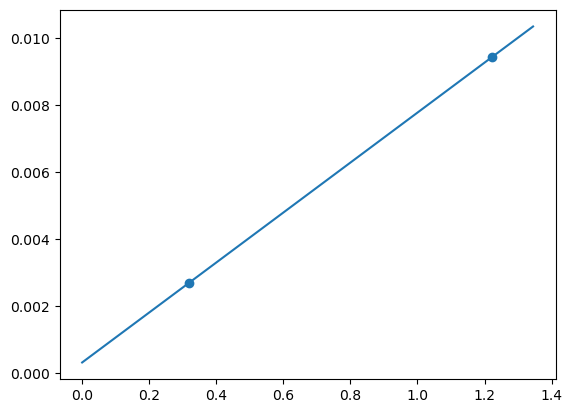

M9 L-alanine PROLINE 0.0003194256370714299 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


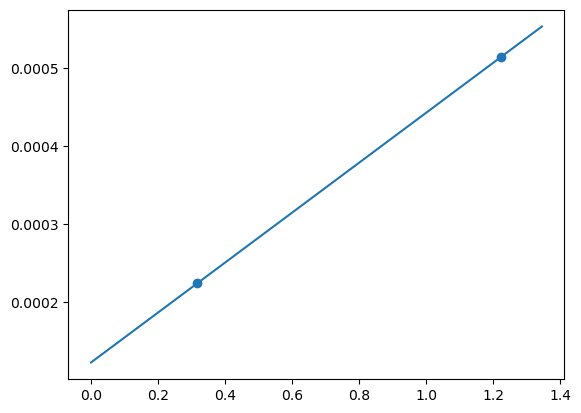

M9 L-alanine VALINE nan nan nan


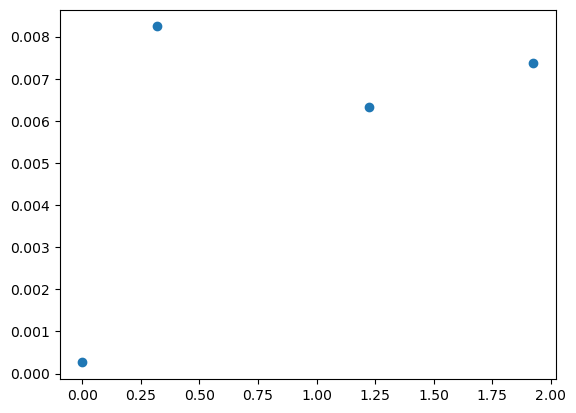

M9 L-alanine PIPECOLIC ACID 1.8187093897110817e-05 1.6494325320695595e-06 0.09069247354199819


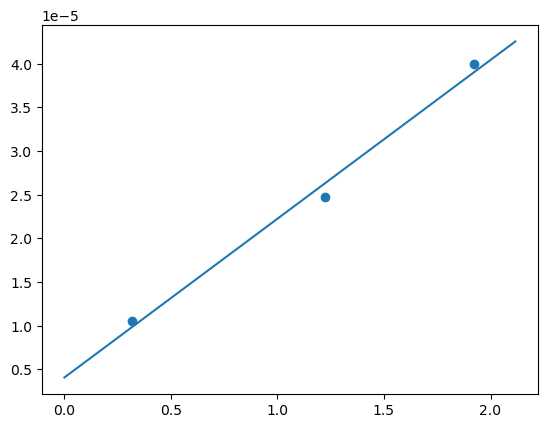

M9 L-alanine ALPHA-AMINOBUTYRATE 0.1719571267155198 0.03845616955457195 0.2236381259044446


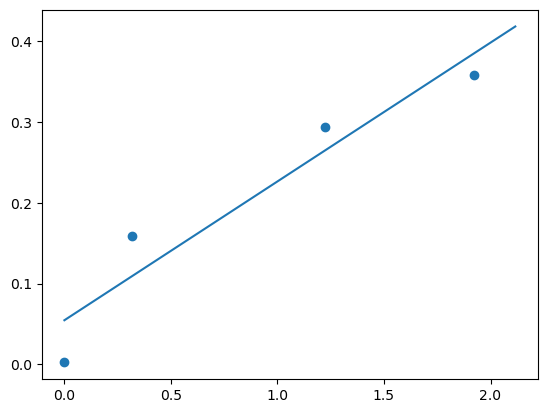

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M9 L-alanine BETA-ALANINE 0.0004918904793149566 inf inf


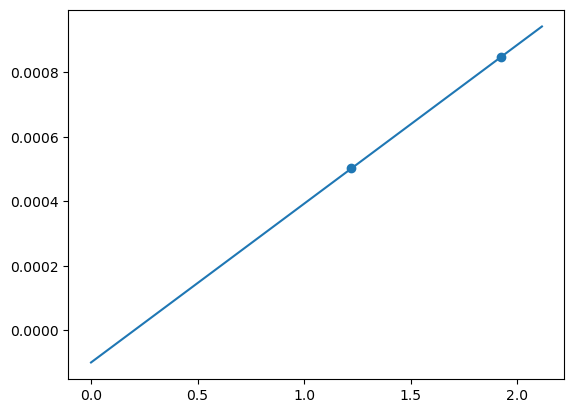

M9 L-alanine ALANINE -18.168015162189253 0.6326850466507209 0.03482411485253748


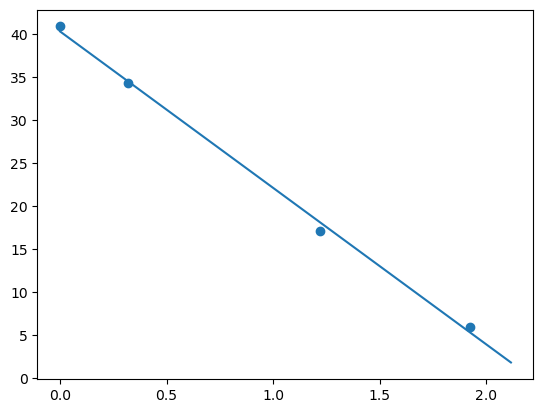

M9 L-alanine CREATINE 1.592377469455866e-06 5.794719050523218e-07 0.36390360713300857


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


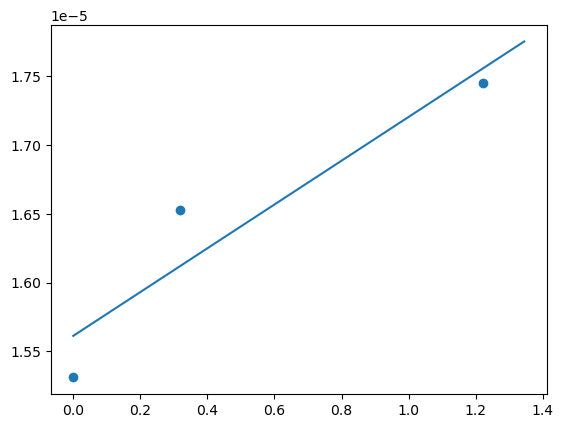

M9 L-alanine ALPHA-AMINOADIPATE 8.512594715389294e-05 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


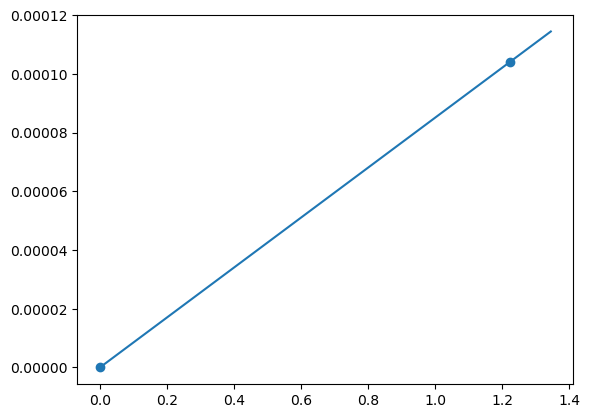

M9 L-alanine GLYCINE 0.03604078722628233 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


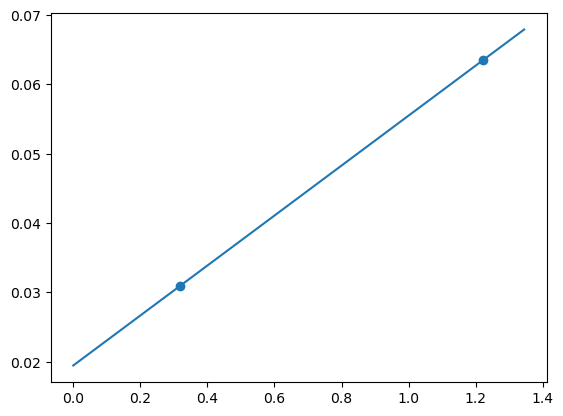

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M9 L-alanine GLUTAMINE 1.970066659188409e-05 inf inf


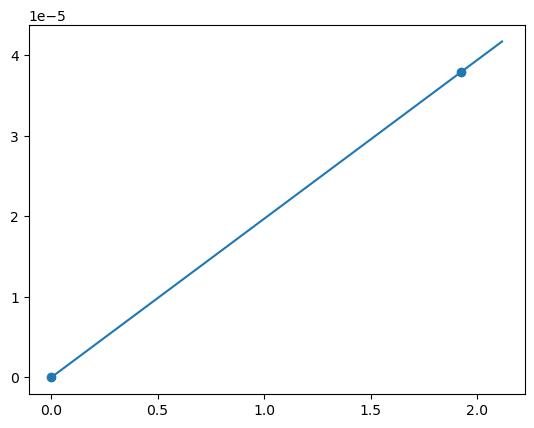

M9 L-alanine GLUTAMATE 0.0006832937572714831 0.0006353684759743083 0.9298613798426182


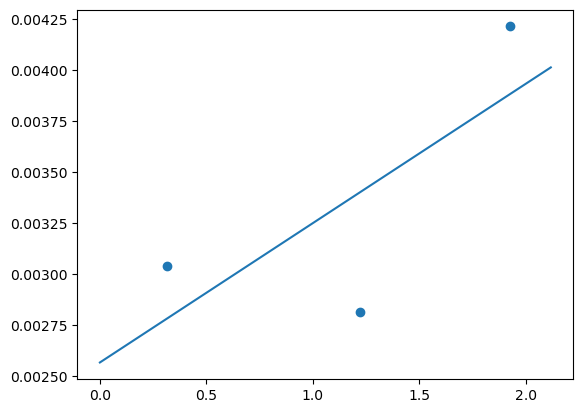

M9 L-alanine SERINE 0.0004755307499626211 0.00018873532983975532 0.3968940596472274


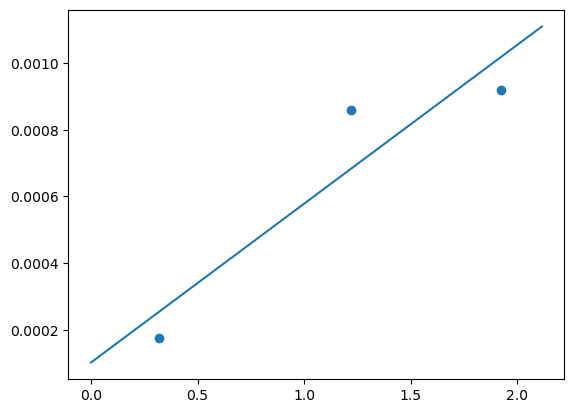

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M9 L-alanine ASPARAGINE 0.006835407493756441 0.0040020436219366205 0.5854872040316754


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M9 L-alanine ASPARTATE 0.0001056854645382066 8.831276273580776e-05 0.8356188159052053


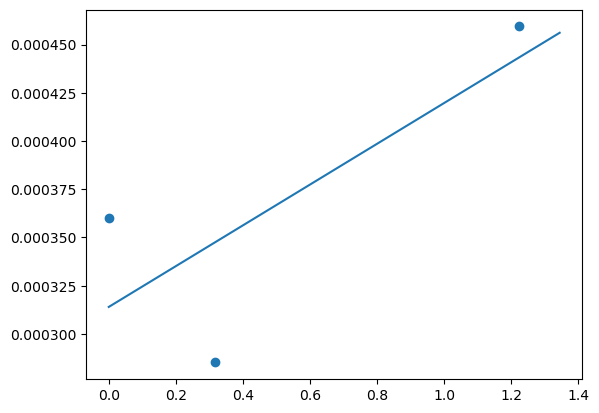

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M9 L-alanine LYSINE -0.0025280444920740665 inf inf


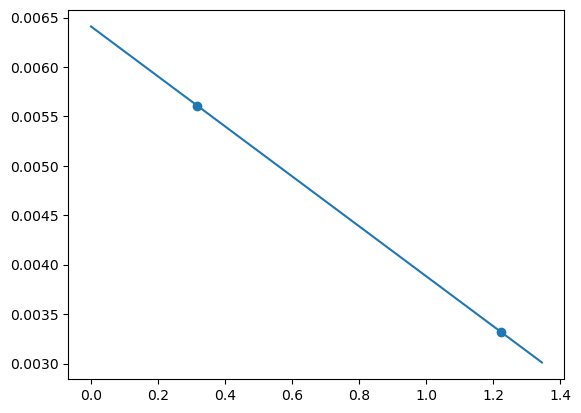

M9 L-alanine PYRUVATE 0.00028991360074292534 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


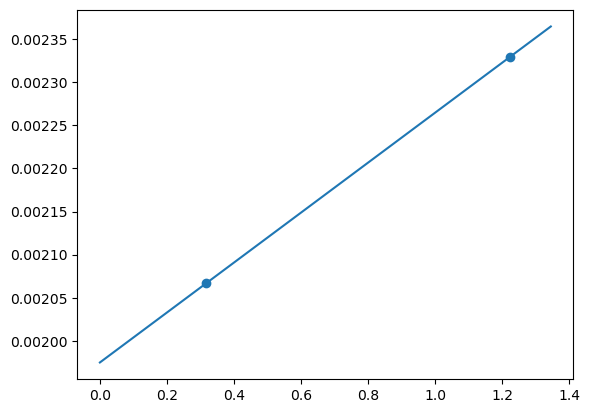

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M9 L-alanine LACTATE 0.0007595078727766375 0.0004032841968043236 0.5309809302304952


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M9 L-alanine NAD 4.699180318104327e-05 inf inf


M9 L-alanine SUCCINATE 0.004833337816248068 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


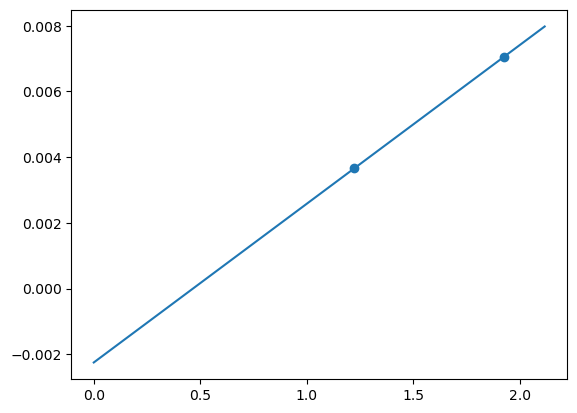

M9 L-alanine MALATE 0.004559756209373442 0.0012286373752181568 0.2694524265776447


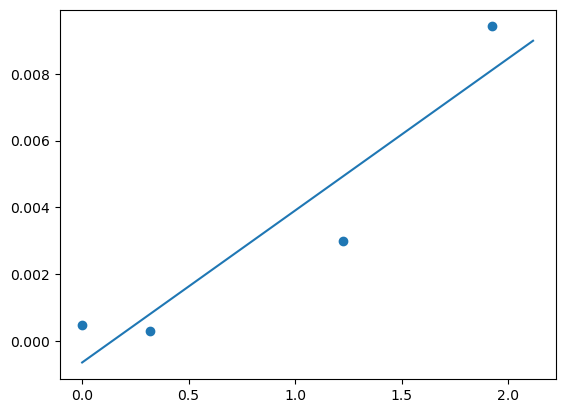

M9 L-alanine CIS-ACONITATE 0.0008775921549794605 0.00031237077395269487 0.35594070910992326


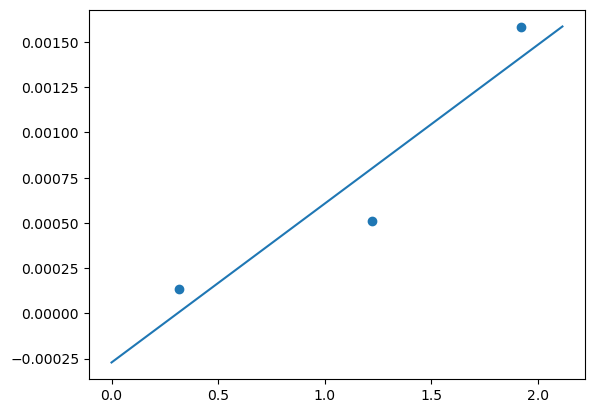

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M9 L-alanine CITRATE 0.006537865131845667 inf inf


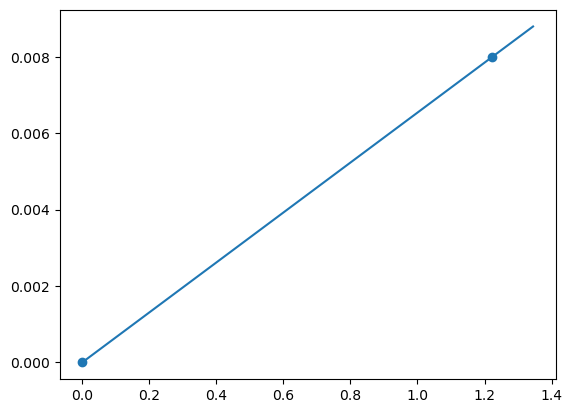

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M9 L-alanine ISOCITRATE 0.000758186677843772 inf inf


M9 L-alanine TRANS-ACONITATE 1.8933395972363713e-05 1.0193662616825765e-05 0.5383958921951999


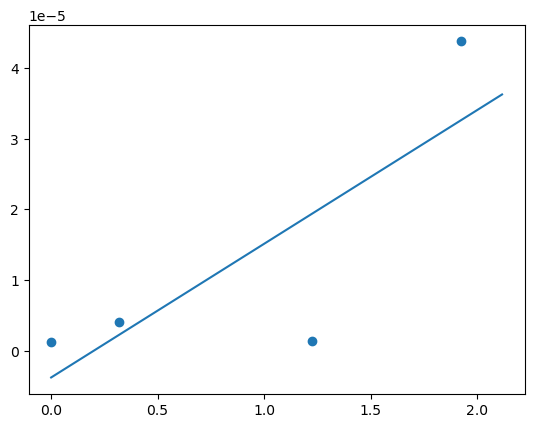

M10 L-alanine PHENYLALANINE 1.7479501306523924e-05 8.661792764398677e-06 0.49554003930111046


M10 L-alanine LEUCINE -0.00012868776883927813 6.771672802778762e-05 0.5262095118951126


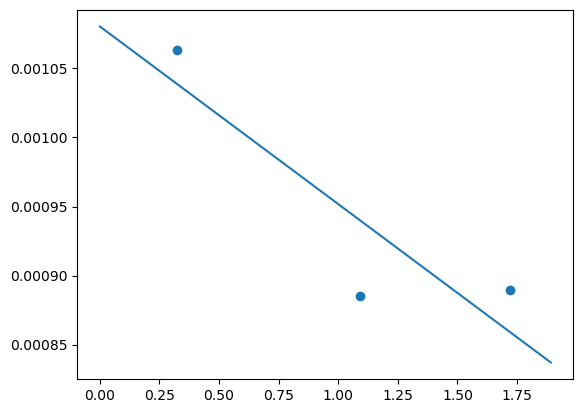

M10 L-alanine ISOLEUCINE 0.00038665472807530073 0.0001437791614240764 0.37185414010009343


M10 L-alanine METHIONINE 1.0813125883979887e-05 1.1598675354796128e-05 1.0726477689471892


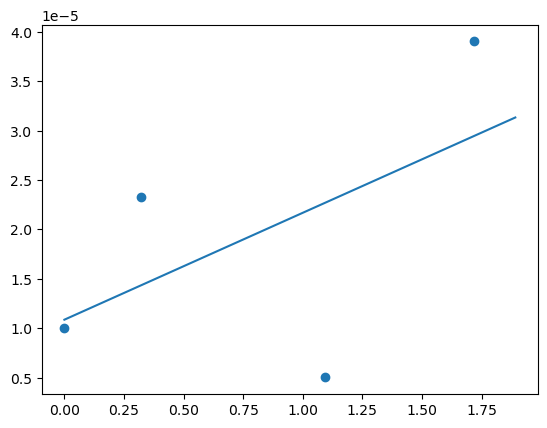

M10 L-alanine GAMMA-AMINOBUTYRATE 0.009531006390694183 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


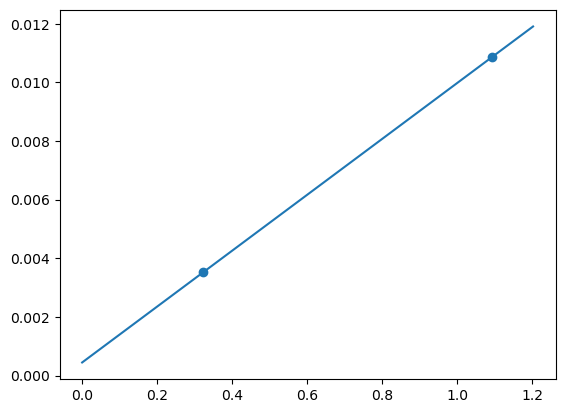

M10 L-alanine PROLINE 6.0014387940051514e-05 4.136748703878566e-05 0.6892928255822207


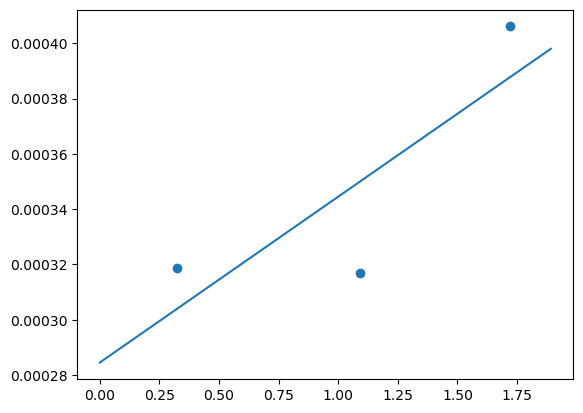

M10 L-alanine TYROSINE 3.673954129679667e-05 2.955733975114967e-05 0.8045103098150761


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


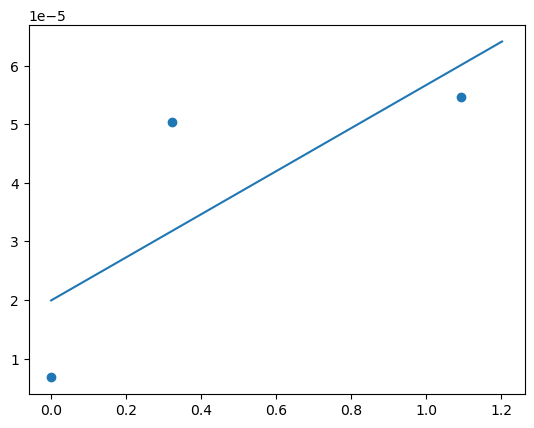

M10 L-alanine VALINE nan nan nan


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


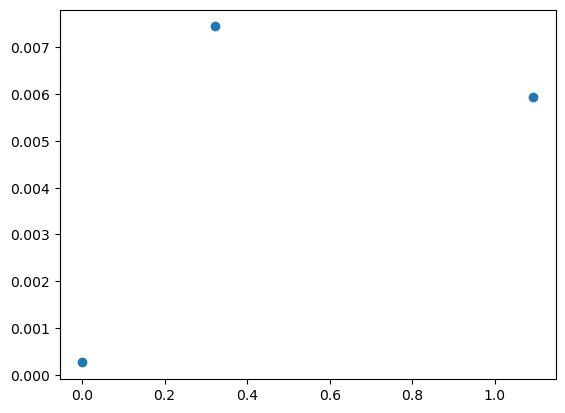

M10 L-alanine PIPECOLIC ACID 1.8128289311095727e-05 5.420145231624592e-06 0.2989882353823149


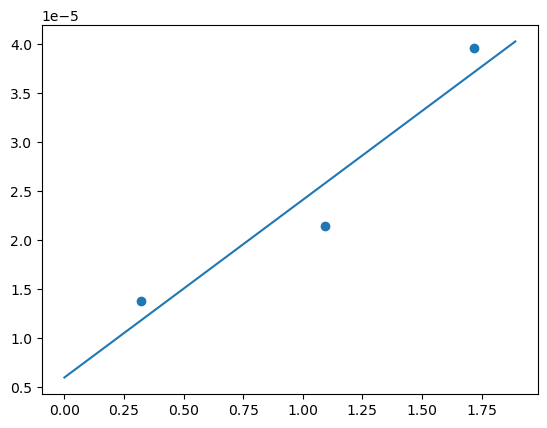

M10 L-alanine ALPHA-AMINOBUTYRATE 0.20163581021377408 0.052249820043603616 0.2591296654508364


M10 L-alanine BETA-ALANINE 0.00048217418602446865 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M10 L-alanine ALANINE -16.639309824036182 1.6568075536503029 0.09957189157310928


M10 L-alanine CREATINE -3.4936314215991926e-06 3.8163662229449195e-06 1.0923780337417497


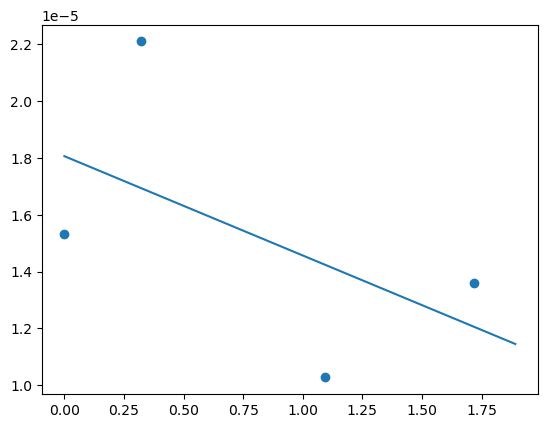

M10 L-alanine ALPHA-AMINOADIPATE 5.6530881268418885e-05 2.6088472236955083e-06 0.046149063399670495


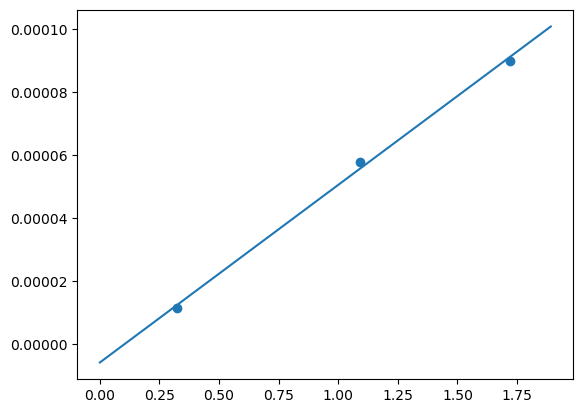

M10 L-alanine GLYCINE 0.030814742825168717 0.013568813535295862 0.44033512180452766


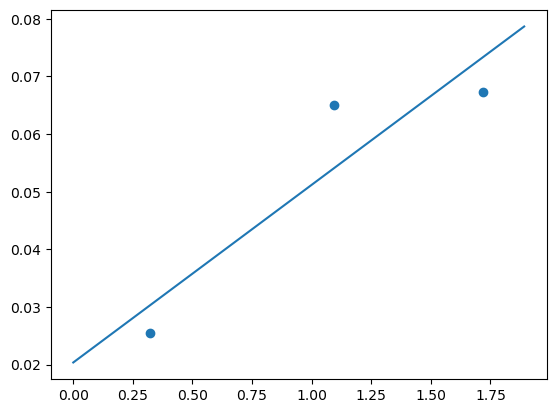

M10 L-alanine GLUTAMINE -4.894624479138556e-05 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


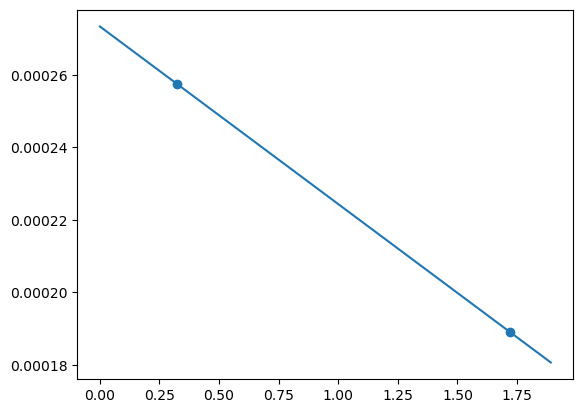

M10 L-alanine GLUTAMATE 0.00045940994314682505 0.0017655833749278692 3.843154466431733


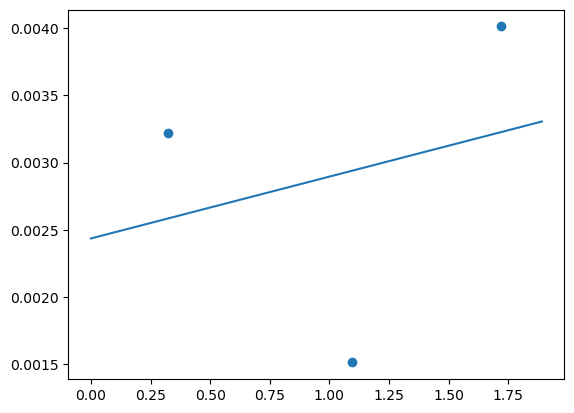

M10 L-alanine SERINE 0.0008263826084400557 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M10 L-alanine ASPARAGINE 0.010156817074436513 0.003245764472246246 0.3195651204958141


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M10 L-alanine ASPARTATE 0.00011327027646842142 0.00011621577888329111 1.0260041955109986


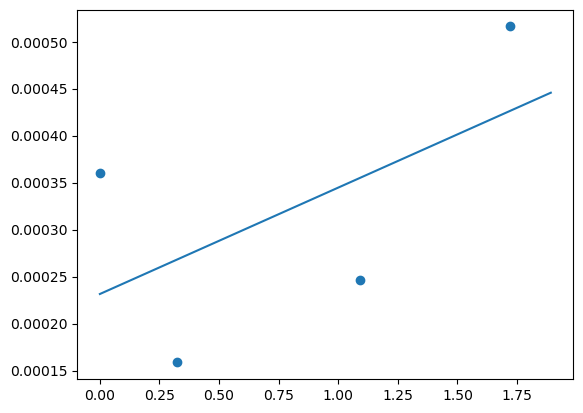

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M10 L-alanine LYSINE -0.001195219578779679 inf inf


M10 L-alanine LACTATE nan nan nan


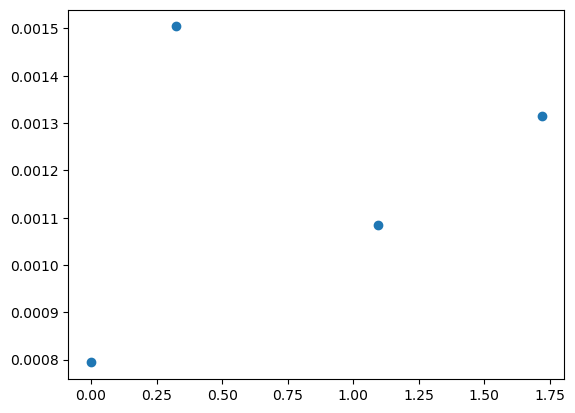

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M10 L-alanine NAD 0.00014471166041709517 inf inf


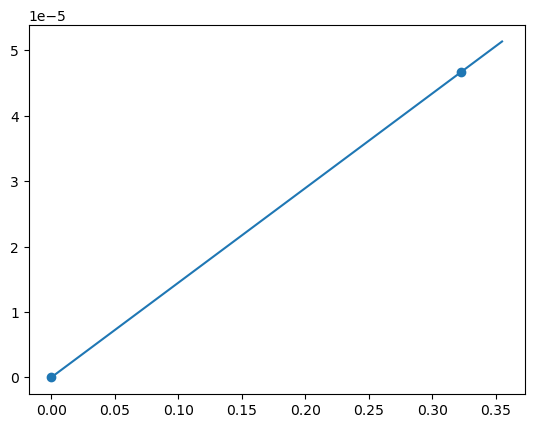

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M10 L-alanine SUCCINATE 0.002300555130084585 inf inf


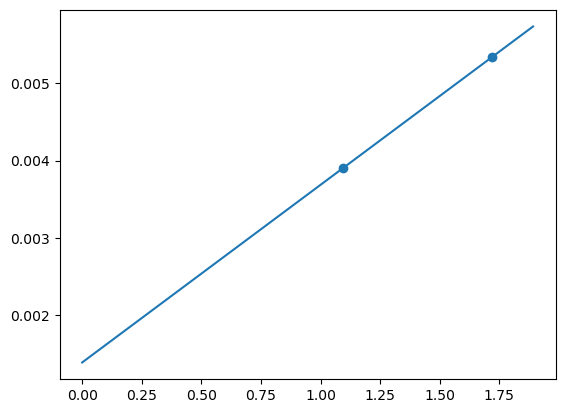

M10 L-alanine MALATE 0.0007063938330401653 0.001031914722798343 1.46082068462745


M10 L-alanine CIS-ACONITATE 0.0010429622174672308 1.7985795031834655e-05 0.01724491523337446


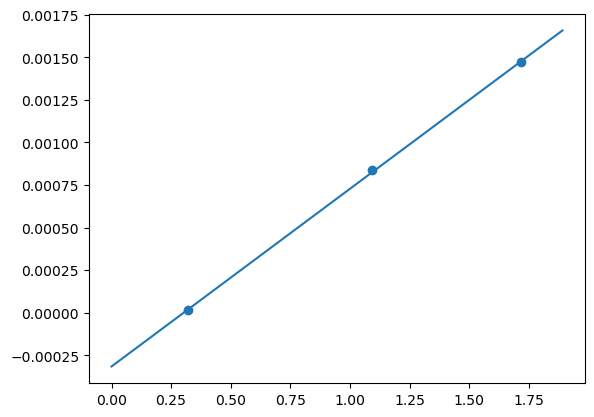

M10 L-alanine CITRATE 0.0025871733717070535 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


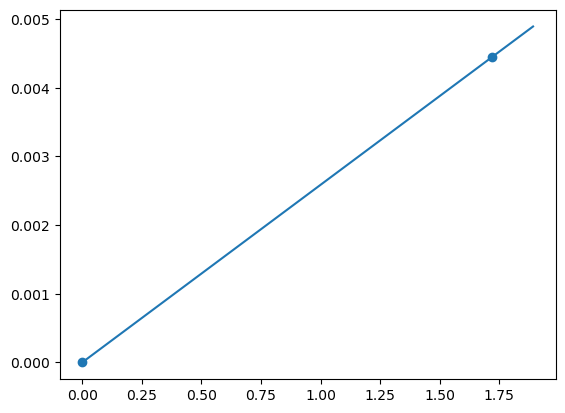

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M10 L-alanine ISOCITRATE 0.0007938732402429235 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M10 L-alanine TRANS-ACONITATE 1.9974503654669845e-05 6.363864066980702e-06 0.31859935931338607


M11 L-alanine PHENYLALANINE 4.97250505859416e-05 3.894886888651497e-06 0.0783284650846121


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M11 L-alanine LEUCINE 0.0002822074471149257 4.020543678613663e-05 0.14246766765783977


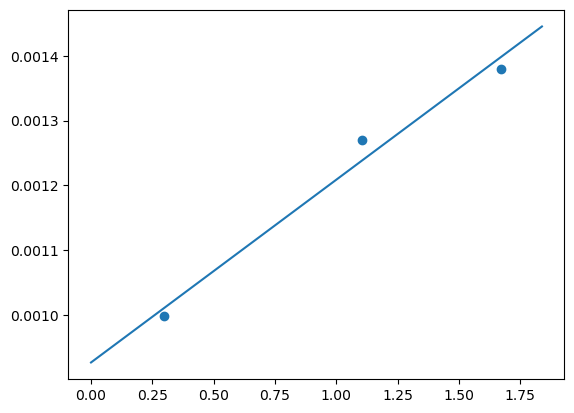

M11 L-alanine ISOLEUCINE 0.0007982162116325203 7.11503125009095e-05 0.08913664175698978


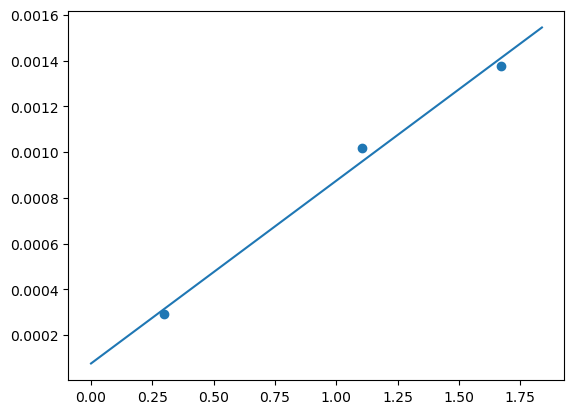

M11 L-alanine METHIONINE 2.7979892678305916e-05 1.5908873499926064e-05 0.5685823631575592


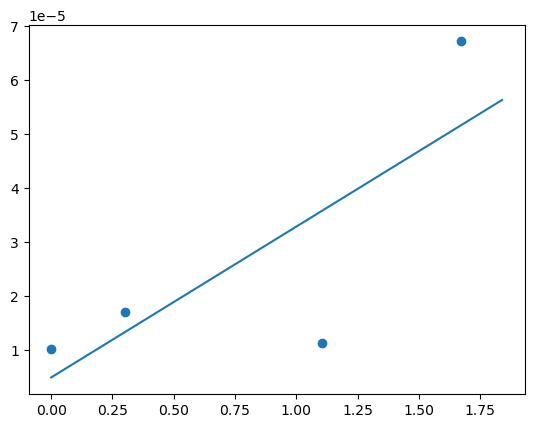

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M11 L-alanine GAMMA-AMINOBUTYRATE 0.007646865449677115 inf inf


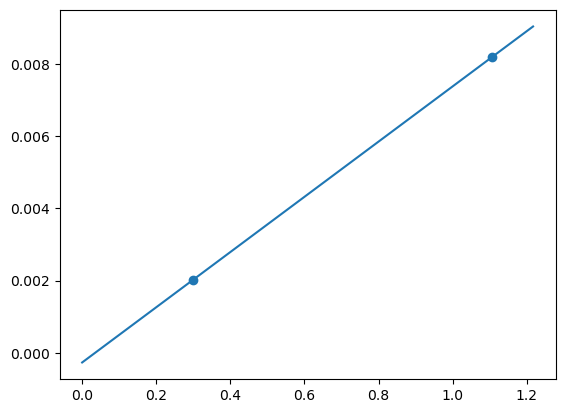

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M11 L-alanine PROLINE 0.0004911292026651017 inf inf


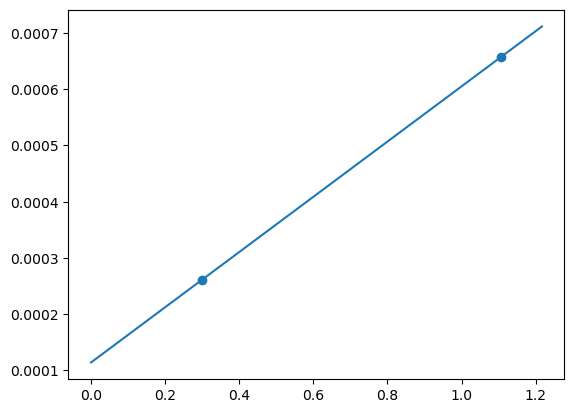

M11 L-alanine TYROSINE 4.3300429043947094e-05 4.0038926326270686e-05 0.9246773579456639


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


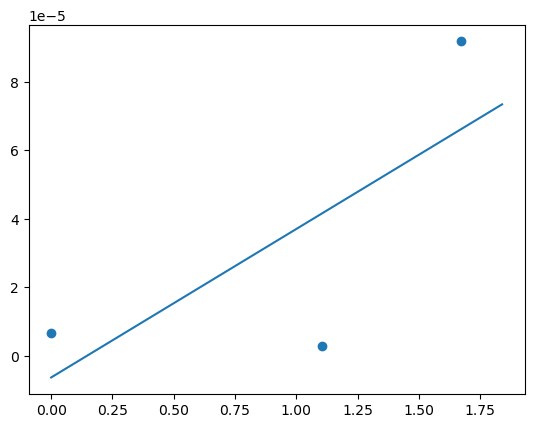

M11 L-alanine VALINE 0.003264534705881975 0.0022273521203103417 0.6822877748235122


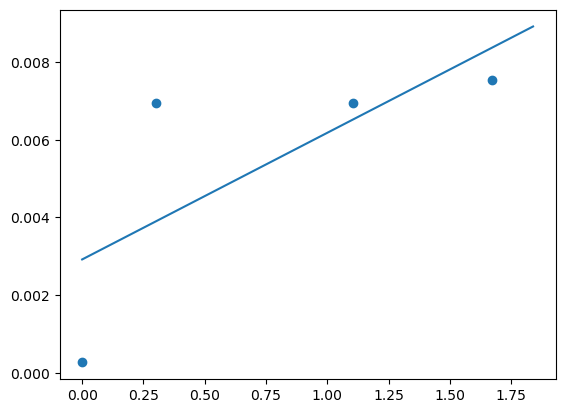

M11 L-alanine PIPECOLIC ACID 2.2854179522711623e-05 4.234775028743128e-06 0.1852954302968859


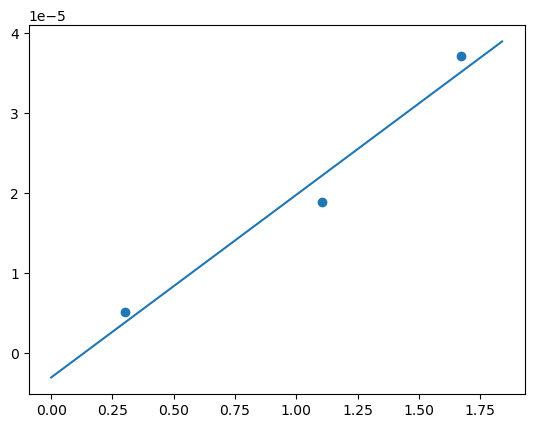

M11 L-alanine ALPHA-AMINOBUTYRATE 0.20592673503549394 0.03807781197677082 0.18490951148333243


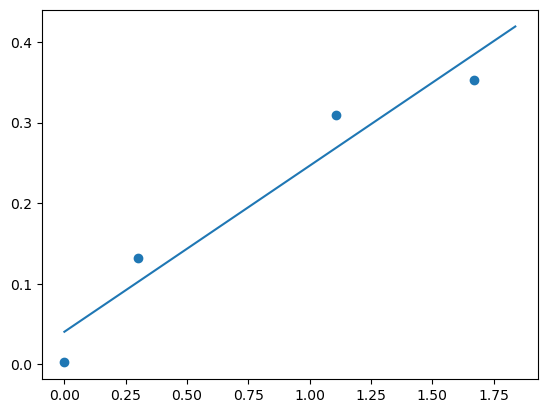

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M11 L-alanine BETA-ALANINE 0.0005174411227287427 inf inf


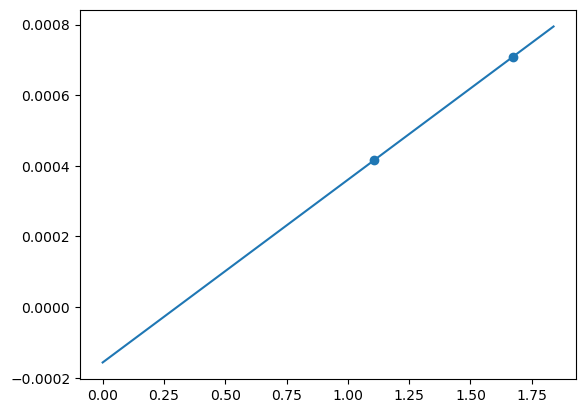

M11 L-alanine ALANINE -17.39651841177265 1.2620925914100807 0.07254857331430131


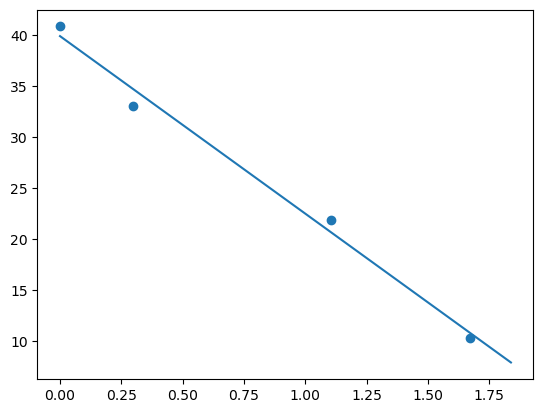

M11 L-alanine CREATINE -4.065179107172861e-06 9.321284150707703e-07 0.2292957802095518


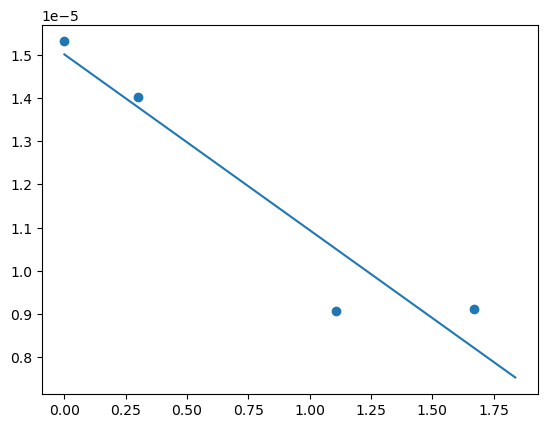

M11 L-alanine ALPHA-AMINOADIPATE 5.8551777423686356e-05 1.7680702313832016e-05 0.30196696141079943


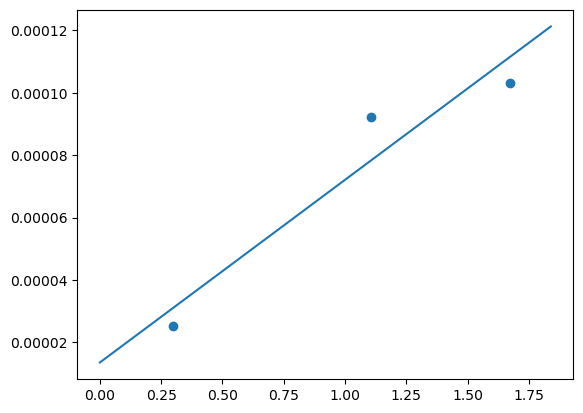

M11 L-alanine GLYCINE 0.02274957526985665 0.006108673745018848 0.2685181447370969


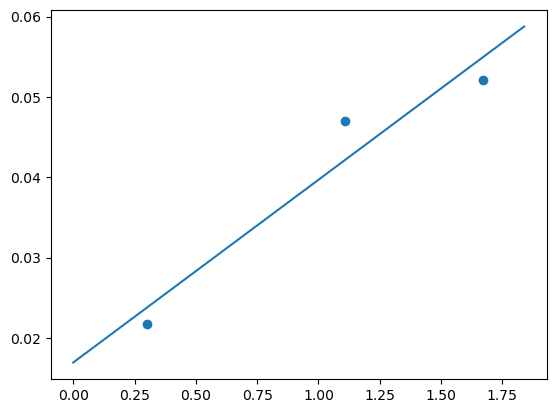

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M11 L-alanine GLUTAMINE 2.0714779543147334e-05 inf inf


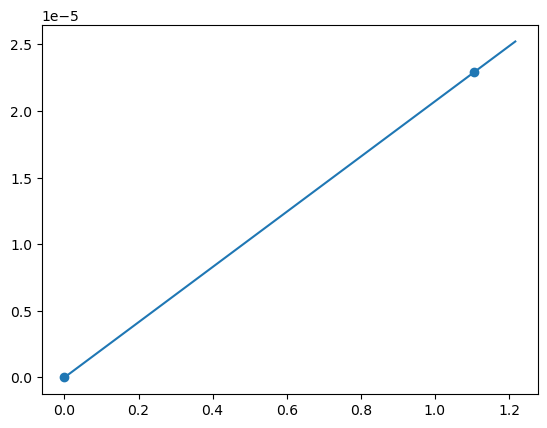

M11 L-alanine GLUTAMATE 0.0025636172523222814 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


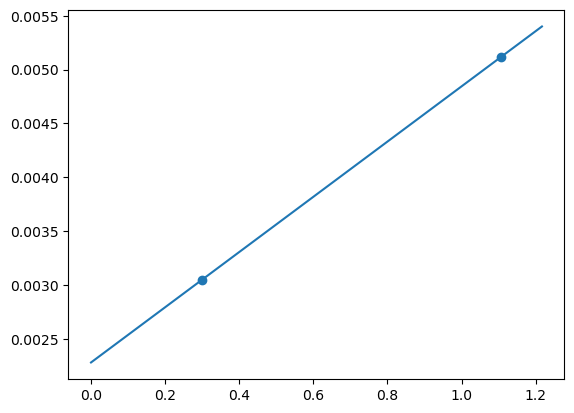

M11 L-alanine SERINE 0.001053691911872216 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


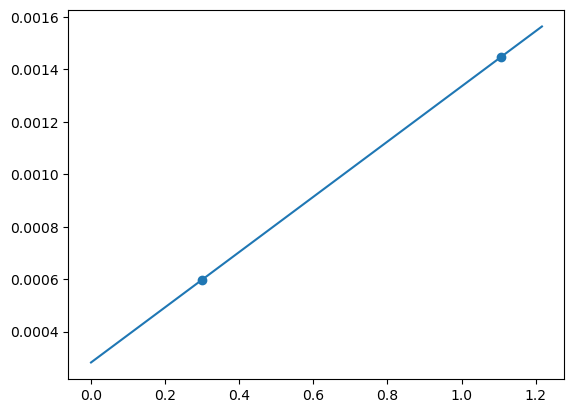

M11 L-alanine ASPARAGINE 0.005748535302184615 0.004845792442969069 0.8429612393834519


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


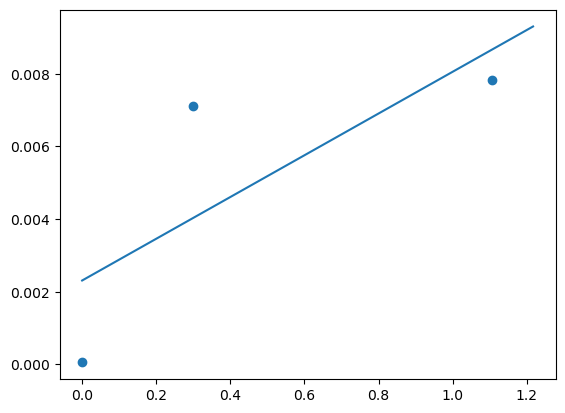

M11 L-alanine ASPARTATE nan nan nan


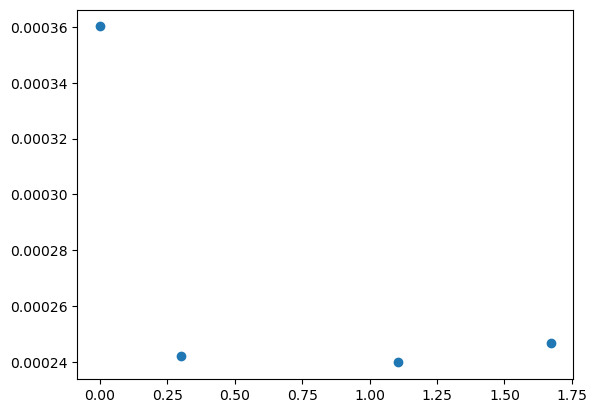

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M11 L-alanine LYSINE 0.0010635562561171939 inf inf


M11 L-alanine LACTATE nan nan nan


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M11 L-alanine HEXOSES including Glucose and Fructose 0.007639901303110796 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M11 L-alanine NAD 5.6596531725683684e-05 inf inf


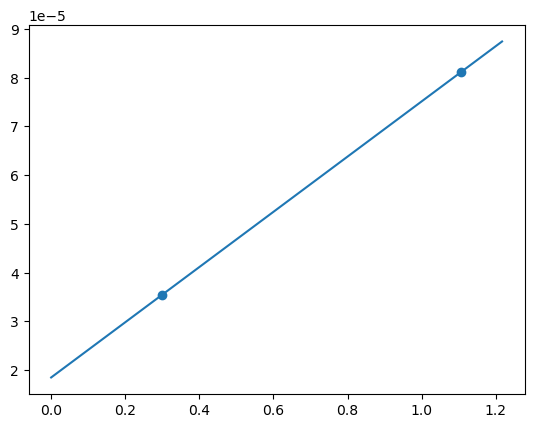

M11 L-alanine SUCCINATE 0.018093275079308326 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


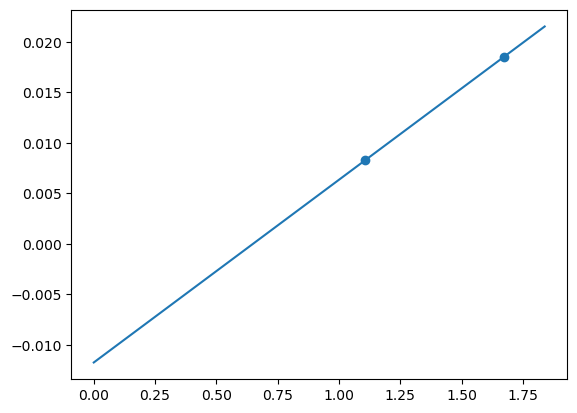

M11 L-alanine MALATE 0.003237204948929908 0.001557671759555986 0.48117798660566447


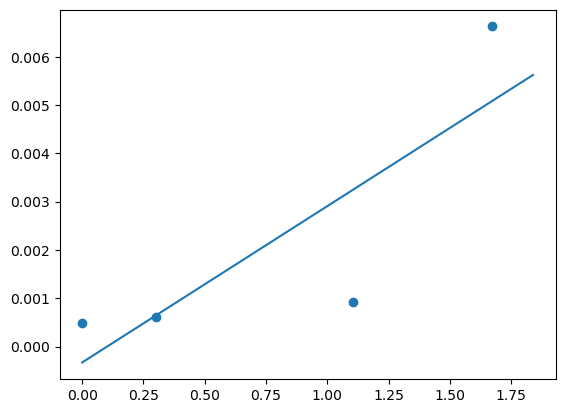

M11 L-alanine CIS-ACONITATE 0.0009061021231321637 7.191892762294502e-05 0.0793717681339711


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M11 L-alanine CITRATE 0.004102616186415924 inf inf


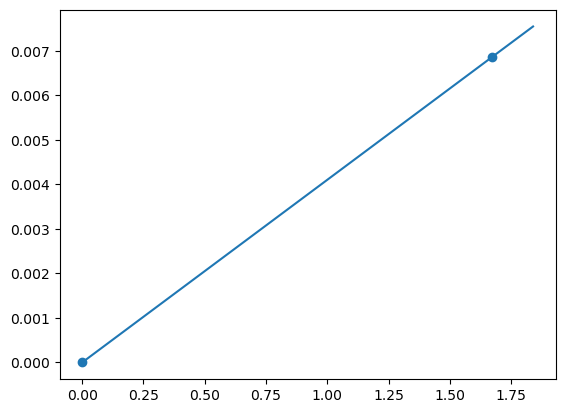

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M11 L-alanine ISOCITRATE 0.0006478947178522423 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M11 L-alanine TRANS-ACONITATE 1.8823455110741705e-05 4.462361121896711e-06 0.2370638703491922


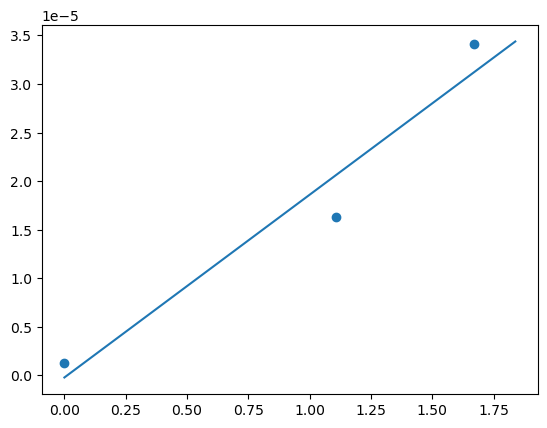

In [354]:
data = []
plot = True
data_rate = []

for m in dfl.M.unique():
    for met in dfl.Metabolite.unique():
        
        idx = (dfl.M == m) & (dfl.Metabolite == met) & (dfl.Timepoint != 4) & ~control_idx_l
        dfi = dfl.loc[idx,['Concentration [uM]', 'Hours', 'Carbon source', 'Timepoint']].copy()
        dfi.sort_values('Hours', inplace=True)
        # print(m, met)
        # print(dfi)
        dfi.dropna(axis = 0, inplace=True)
    
        if not len(dfi):
            continue
        cs = dfi['Carbon source'].values[0]  

        
        if met not in ['MALATE', 'ALANINE', 'HEXOSES including Glucose and Fructose']:
            if (2 in dfi.Timepoint.values) and (3 in dfi.Timepoint.values):
                t3_value = dfi.loc[dfi.Timepoint == 3, 'Concentration [uM]'].values[0]
                t2_value = dfi.loc[dfi.Timepoint == 2, 'Concentration [uM]'].values[0]
                if  t3_value < t2_value:
                    # Indicates that the matbolite is being reconsumed, discard last point from estimating rates
                    dfi = dfi.loc[dfi.Timepoint != 3, :]

        # Add medium concentrations
        # 
        medium_values = control_df.loc[control_df['Carbon source']==cs, met].values
        if np.isfinite(medium_values).sum() > 0:
            dfi.loc[-1,:] = [np.nanmean(medium_values), 0, cs, 0]
        elif (np.isfinite(medium_values).sum() == 0) and (len(dfi) == 1):
            dfi.loc[-1,:] = [0, 0, cs, 0]
        else:
            pass
            
        time_conc_dict = {key: (value['Hours'], value['Concentration [uM]']) for key, value in dfi[['Hours', 'Concentration [uM]']].to_dict(orient = 'index').items()}
        rel = M_to_rel[m]
        gdw = gdw_df[['Hours', rel]].copy()
        gdw.dropna(inplace=True)
        m_data = []
        for index, val_tuple in time_conc_dict.items():
            time, conc = val_tuple
            # Calculate cumulative OD
            tidx = gdw.Hours < time+0.5
            conc_mM = conc * 1e-3
            if time == 0:
                int_gdw = 0
            else:
                int_gdw = int_gdw_dict[(rel, time)]
            # cum_dw = scipy.integrate.simpson(gdw.loc[tidx, rel], gdw.loc[tidx, 'Hours'])
            data.append([m, met, time, conc_mM, int_gdw, cs])
            m_data.append([time, conc_mM, int_gdw])

        m_df = pd.DataFrame(m_data, columns = ['Time', 'Concentration [mM]', 'Integral of biomass [gDW*h/L]'])
        # linregress and curve fit gives exact same results
        # res = scipy.stats.linregress(m_df['Integral of biomass [gDW*h/L]'], 
        #                                       m_df['Concentration [mM]'])
        popt, pcov = scipy.optimize.curve_fit(lambda x,a,b: a*x+b, m_df['Integral of biomass [gDW*h/L]'], 
                                              m_df['Concentration [mM]'])
        # print(res, popt)
        rate = popt[0]
        rate_std = np.sqrt(pcov[0,0])

        # Check rate without t0
        if len(m_df)>2:
            idx0 = m_df.Time == 0 
            popt0, pcov0 = scipy.optimize.curve_fit(lambda x,a,b: a*x+b, m_df.loc[~idx0, 'Integral of biomass [gDW*h/L]'], 
                                              m_df.loc[~idx0, 'Concentration [mM]'])
            if np.sign(rate)!= np.sign(popt0[0]):
                rate, rate_std = np.nan, np.nan
        data_rate.append([m, met, cs, rate, rate_std])
        if plot:
            print(m, cs, met, rate, rate_std, rate_std/np.abs(rate) )
            max_x = m_df['Integral of biomass [gDW*h/L]'].max()*1.1
            plt.scatter(m_df['Integral of biomass [gDW*h/L]'], m_df['Concentration [mM]'])
            x = np.linspace(0,max_x, 4)
            plt.plot(x, rate*x + popt[1])
            plt.show()
df_conc_biomass = pd.DataFrame(data, columns = ['M', 'Metabolite', 'Time', 'Concentration [mM]', 'Integral of biomass [gDW*h/L]', 'Carbon source'])
df_rate = pd.DataFrame(data_rate, columns = ['M', 'Metabolite', 'Carbon source', 'Rate [mmol/gDW/h]', 'Std.Err [mmol/gDW/h]'])

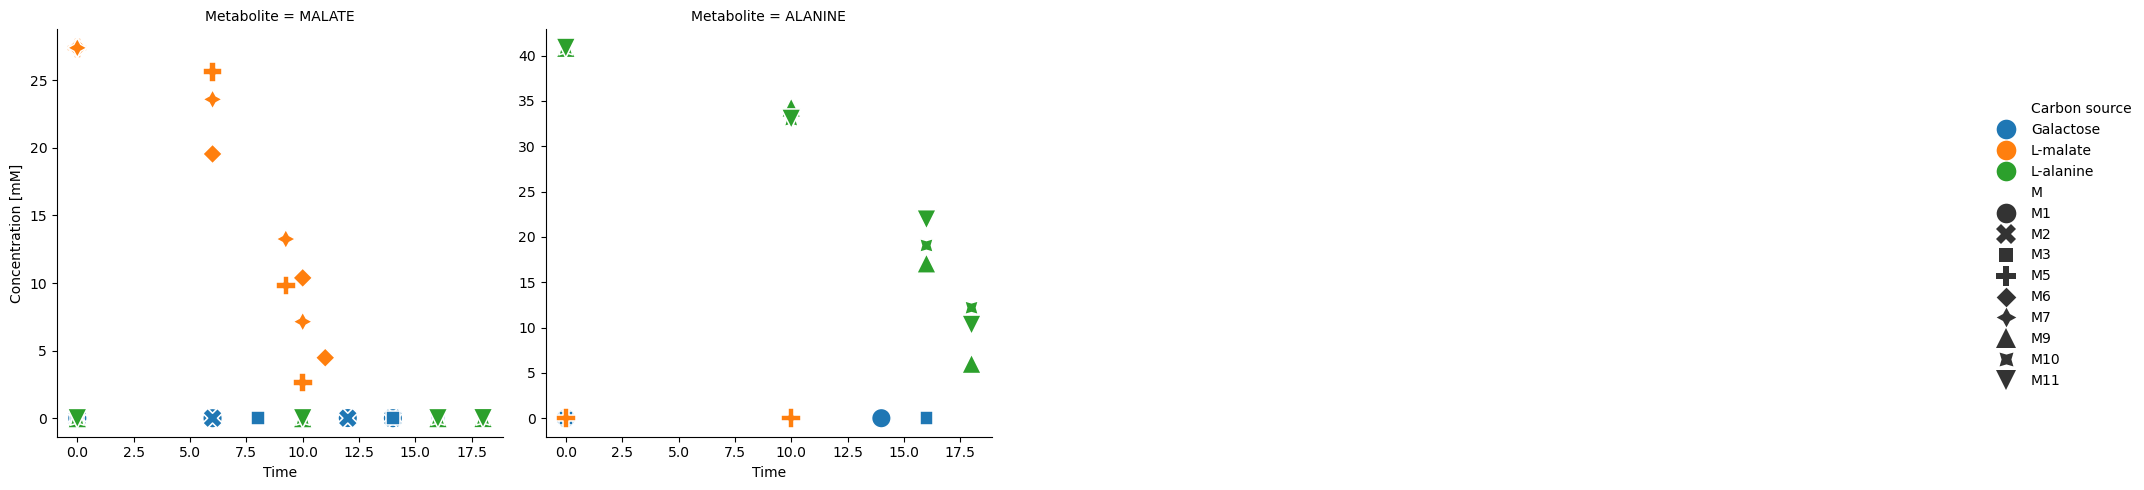

In [159]:
sns.relplot(data = df_conc_biomass, x = 'Time', y = 'Concentration [mM]', col = 'Metabolite', col_wrap=4, facet_kws={'sharey': False}, style = 'M',  hue = 'Carbon source', s = 200,
           col_order = ['MALATE', 'ALANINE'])

plt.show()

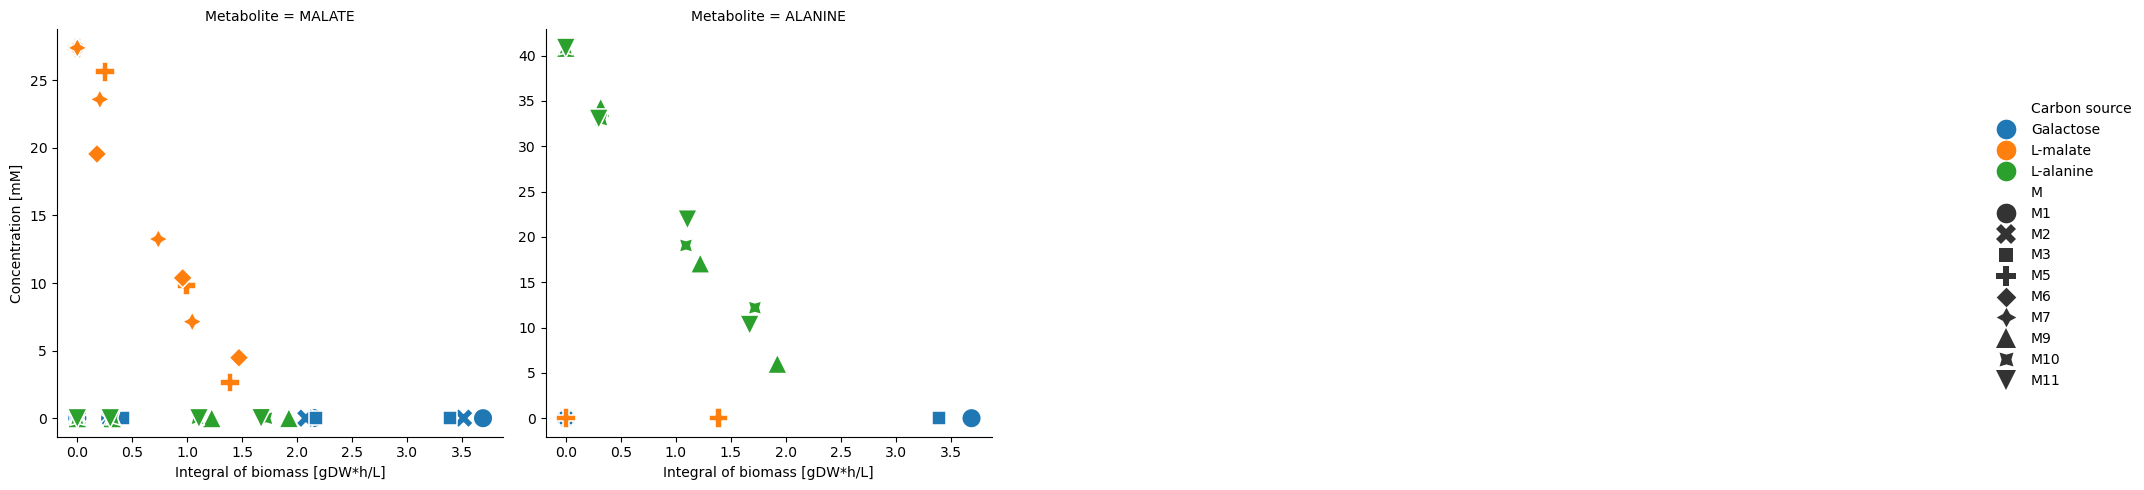

In [161]:
sns.relplot(data = df_conc_biomass, x = 'Integral of biomass [gDW*h/L]', y = 'Concentration [mM]', col = 'Metabolite', col_wrap=4, facet_kws={'sharey': False}, style = 'M',  hue = 'Carbon source', s = 200,
           col_order = ['MALATE', 'ALANINE'])

plt.show()

In [187]:
df_conc_biomass.loc[(df_conc_biomass.M=='M7')&(df_conc_biomass.Metabolite=='MALATE')]

M Metabolite   Time  Concentration [mM]  Integral of biomass [gDW*h/L]  \
345  M7     MALATE   6.00           23.585690                       0.205147   
346  M7     MALATE   9.25           13.253961                       0.736543   
347  M7     MALATE  10.00            7.139692                       1.045022   
348  M7     MALATE   0.00           27.395490                       0.000000   

    Carbon source  
345      L-malate  
346      L-malate  
347      L-malate  
348      L-malate

# Estimate rate per carbon source

In [217]:
df_conc_biomass.loc[df_conc_biomass['Time']==0]

M                              Metabolite  Time  Concentration [mM]  \
3     M1                           PHENYLALANINE   0.0            0.000005   
8     M1                              ISOLEUCINE   0.0            0.000132   
10    M1                              METHIONINE   0.0            0.000004   
12    M1                     GAMMA-AMINOBUTYRATE   0.0            0.000028   
14    M1                                 PROLINE   0.0            0.000020   
..   ...                                     ...   ...                 ...   
579  M11                                 LACTATE   0.0            0.000794   
581  M11  HEXOSES including Glucose and Fructose   0.0            0.000000   
589  M11                                  MALATE   0.0            0.000478   
594  M11                                 CITRATE   0.0            0.000000   
599  M11                         TRANS-ACONITATE   0.0            0.000001   

     Integral of biomass [gDW*h/L] Carbon source  
3                              0.0     Galactose  
8                              0.0     Galactose  
10                             0.0     Galactose  
12                             0.0     Galactose  
14                             0.0     Galactose  
..                             ...           ...  
579                            0.0     L-alanine  
581                            0.0     L-alanine  
589                            0.0     L-alanine  
594                            0.0     L-alanine  
599                            0.0     L-alanine  

[127 rows x 6 columns]

In [162]:
df_conc_biomass.loc[df_conc_biomass['Metabolite']=='TRANS-ACONITATE']

M       Metabolite   Time  Concentration [mM]  \
64    M1  TRANS-ACONITATE  12.00            0.000011   
65    M1  TRANS-ACONITATE  14.00            0.000024   
122   M2  TRANS-ACONITATE   6.00            0.000001   
123   M2  TRANS-ACONITATE  12.00            0.000008   
124   M2  TRANS-ACONITATE  14.00            0.000019   
185   M3  TRANS-ACONITATE   8.00            0.000002   
186   M3  TRANS-ACONITATE  14.00            0.000011   
187   M3  TRANS-ACONITATE  16.00            0.000014   
245   M5  TRANS-ACONITATE   9.25            0.000013   
246   M5  TRANS-ACONITATE  10.00            0.000013   
302   M6  TRANS-ACONITATE  10.00            0.000009   
303   M6  TRANS-ACONITATE  11.00            0.000020   
356   M7  TRANS-ACONITATE   6.00            0.000002   
357   M7  TRANS-ACONITATE   9.25            0.000008   
358   M7  TRANS-ACONITATE  10.00            0.000014   
435   M9  TRANS-ACONITATE  10.00            0.000004   
436   M9  TRANS-ACONITATE  16.00            0.000001   
437   M9  TRANS-ACONITATE  18.00            0.000044   
438   M9  TRANS-ACONITATE   0.00            0.000001   
522  M10  TRANS-ACONITATE  16.00            0.000014   
523  M10  TRANS-ACONITATE  18.00            0.000037   
524  M10  TRANS-ACONITATE   0.00            0.000001   
608  M11  TRANS-ACONITATE  16.00            0.000016   
609  M11  TRANS-ACONITATE  18.00            0.000034   
610  M11  TRANS-ACONITATE   0.00            0.000001   

     Integral of biomass [gDW*h/L] Carbon source  
64                        2.146725     Galactose  
65                        3.689350     Galactose  
122                       0.301350     Galactose  
123                       2.078183     Galactose  
124                       3.512017     Galactose  
185                       0.416500     Galactose  
186                       2.174317     Galactose  
187                       3.391500     Galactose  
245                       0.993477      L-malate  
246                       1.389422      L-malate  
302                       0.958160      L-malate  
303                       1.470093      L-malate  
356                       0.205147      L-malate  
357                       0.736543      L-malate  
358                       1.045022      L-malate  
435                       0.317300     L-alanine  
436                       1.222425     L-alanine  
437                       1.923925     L-alanine  
438                       0.000000     L-alanine  
522                       1.092825     L-alanine  
523                       1.719425     L-alanine  
524                       0.000000     L-alanine  
608                       1.106175     L-alanine  
609                       1.671675     L-alanine  
610                       0.000000     L-alanine

Galactose PHENYLALANINE
LinregressResult(slope=1.451446095546391e-05, intercept=-1.6068073447364451e-07, rvalue=0.856674607415512, pvalue=0.003180880828587474, stderr=3.3034327205771925e-06, intercept_stderr=6.864074746520524e-06) [ 1.45144606e-05 -1.60679582e-07] [3.30343214e-06 6.86407455e-06]


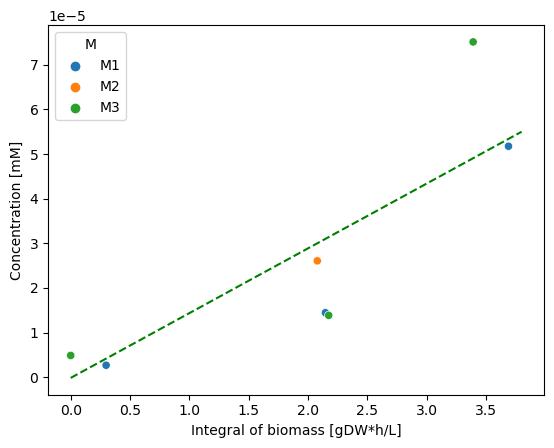

Galactose LEUCINE
LinregressResult(slope=0.00014042928729421383, intercept=-3.7559333570358995e-05, rvalue=0.9147547697671374, pvalue=0.010590396058580101, stderr=3.101091905723447e-05, intercept_stderr=6.631758673936697e-05) [ 1.40429287e-04 -3.75593326e-05] [3.10109182e-05 6.63175864e-05]


Galactose ISOLEUCINE
LinregressResult(slope=-1.5099023335387654e-05, intercept=0.00012641177855717152, rvalue=-0.8981417487191642, pvalue=0.002444256132330323, stderr=3.0178022318312674e-06, intercept_stderr=6.319497456345656e-06) [-1.50990233e-05  1.26411779e-04] [3.01780220e-06 6.31949744e-06]


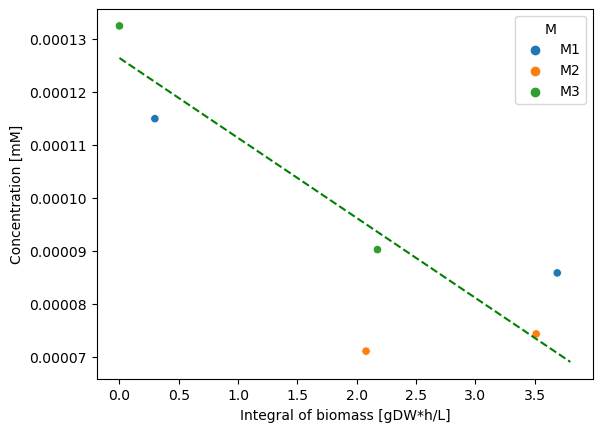

Galactose METHIONINE
LinregressResult(slope=3.584394337381932e-06, intercept=4.693650502790327e-06, rvalue=0.5839297077239436, pvalue=0.22365783433847625, stderr=2.4915896737216506e-06, intercept_stderr=4.841832811416421e-06) [3.58439439e-06 4.69365039e-06] [2.49158963e-06 4.84183280e-06]


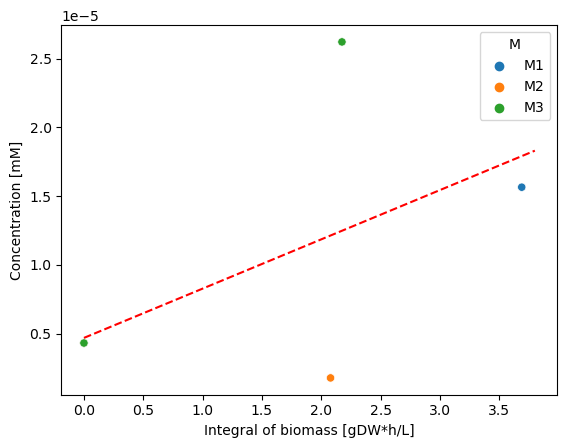

Galactose GAMMA-AMINOBUTYRATE
LinregressResult(slope=4.480467323230491e-05, intercept=0.00018128913153167689, rvalue=0.3221715113078304, pvalue=0.48100153557583925, stderr=5.887826234923703e-05, intercept_stderr=0.00010905861728975605) [4.48046730e-05 1.81289132e-04] [5.88782619e-05 1.09058617e-04]


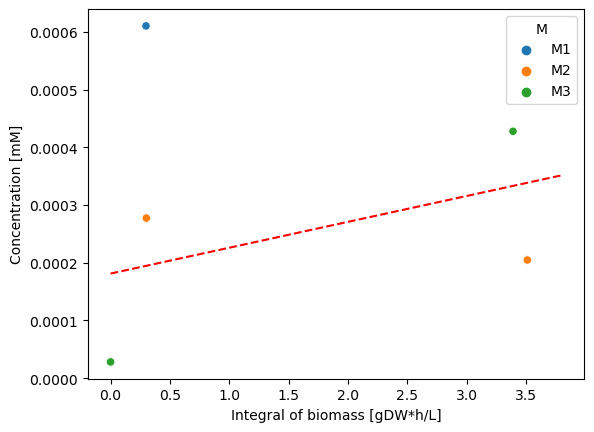

Galactose PROLINE
LinregressResult(slope=1.9838938783657338e-07, intercept=1.946689837272772e-05, rvalue=0.01825226161428036, pvalue=0.9726246479039203, stderr=5.433746870770284e-06, intercept_stderr=8.197255499808791e-06) [1.98390684e-07 1.94668970e-05] [5.43374645e-06 8.19725546e-06]


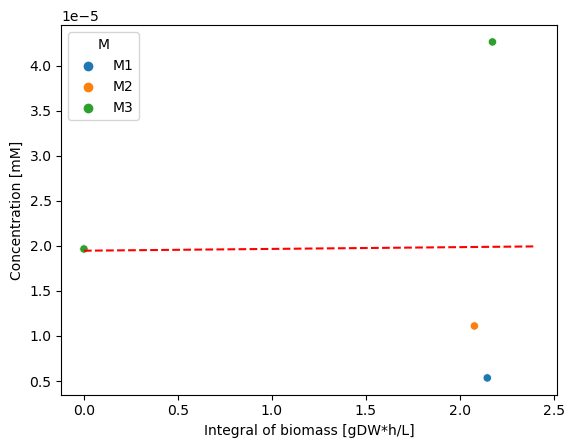

Galactose VALINE
LinregressResult(slope=9.452512187163125e-06, intercept=1.929792826637844e-05, rvalue=0.6546745033382336, pvalue=0.3453254966617665, stderr=7.717514084851285e-06, intercept_stderr=1.9404233895594132e-05) [9.45251218e-06 1.92979283e-05] [7.7175141e-06 1.9404234e-05]


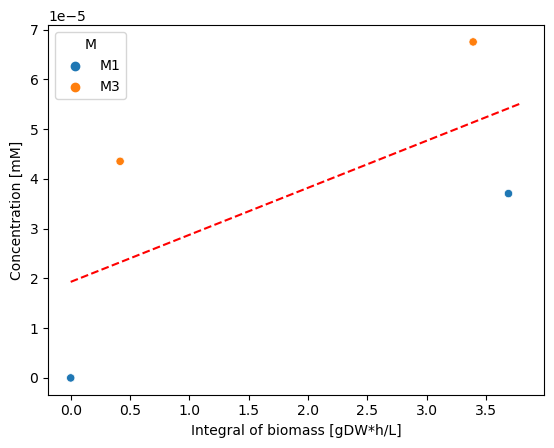

Galactose PIPECOLIC ACID
LinregressResult(slope=6.0366874488712966e-06, intercept=5.068650334445317e-06, rvalue=0.9057090079885387, pvalue=0.001950387237661398, stderr=1.1534473462964224e-06, intercept_stderr=2.5057878564636372e-06) [6.03668743e-06 5.06865037e-06] [1.15344735e-06 2.50578785e-06]


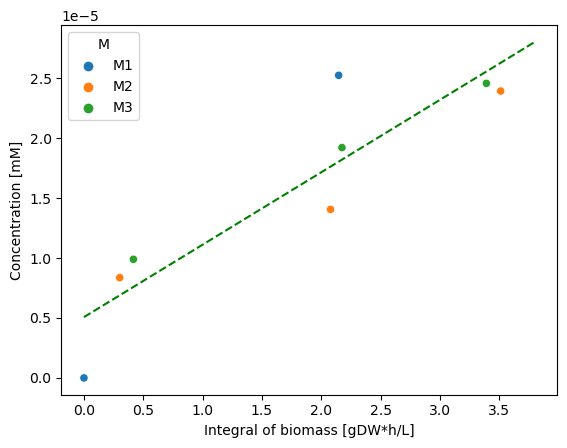

Galactose BETA-ALANINE
LinregressResult(slope=3.5175512073339706e-05, intercept=3.782274196510709e-05, rvalue=0.8747482643088089, pvalue=0.009957085511097863, stderr=8.714363937763044e-06, intercept_stderr=1.9613962771283633e-05) [3.51755121e-05 3.78227420e-05] [8.71436397e-06 1.96139628e-05]


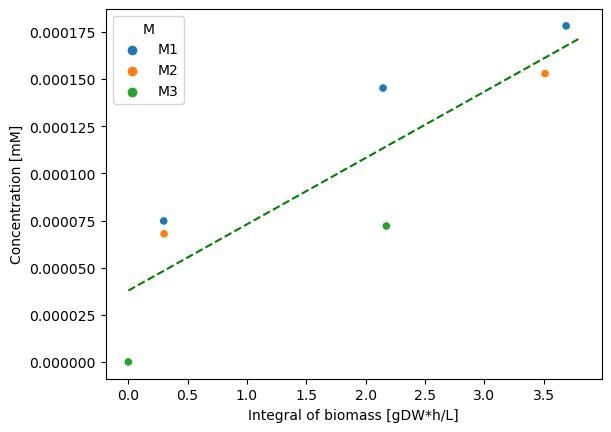

Galactose ALANINE
LinregressResult(slope=-0.0005838266083641207, intercept=0.0034985714413894907, rvalue=-0.9770199485289724, pvalue=0.02298005147102755, stderr=9.006301462461014e-05, intercept_stderr=0.00022566840536900913) [-0.00058383  0.00349857] [9.00630148e-05 2.25668406e-04]


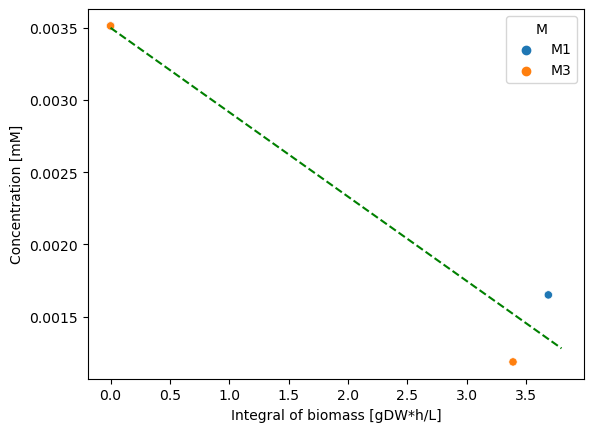

Galactose CREATINE
LinregressResult(slope=1.0287462926325022e-06, intercept=1.179752122532695e-06, rvalue=0.7013659991079965, pvalue=0.016171672521156196, stderr=3.4850645074950894e-07, intercept_stderr=7.524881376362523e-07) [1.02874629e-06 1.17975214e-06] [3.48506452e-07 7.52488143e-07]


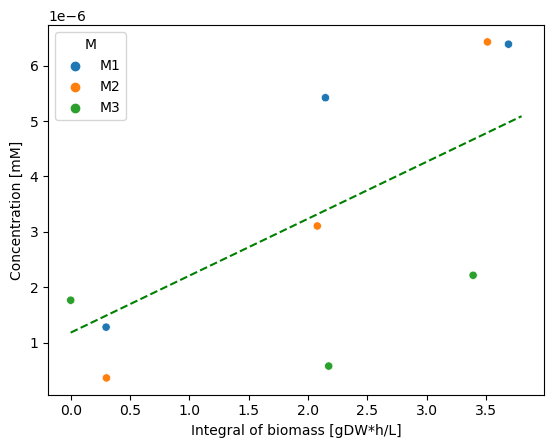

Galactose ALPHA-AMINOADIPATE
LinregressResult(slope=1.4857594922422913e-05, intercept=-3.326326223966865e-06, rvalue=0.8646281423947644, pvalue=0.026247928562934366, stderr=4.316676095907279e-06, intercept_stderr=1.1428498806139772e-05) [ 1.48575949e-05 -3.32632620e-06] [4.31667622e-06 1.14284988e-05]


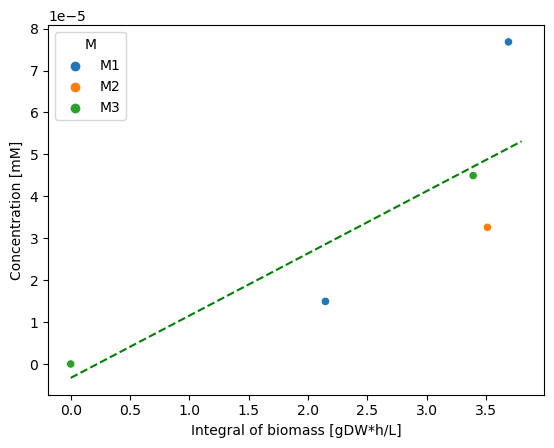

Galactose GLUTAMATE
LinregressResult(slope=0.0019570930142895375, intercept=0.0006719806980651929, rvalue=0.7040971682800846, pvalue=0.051248044779189, stderr=0.0008057957675172458, intercept_stderr=0.0018007741241889154) [0.00195709 0.00067198] [0.0008058  0.00180077]


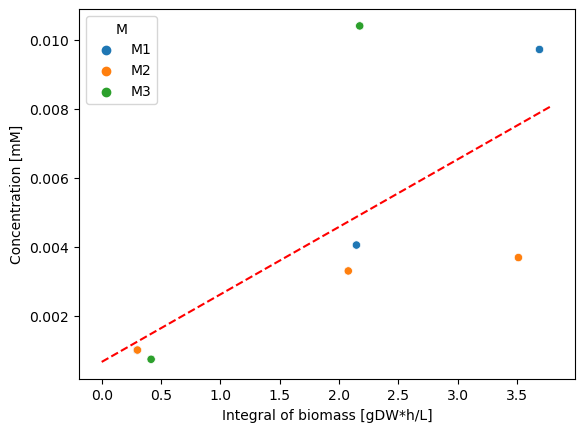

Galactose ASPARAGINE
LinregressResult(slope=-6.138996970331763e-05, intercept=0.0007353153632058846, rvalue=-0.4685134897525838, pvalue=0.2889663248795112, stderr=5.176967161553248e-05, intercept_stderr=0.00010283356748061976) [-6.13899674e-05  7.35315359e-04] [5.17696720e-05 1.02833567e-04]


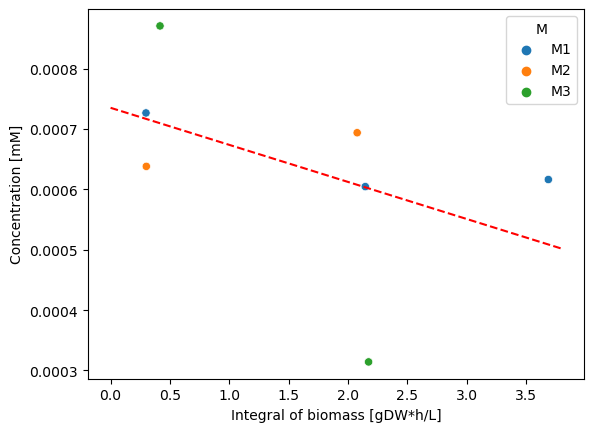

Galactose ASPARTATE
LinregressResult(slope=0.0001200630754986912, intercept=0.00011868934721466517, rvalue=0.9237640090756087, pvalue=4.886989697588297e-05, stderr=1.6591402304899668e-05, intercept_stderr=3.582382304355486e-05) [0.00012006 0.00011869] [1.65914023e-05 3.58238232e-05]


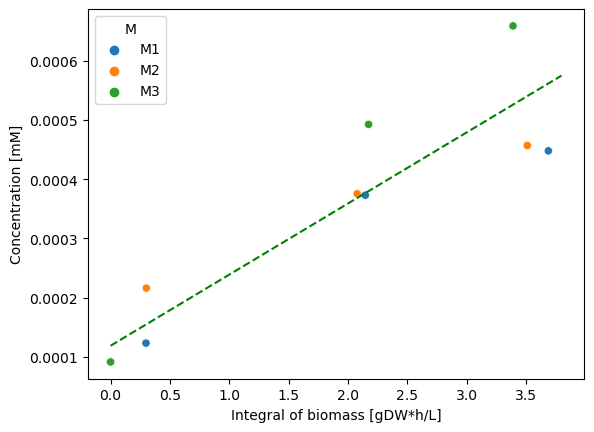

Galactose PYRUVATE
LinregressResult(slope=0.0020376674003248925, intercept=0.0002584912680030117, rvalue=0.9760885323843899, pvalue=0.023911467615610135, stderr=0.0003208746473607255, intercept_stderr=0.0006793559176170298) [0.00203767 0.00025849] [0.00032087 0.00067936]


Galactose LACTATE
LinregressResult(slope=-0.000507445431246345, intercept=0.002309590637393052, rvalue=-0.7039263547096719, pvalue=0.03430377365239996, stderr=0.00019352558409635337, intercept_stderr=0.0003305187017048944) [-0.00050745  0.00230959] [0.00019353 0.00033052]


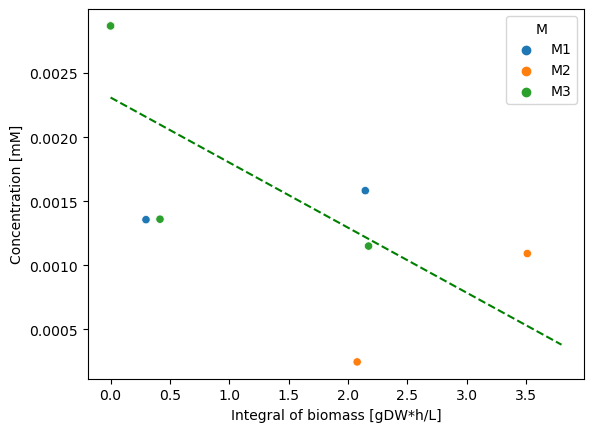

Galactose HEXOSES including Glucose and Fructose
LinregressResult(slope=-5.80833239655254, intercept=39.24910681688457, rvalue=-0.775051207093973, pvalue=0.01415225682154045, stderr=1.7898610680353502, intercept_stderr=2.2330084988633905) [-5.80833233 39.24910676] [1.78986107 2.23300849]


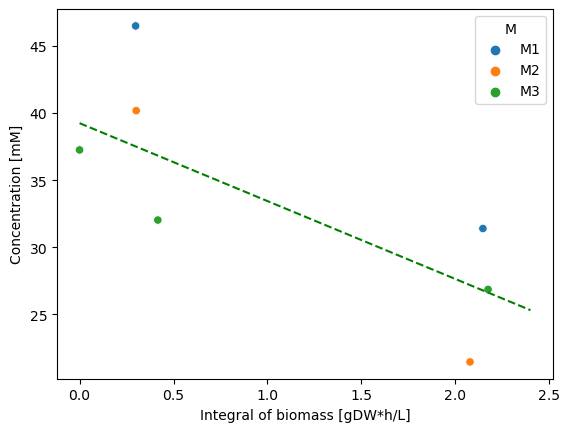

Galactose NAD
LinregressResult(slope=1.780954602622899e-05, intercept=1.4236415910543727e-05, rvalue=0.8347290382304151, pvalue=0.03871459012363347, stderr=5.87437377303904e-06, intercept_stderr=1.1481442390445866e-05) [1.78095459e-05 1.42364160e-05] [5.87437382e-06 1.14814425e-05]


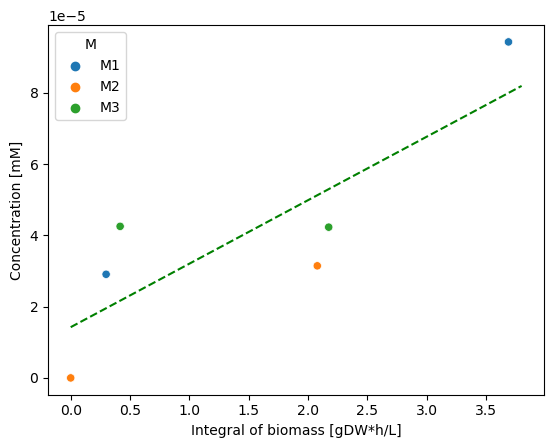

Galactose SUCCINATE
LinregressResult(slope=0.017174168076204758, intercept=-0.012787699393699226, rvalue=0.33694254666361595, pvalue=0.5137127707961398, stderr=0.023995058441238167, intercept_stderr=0.07002746121197145) [ 0.01717416 -0.01278769] [0.02399506 0.07002746]


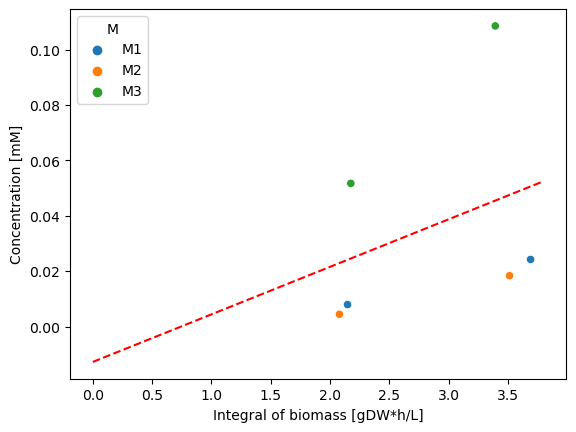

Galactose MALATE
LinregressResult(slope=0.0010141566552036288, intercept=0.0025789353789898786, rvalue=0.36622248117740586, pvalue=0.26798636522787667, stderr=0.0008589500676795333, intercept_stderr=0.001593216234318554) [0.00101416 0.00257894] [0.00085895 0.00159322]


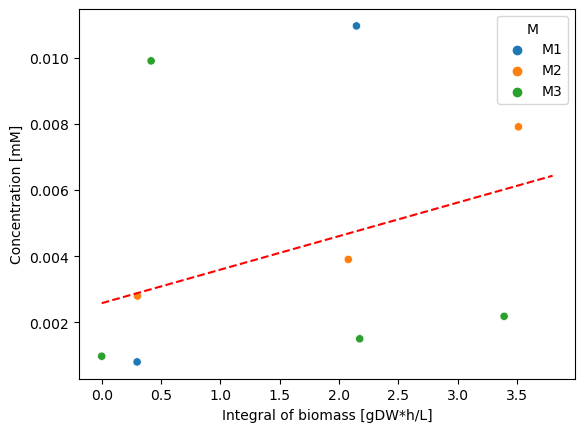

Galactose CIS-ACONITATE
LinregressResult(slope=0.00010194048280356678, intercept=-2.3769695117029674e-06, rvalue=0.9893739601817523, pvalue=4.030341759981113e-07, stderr=5.6621467920691525e-06, intercept_stderr=1.3538743083612042e-05) [ 1.01940483e-04 -2.37696969e-06] [5.66214561e-06 1.35387429e-05]


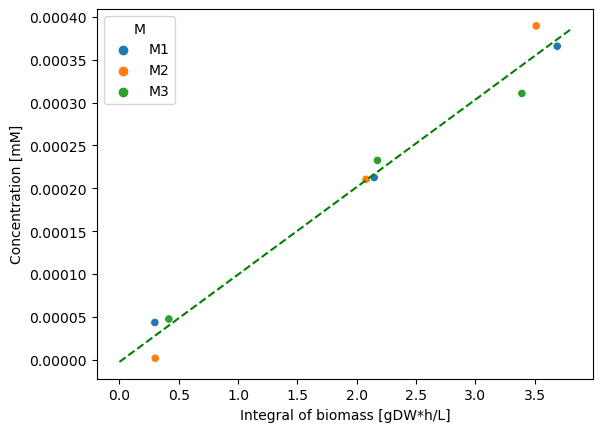

Galactose ISOCITRATE
LinregressResult(slope=4.492629683057993e-05, intercept=1.0748674666664291e-05, rvalue=0.7387747514298628, pvalue=0.09344511912980764, stderr=2.0492163874168412e-05, intercept_stderr=5.4123981147711e-05) [4.49262967e-05 1.07486750e-05] [2.04921640e-05 5.41239813e-05]


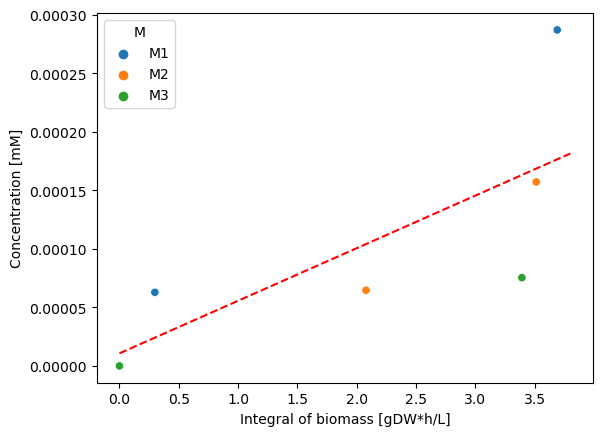

Galactose TRANS-ACONITATE
LinregressResult(slope=5.553906564197389e-06, intercept=-9.359799614610016e-07, rvalue=0.9539442913515164, pvalue=0.00023586689994726061, stderr=7.130135017396158e-07, intercept_stderr=1.8067375229274686e-06) [ 5.55390656e-06 -9.35979936e-07] [7.13013469e-07 1.80673745e-06]


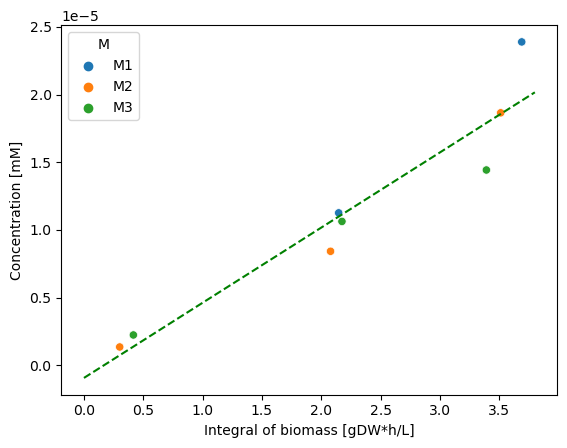

L-malate PHENYLALANINE
LinregressResult(slope=-1.4902293083470278e-05, intercept=3.2135792757743026e-05, rvalue=-0.45983435616724755, pvalue=0.3588639093264773, stderr=1.4389210233696353e-05, intercept_stderr=1.1244204866525531e-05) [-1.49022930e-05  3.21357927e-05] [1.43892102e-05 1.12442048e-05]


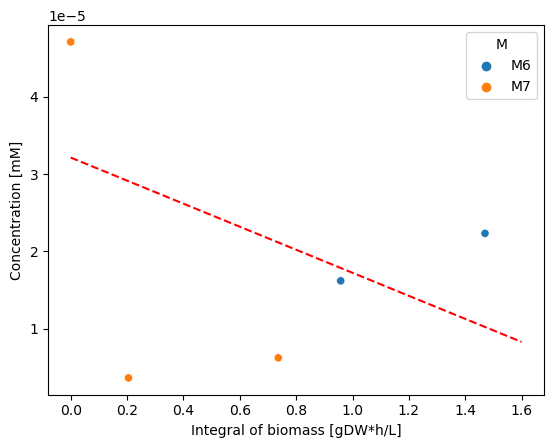

L-malate LEUCINE
LinregressResult(slope=7.085294973344023e-05, intercept=8.850448680688237e-07, rvalue=0.9977853354909945, pvalue=0.002214664509005537, stderr=3.3399056941149196e-06, intercept_stderr=2.6680797646043514e-06) [7.08529498e-05 8.85044798e-07] [3.33990555e-06 2.66807979e-06]


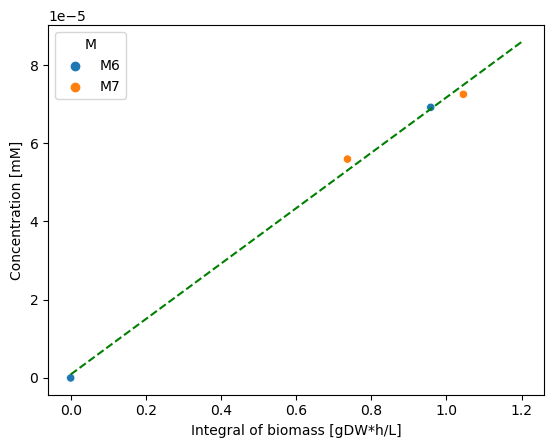

L-malate ISOLEUCINE
LinregressResult(slope=2.4368837736272924e-05, intercept=9.403314534733829e-05, rvalue=0.23901877438925434, pvalue=0.5686161745308267, stderr=4.041597781836734e-05, intercept_stderr=2.671752773174954e-05) [2.43688362e-05 9.40331460e-05] [4.04159777e-05 2.67175277e-05]


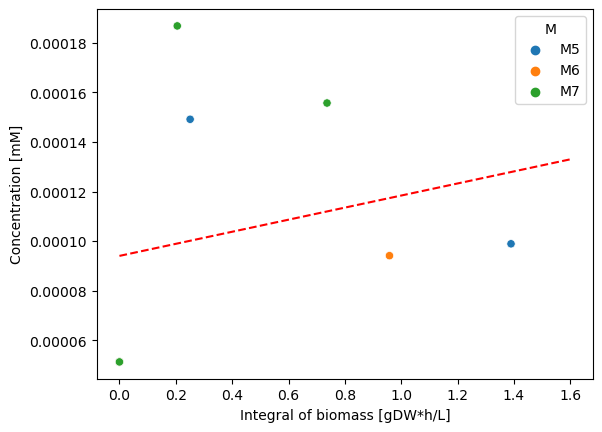

L-malate METHIONINE
LinregressResult(slope=3.5086103758690546e-05, intercept=1.558763937088899e-05, rvalue=0.8281601438878606, pvalue=0.021382871295399047, stderr=1.0619519919691673e-05, intercept_stderr=8.743942312619511e-06) [3.50861038e-05 1.55876394e-05] [1.06195199e-05 8.74394227e-06]


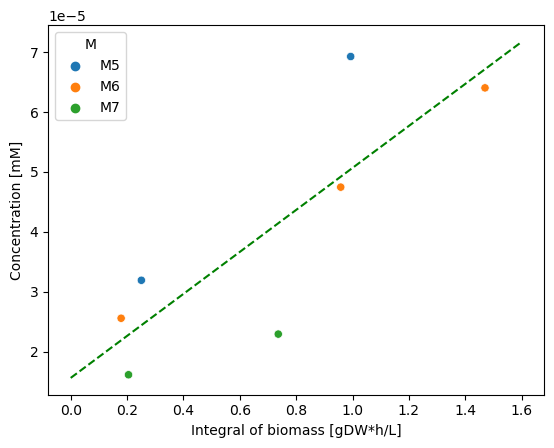

L-malate GAMMA-AMINOBUTYRATE
LinregressResult(slope=0.000806499690733143, intercept=0.0005227342550089106, rvalue=0.5168549868273739, pvalue=0.2937536019264174, stderr=0.0006679074398750091, intercept_stderr=0.00043836252888517754) [0.0008065  0.00052273] [0.00066791 0.00043836]


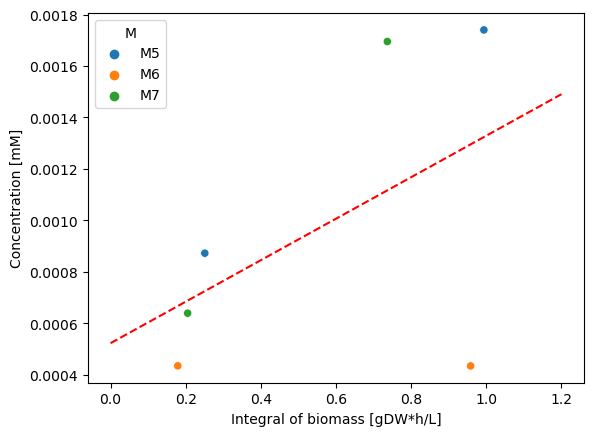

L-malate PROLINE
LinregressResult(slope=-2.1085602819724086e-05, intercept=4.06591820331876e-05, rvalue=-0.8354230300409023, pvalue=0.009813879599417716, stderr=5.663130540963648e-06, intercept_stderr=4.998987792348932e-06) [-2.10856027e-05  4.06591820e-05] [5.66313051e-06 4.99898777e-06]


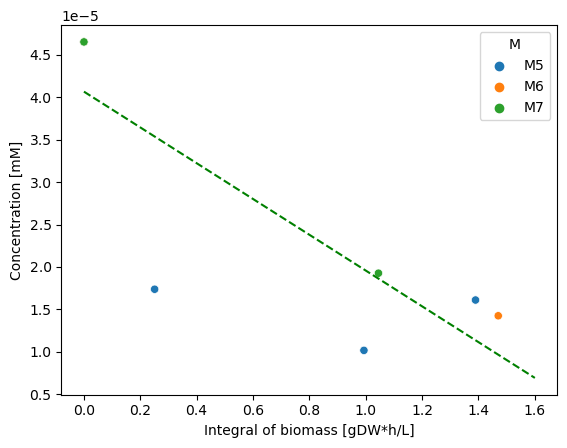

L-malate PIPECOLIC ACID
LinregressResult(slope=8.651743319002603e-06, intercept=5.883719863809439e-06, rvalue=0.38488668562323325, pvalue=0.45117809744436377, stderr=1.0373502753463847e-05, intercept_stderr=1.1699010290002895e-05) [8.65174354e-06 5.88371964e-06] [1.03735030e-05 1.16990105e-05]


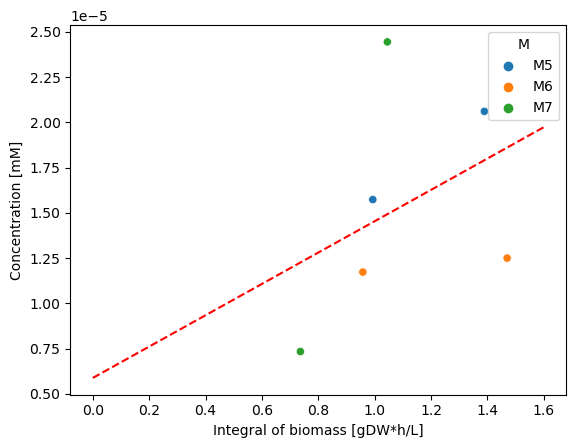

L-malate BETA-ALANINE
LinregressResult(slope=0.00010182639438539138, intercept=7.361490588195065e-05, rvalue=0.5021378145904061, pvalue=0.2047829536235991, stderr=7.159311728774598e-05, intercept_stderr=6.540209595130015e-05) [1.01826395e-04 7.36149048e-05] [7.15931179e-05 6.54020962e-05]


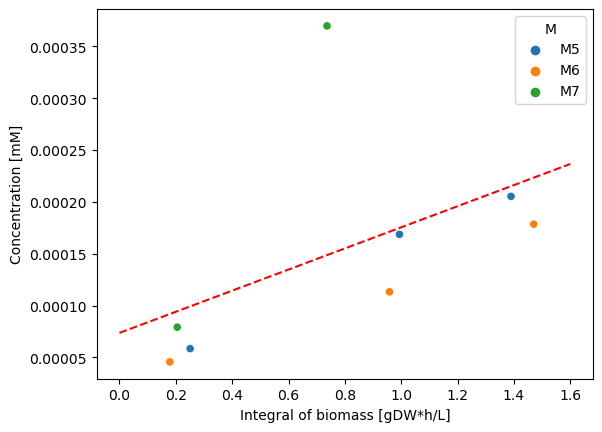

L-malate CREATINE
LinregressResult(slope=-1.1106243549300111e-07, intercept=1.848501867544124e-06, rvalue=-0.17039530471091094, pvalue=0.7468807192715206, stderr=3.2113042927646873e-07, intercept_stderr=2.699610653467847e-07) [-1.11062438e-07  1.84850187e-06] [3.21130433e-07 2.69961066e-07]


L-malate ALPHA-AMINOADIPATE
LinregressResult(slope=2.6771823349463307e-05, intercept=-3.5149108771735676e-06, rvalue=0.6745900047567587, pvalue=0.14160839440365058, stderr=1.464798021119578e-05, intercept_stderr=1.592167198845521e-05) [ 2.67718234e-05 -3.51491099e-06] [1.46479806e-05 1.59216720e-05]


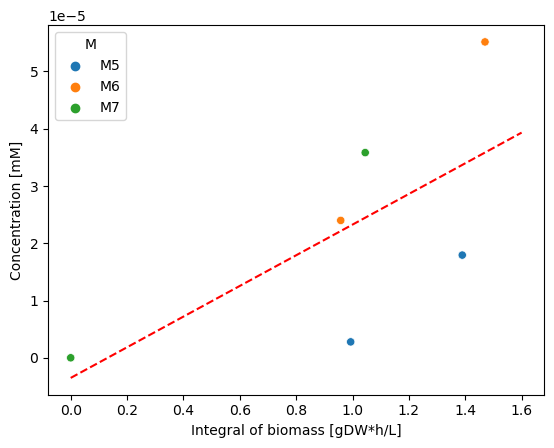

L-malate GLUTAMATE
LinregressResult(slope=0.003804340427417511, intercept=0.001780970738300496, rvalue=0.7127981525083432, pvalue=0.013817795890275632, stderr=0.001247780688302136, intercept_stderr=0.0009090054798305675) [0.00380434 0.00178097] [0.00124778 0.00090901]


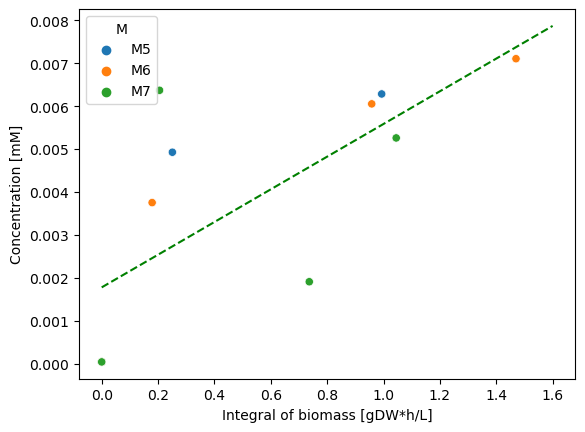

L-malate ASPARAGINE
LinregressResult(slope=0.00029499951295162204, intercept=7.552089327039469e-05, rvalue=0.9235082584201909, pvalue=0.0003779553479729495, stderr=4.6311174755701125e-05, intercept_stderr=2.4817458865583615e-05) [2.94999512e-04 7.55208942e-05] [4.63111743e-05 2.48174588e-05]


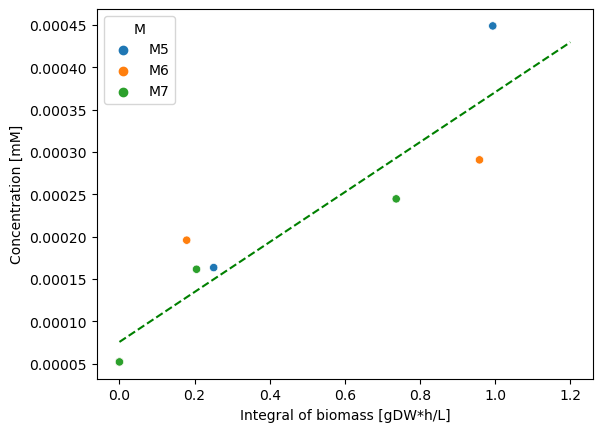

L-malate ASPARTATE
LinregressResult(slope=0.0052436182104608035, intercept=0.0028445335327101293, rvalue=0.6256078890506466, pvalue=0.07154373707364335, stderr=0.0024714456824620644, intercept_stderr=0.0013244104017351855) [0.00524362 0.00284453] [0.00247145 0.00132441]


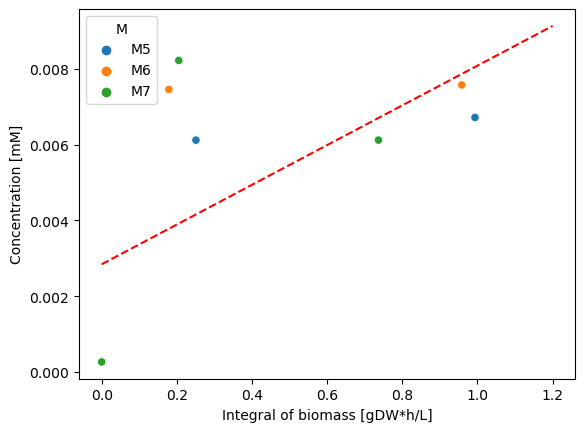

L-malate PYRUVATE
LinregressResult(slope=0.15615379057419715, intercept=0.042421181561587015, rvalue=0.7480265621798353, pvalue=0.0872369459906827, stderr=0.06927186975685619, intercept_stderr=0.045464670992290186) [0.15615379 0.04242118] [0.06927187 0.04546467]


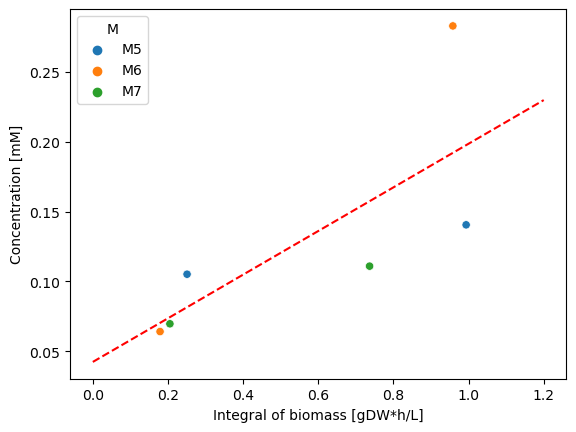

L-malate LACTATE
LinregressResult(slope=-0.007426193400307344, intercept=0.01062358640810604, rvalue=-0.7891162942779673, pvalue=0.03488570021966613, stderr=0.0025851219776625543, intercept_stderr=0.0022314671625661845) [-0.00742619  0.01062359] [0.00258512 0.00223147]


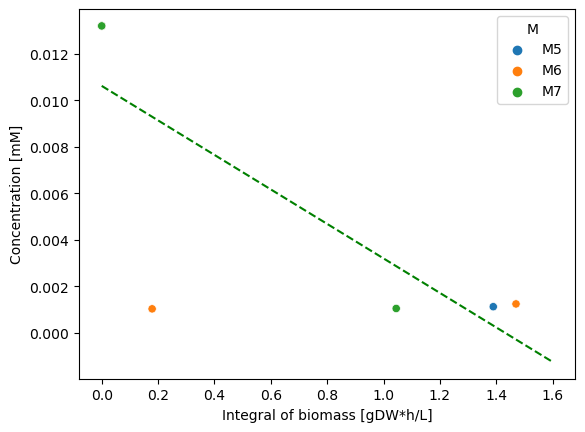

L-malate NAD
LinregressResult(slope=2.2833270045169745e-05, intercept=2.357750247349787e-05, rvalue=0.5339285999798737, pvalue=0.275213215897267, stderr=1.8079388287894653e-05, intercept_stderr=1.549996713915661e-05) [2.28332701e-05 2.35775024e-05] [1.80793882e-05 1.54999671e-05]


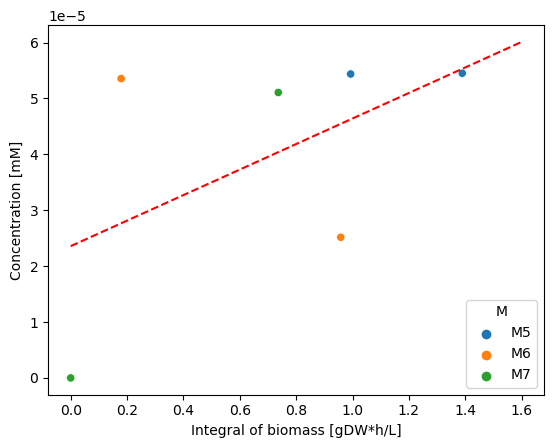

L-malate SUCCINATE
LinregressResult(slope=-0.1391753753704452, intercept=0.8193938919622199, rvalue=-0.30714510838074344, pvalue=0.3879968379779217, stderr=0.1524603278948897, intercept_stderr=0.10502876754776647) [-0.13917537  0.81939389] [0.15246033 0.10502877]


L-malate MALATE
LinregressResult(slope=-17.577178803766543, intercept=26.977930785662103, rvalue=-0.967082180007943, pvalue=2.0633088864014516e-05, stderr=1.7480890597822207, intercept_stderr=0.9367745163748267) [-17.57717879  26.97793078] [1.74808905 0.93677451]


L-malate CIS-ACONITATE
LinregressResult(slope=0.00044864489751446465, intercept=-5.562701207752587e-05, rvalue=0.9765001448683326, pvalue=6.401781016853017e-06, stderr=3.7425052525113146e-05, intercept_stderr=3.476994287510315e-05) [ 4.48644897e-04 -5.56270120e-05] [3.74250522e-05 3.47699430e-05]


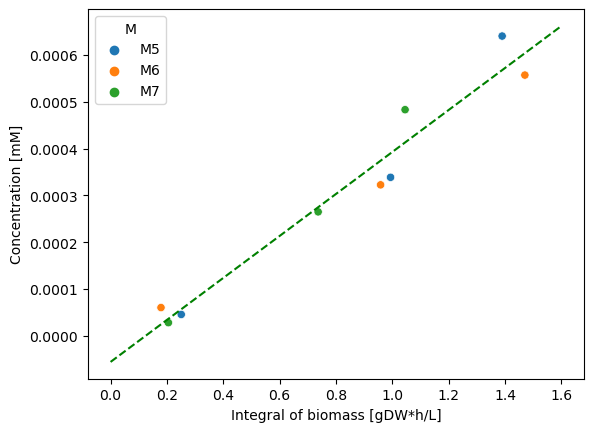

L-malate CITRATE
LinregressResult(slope=0.008201117630525594, intercept=-0.0005317363884136204, rvalue=0.632885870237399, pvalue=0.17742067970029768, stderr=0.005016445650451925, intercept_stderr=0.004662749562180357) [ 0.00820112 -0.00053174] [0.00501645 0.00466275]


L-malate ISOCITRATE
LinregressResult(slope=0.0003405764090726271, intercept=-0.0001231145647417956, rvalue=0.7558279969647714, pvalue=0.08215118720962487, stderr=0.00014751986607538885, intercept_stderr=0.00016034722095254953) [ 0.00034058 -0.00012311] [0.00014752 0.00016035]


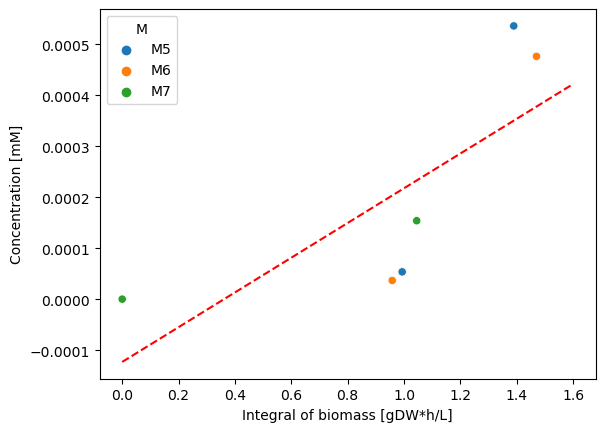

L-malate TRANS-ACONITATE
LinregressResult(slope=1.260224606018124e-05, intercept=-1.0876203214355891e-06, rvalue=0.9280084246604244, pvalue=0.0025686185725097245, stderr=2.26259246316382e-06, intercept_stderr=2.3689226085697658e-06) [ 1.26022460e-05 -1.08762029e-06] [2.26259262e-06 2.36892275e-06]


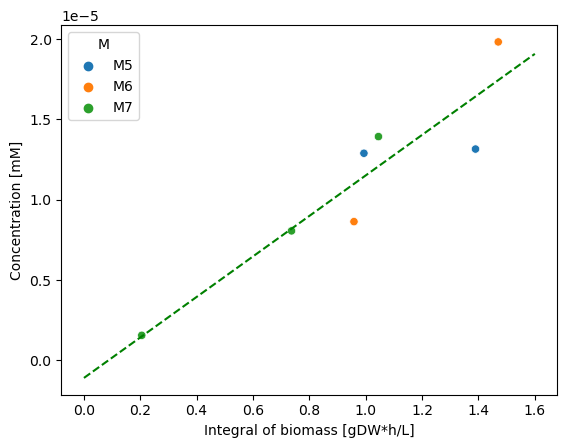

L-alanine PHENYLALANINE
LinregressResult(slope=1.3383816473327311e-05, intercept=4.77117688435894e-06, rvalue=0.5484636415372155, pvalue=0.0806320479648855, stderr=6.801547641650646e-06, intercept_stderr=6.759531865507515e-06) [1.33838164e-05 4.77117690e-06] [6.80154767e-06 6.75953190e-06]


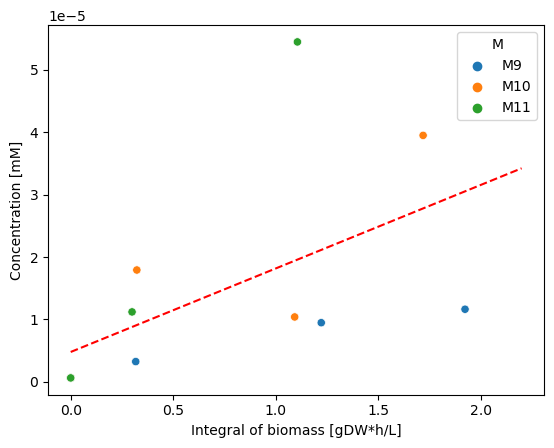

L-alanine LEUCINE
LinregressResult(slope=7.99041313378991e-05, intercept=0.0009718743264000914, rvalue=0.298057489782324, pvalue=0.4359763808307081, stderr=9.672036146174127e-05, intercept_stderr=0.00011915337299094469) [7.99041320e-05 9.71874326e-04] [9.67203549e-05 1.19153366e-04]


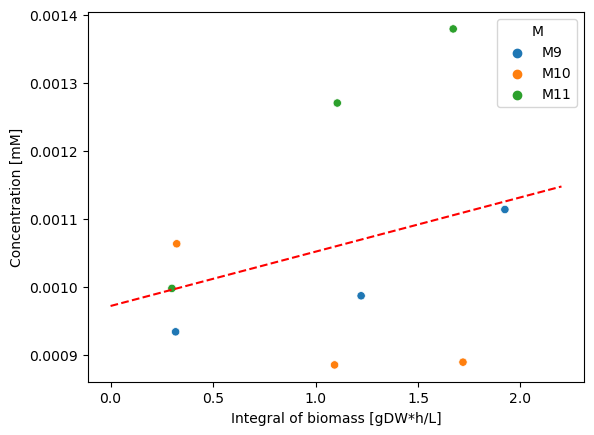

L-alanine ISOLEUCINE
LinregressResult(slope=0.0005975350091181155, intercept=0.00019785501256109337, rvalue=0.9049199729210289, pvalue=0.001998537646523374, stderr=0.00011472566199793177, intercept_stderr=0.00012799450630061724) [0.00059754 0.00019786] [0.00011473 0.00012799]


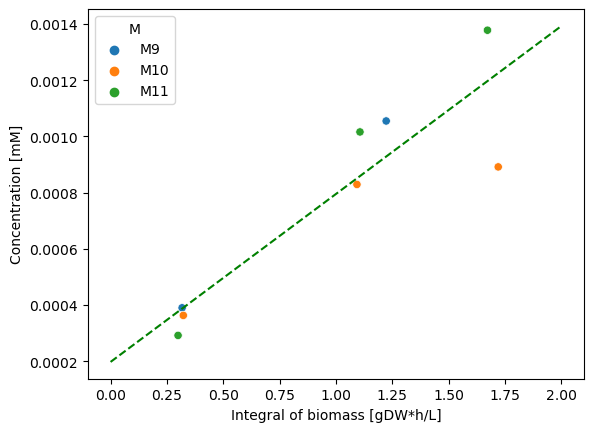

L-alanine METHIONINE
LinregressResult(slope=1.6362180447216204e-05, intercept=1.0852046090216528e-05, rvalue=0.664929878518716, pvalue=0.025591492648390092, stderr=6.126464198543138e-06, intercept_stderr=6.442643656794144e-06) [1.63621804e-05 1.08520462e-05] [6.12646422e-06 6.44264363e-06]


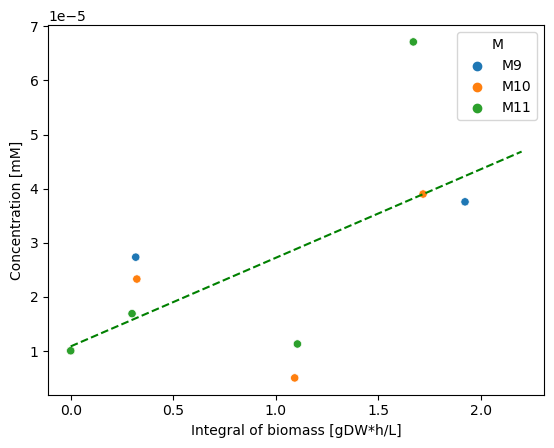

L-alanine GAMMA-AMINOBUTYRATE
LinregressResult(slope=0.008071256986678502, intercept=0.00024985399247027563, rvalue=0.9612451509817228, pvalue=0.002223803787183931, stderr=0.001157459979561711, intercept_stderr=0.0009691619557243336) [0.00807126 0.00024985] [0.00115746 0.00096916]


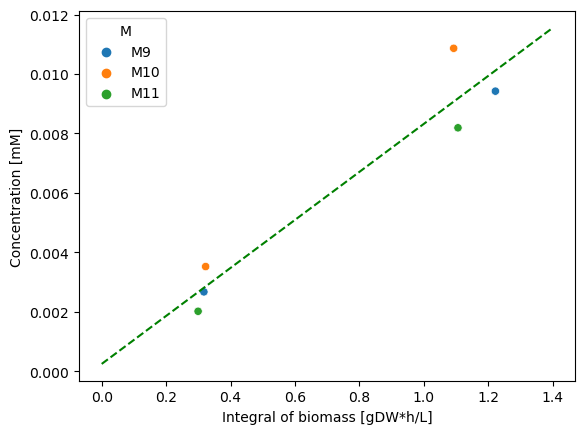

L-alanine PROLINE
LinregressResult(slope=0.00016368119384715433, intercept=0.00024330671853655154, rvalue=0.5973649575251451, pvalue=0.15667610623338957, stderr=9.827247654008568e-05, intercept_stderr=9.941027209473846e-05) [0.00016368 0.00024331] [9.82724772e-05 9.94102721e-05]


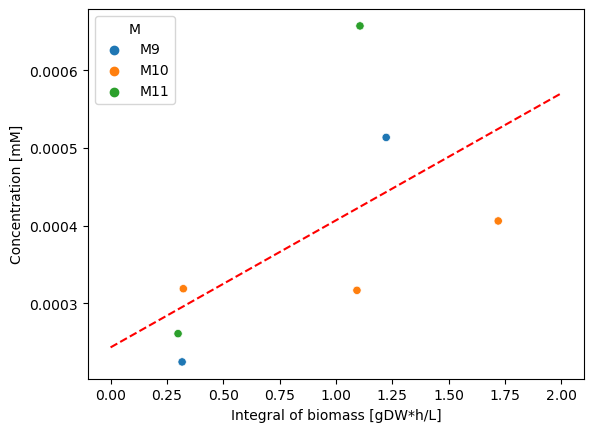

L-alanine VALINE
LinregressResult(slope=0.0028669971687005163, intercept=0.0031603380579708624, rvalue=0.6204983237744954, pvalue=0.041653776854684146, stderr=0.0012078042098407024, intercept_stderr=0.0011913645875188635) [0.002867   0.00316034] [0.0012078  0.00119136]


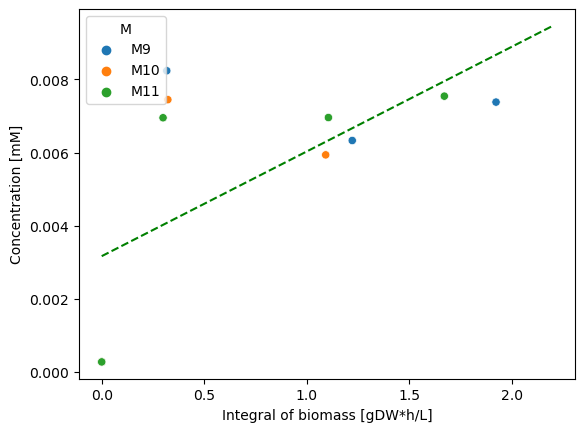

L-alanine PIPECOLIC ACID
LinregressResult(slope=1.958735939024353e-05, intercept=2.3892506020123645e-06, rvalue=0.9659693118572732, pvalue=2.315407779018739e-05, stderr=1.9823816783515255e-06, intercept_stderr=2.442168949342363e-06) [1.95873595e-05 2.38925044e-06] [1.98238160e-06 2.44216885e-06]


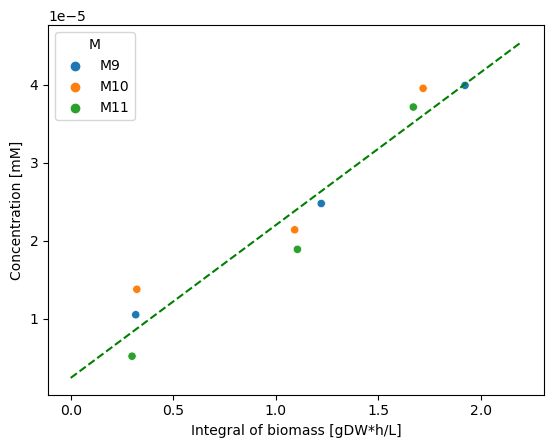

L-alanine BETA-ALANINE
LinregressResult(slope=0.0005067099970719409, intercept=-0.00014296308395972943, rvalue=0.9942007410032826, pvalue=5.034958875276044e-05, stderr=2.7404765087994275e-05, intercept_stderr=4.090051329189585e-05) [ 0.00050671 -0.00014296] [2.74047652e-05 4.09005129e-05]


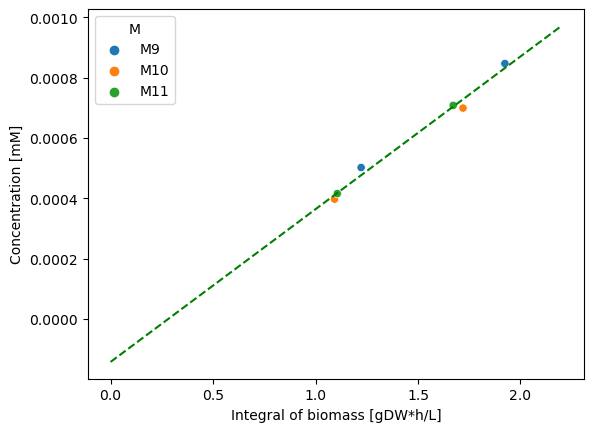

L-alanine ALANINE
LinregressResult(slope=-18.50519985610187, intercept=40.176635806842555, rvalue=-0.9920817697394302, pvalue=1.4434023734761954e-07, stderr=0.885451819221735, intercept_stderr=0.6053543658867081) [-18.50519983  40.1766358 ] [0.88545182 0.60535437]


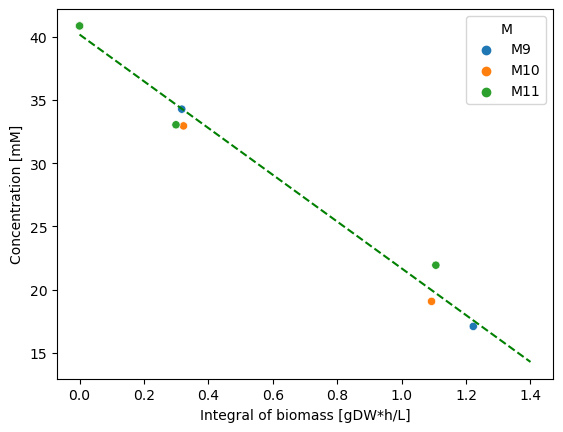

L-alanine CREATINE
LinregressResult(slope=-3.0258371767442752e-06, intercept=1.6504506624847204e-05, rvalue=-0.5246698185764036, pvalue=0.0975160088583898, stderr=1.63652941100131e-06, intercept_stderr=1.557052380204668e-06) [-3.02583722e-06  1.65045067e-05] [1.63652942e-06 1.55705238e-06]


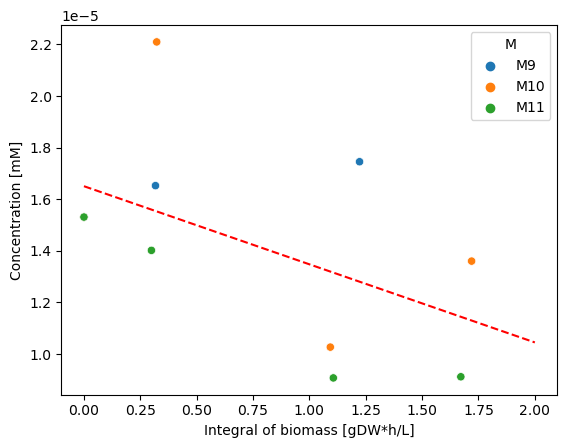

L-alanine ALPHA-AMINOADIPATE
LinregressResult(slope=6.149216616809826e-05, intercept=3.3910909284924596e-06, rvalue=0.9283690824635707, pvalue=0.0008701874915713725, stderr=1.0050064180584284e-05, intercept_stderr=1.115559835076083e-05) [6.14921661e-05 3.39109102e-06] [1.00500641e-05 1.11555984e-05]


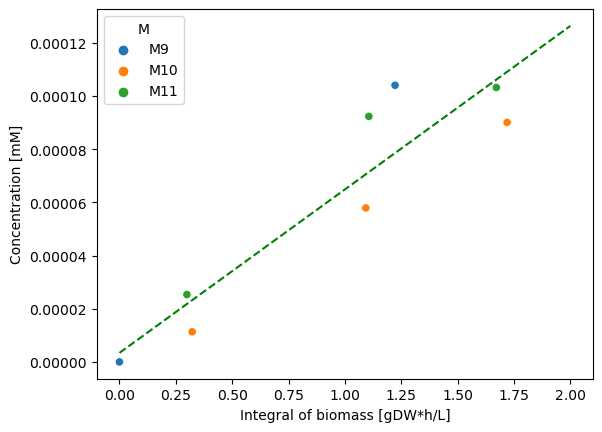

L-alanine GLUTAMATE
LinregressResult(slope=0.0005878597147517216, intercept=0.0027839852106656326, rvalue=0.3477861975245649, pvalue=0.39857601884371163, stderr=0.0006469805532987531, intercept_stderr=0.0007539654609715974) [0.00058786 0.00278399] [0.00064698 0.00075397]


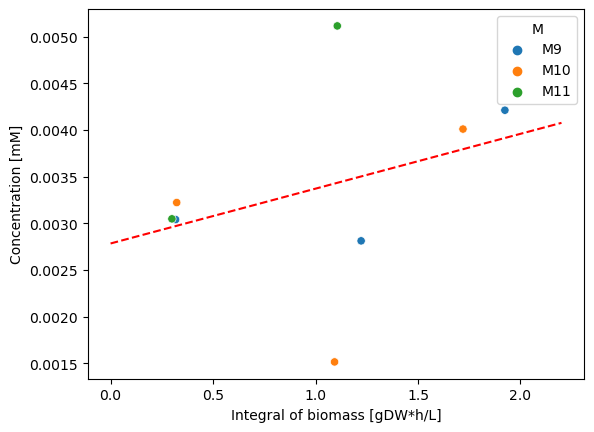

L-alanine ASPARAGINE
LinregressResult(slope=0.007486901326745983, intercept=0.0020203050670068445, rvalue=0.8520343664097352, pvalue=0.0035392631514437286, stderr=0.001738605010453622, intercept_stderr=0.0011886272192152395) [0.0074869  0.00202031] [0.00173861 0.00118863]


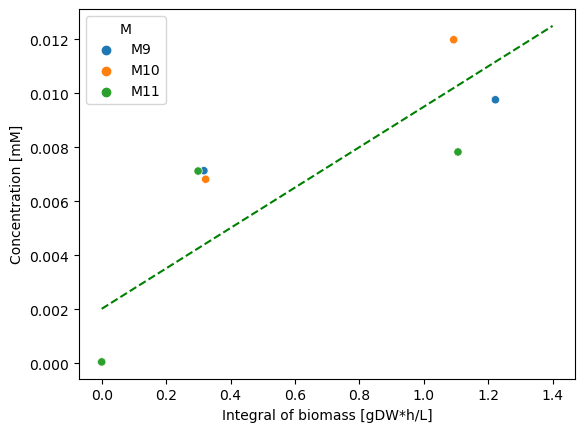

L-alanine ASPARTATE
LinregressResult(slope=3.585735843284163e-05, intercept=0.00029058725770609824, rvalue=0.22596778411557625, pvalue=0.5040619024164658, stderr=5.1526371245433545e-05, intercept_stderr=4.90240251422817e-05) [3.58573592e-05 2.90587257e-04] [5.15263713e-05 4.90240250e-05]


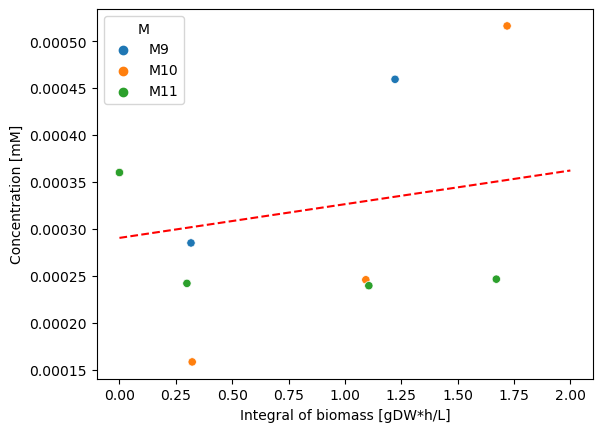

L-alanine LACTATE
LinregressResult(slope=0.00034169028871627416, intercept=0.000757911032392632, rvalue=0.5702532897405502, pvalue=0.06698640943565395, stderr=0.00016407209292845489, intercept_stderr=0.00017253965656304914) [0.00034169 0.00075791] [0.00016407 0.00017254]


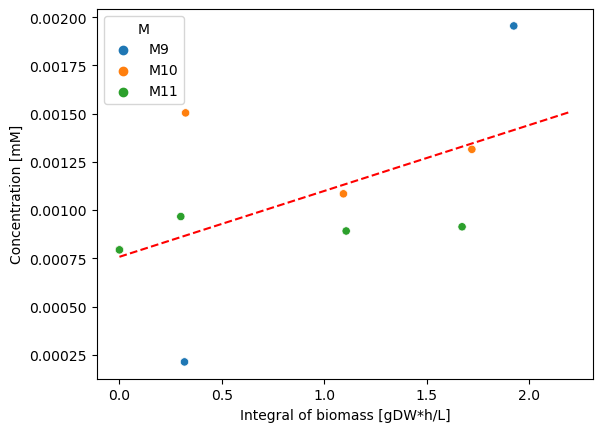

L-alanine NAD
LinregressResult(slope=5.8601379827982194e-05, intercept=1.489775384772253e-05, rvalue=0.9499916300500751, pvalue=0.0036887242050061024, stderr=9.631541282026033e-06, intercept_stderr=6.824521990529631e-06) [5.86013798e-05 1.48977539e-05] [9.63154136e-06 6.82452205e-06]


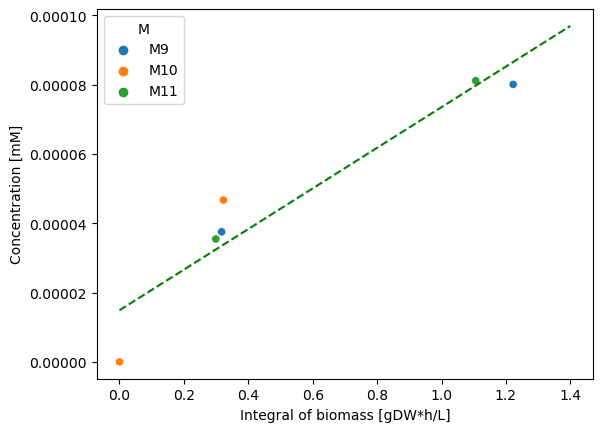

L-alanine SUCCINATE
LinregressResult(slope=0.005482185287864573, intercept=-0.0001973802138816082, rvalue=0.35487150633028713, pvalue=0.49003789667332726, stderr=0.007221455691161838, intercept_stderr=0.010777733125418985) [ 0.00548219 -0.00019738] [0.00722145 0.01077773]


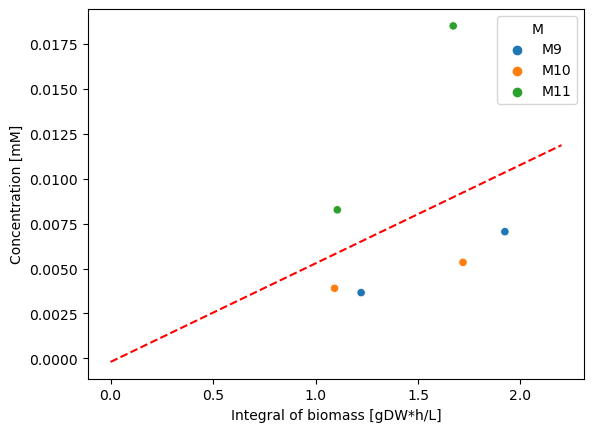

L-alanine MALATE
LinregressResult(slope=0.0037904599006873996, intercept=-0.00027682885608750277, rvalue=0.885969760275103, pvalue=0.00028284356087505155, stderr=0.0006613466136419378, intercept_stderr=0.0006523449157976038) [ 0.00379046 -0.00027683] [0.00066135 0.00065234]


L-alanine CIS-ACONITATE
LinregressResult(slope=0.0009291597223530631, intercept=-0.00026251355699411405, rvalue=0.970143573802377, pvalue=1.4706021762510017e-05, stderr=8.779568937642611e-05, intercept_stderr=0.00010815874098448688) [ 0.00092916 -0.00026251] [8.77956887e-05 1.08158741e-04]


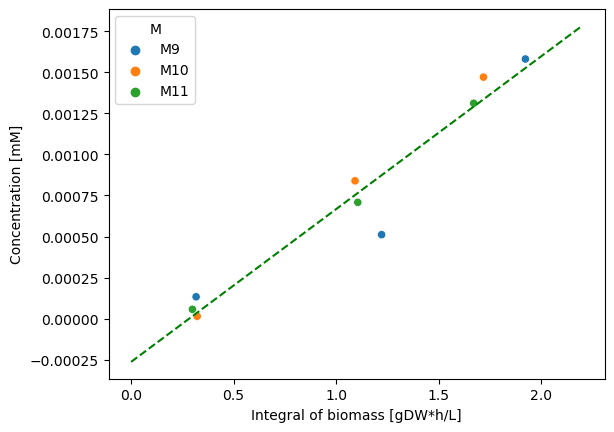

L-alanine CITRATE
LinregressResult(slope=0.0037979278347960222, intercept=0.00029615104297389325, rvalue=0.8816221397181142, pvalue=0.02019054341877841, stderr=0.0010165662216538056, intercept_stderr=0.0011170857536463026) [0.00379793 0.00029615] [0.00101657 0.00111709]


L-alanine ISOCITRATE
LinregressResult(slope=0.0007236187314302492, intercept=-0.0006237306957579329, rvalue=0.9898336351763878, pvalue=0.00015450708840554912, stderr=5.198868427241596e-05, intercept_stderr=7.759102715475063e-05) [ 0.00072362 -0.00062373] [5.1988684e-05 7.7591027e-05]


L-alanine TRANS-ACONITATE
LinregressResult(slope=1.9310598209114605e-05, intercept=-1.9942508783175184e-06, rvalue=0.8753492641699984, pvalue=0.000906295608919773, stderr=3.7710115940289595e-06, intercept_stderr=4.375884652355645e-06) [ 1.93105982e-05 -1.99425083e-06] [3.77101164e-06 4.37588466e-06]


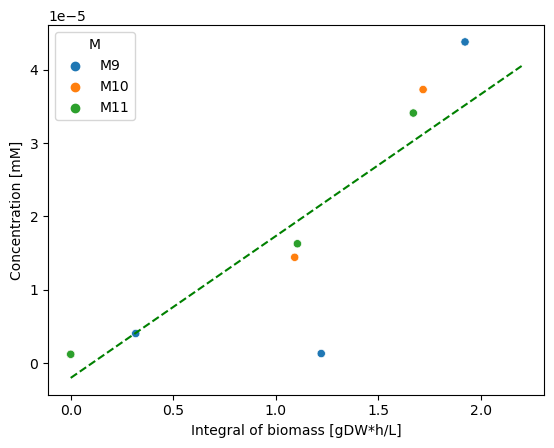

L-alanine TYROSINE
LinregressResult(slope=3.4965960533507884e-05, intercept=1.1116902822838519e-05, rvalue=0.6725395032385264, pvalue=0.14328870915867958, stderr=1.9238239134823042e-05, intercept_stderr=1.8109376990809124e-05) [3.49659608e-05 1.11169026e-05] [1.92382392e-05 1.81093771e-05]


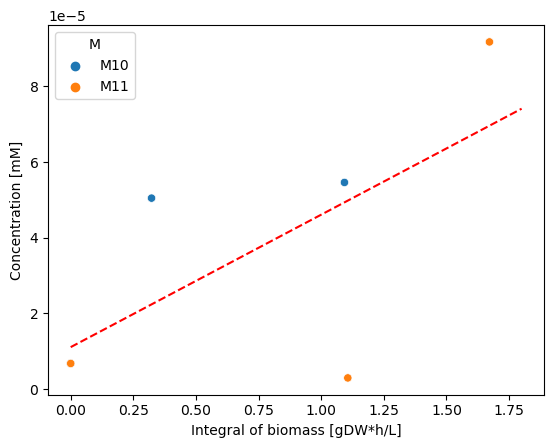

L-alanine GLUTAMINE
LinregressResult(slope=2.098062889125815e-05, intercept=6.683723512483696e-05, rvalue=0.16319186871000804, pvalue=0.7573852260790797, stderr=6.342034720890189e-05, intercept_stderr=7.316588325506996e-05) [2.09806266e-05 6.68372364e-05] [6.34203461e-05 7.31658824e-05]


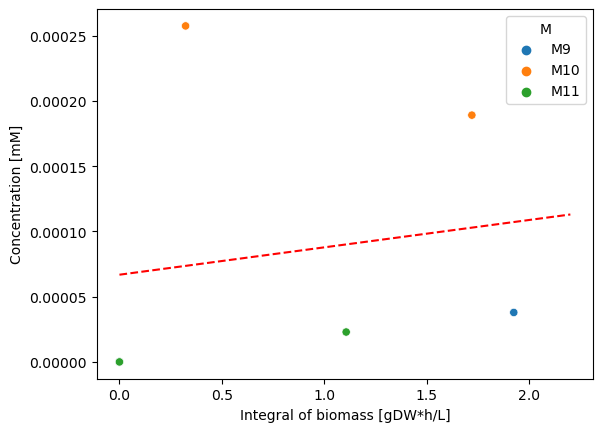

L-alanine LYSINE
LinregressResult(slope=-0.0010745672969355194, intercept=0.005801517159901603, rvalue=-0.522379890043446, pvalue=0.2877038728999172, stderr=0.0008770411999838153, intercept_stderr=0.0007343622929831178) [-0.00107457  0.00580152] [0.00087704 0.00073436]


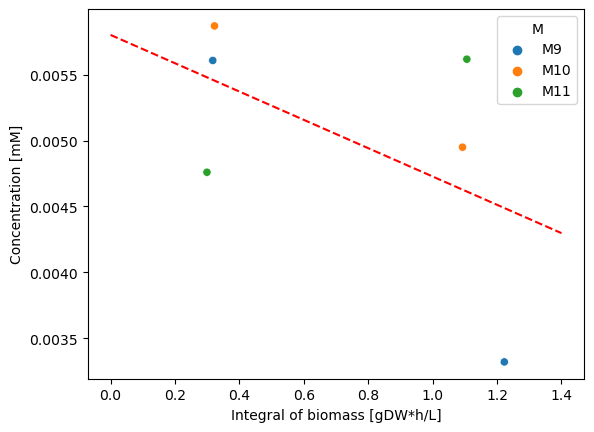

L-alanine ALPHA-AMINOBUTYRATE
LinregressResult(slope=0.19051853615334782, intercept=0.05105250637792552, rvalue=0.9475019551653803, pvalue=2.8746332020395695e-06, stderr=0.020331416492371277, intercept_stderr=0.02169135583124607) [0.19051854 0.05105251] [0.02033142 0.02169136]


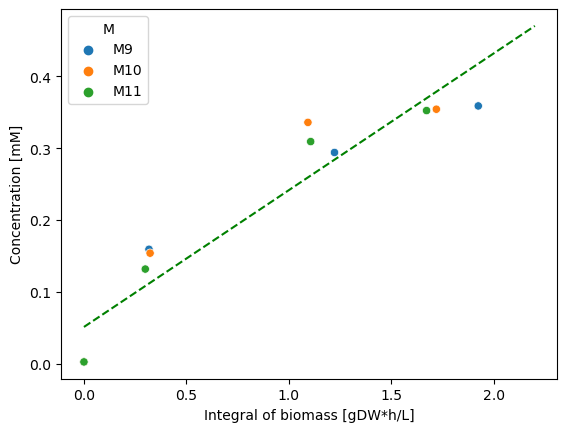

L-alanine GLYCINE
LinregressResult(slope=0.027229922776811716, intercept=0.02023595454266219, rvalue=0.869684031192177, pvalue=0.005005995846703322, stderr=0.006309460366332076, intercept_stderr=0.007039194636563042) [0.02722992 0.02023595] [0.00630946 0.00703919]


L-alanine SERINE
LinregressResult(slope=0.00044914087266833023, intercept=0.00038666005391853206, rvalue=0.6535091690539183, pvalue=0.11140762375543238, stderr=0.00023264572043544556, intercept_stderr=0.00024727601092288954) [0.00044914 0.00038666] [0.00023265 0.00024728]


In [219]:
average_rate_data = []
for cs in df_conc_biomass['Carbon source'].unique():
    for m in df_conc_biomass.Metabolite.unique():
        idx = (df_conc_biomass['Carbon source'] == cs) & (df_conc_biomass.Metabolite==m)
        # nonmedium_idx = df_conc_biomass.Time >= 0
        # idx = idx & nonmedium_idx
        if len( df_conc_biomass.loc[idx, 'Concentration [mM]']) > 3:
            print(cs, m)
            ax = sns.scatterplot(data = df_conc_biomass.loc[idx,:], x = 'Integral of biomass [gDW*h/L]', 
                            y = 'Concentration [mM]', hue = 'M')
            popt, pcov = scipy.optimize.curve_fit(lambda x,a,b: (a*x)+b, 
                            df_conc_biomass.loc[idx, 'Integral of biomass [gDW*h/L]'], 
                            df_conc_biomass.loc[idx, 'Concentration [mM]'])
            perr = np.sqrt(np.diag(pcov))
            res = scipy.stats.linregress(df_conc_biomass.loc[idx, 'Integral of biomass [gDW*h/L]'], 
                                        df_conc_biomass.loc[idx, 'Concentration [mM]'])
            print(res, popt, perr)
            average_rate_data.append([cs, m, popt[0], perr[0], len(df_conc_biomass.loc[idx,:].M.unique()), len(df_conc_biomass.loc[idx,:]), res.pvalue])
            x_max = df_conc_biomass.loc[idx,'Integral of biomass [gDW*h/L]'].max()
            x_arr = np.arange(0, x_max+0.3, 0.2)
            yfit = popt[1]+popt[0]*x_arr
            if res.pvalue < 0.05:
                c = 'g'
            else:
                c = 'r'
            ax.plot(x_arr, yfit, ls = '--', c = c)
            plt.show()

average_rate_df = pd.DataFrame(average_rate_data, columns = ['Carbon source', 'Metabolite', 'Rate', 'Rate std', 'N bioreactors', 'N samples', 'pvalue'])

In [220]:
(average_rate_df['Rate'] > average_rate_df['Rate std']).sum()

51

## Uptake rates

In [236]:
mal_uptake = df_rate.loc[(df_rate['Metabolite'] == 'MALATE')&(df_rate['Carbon source'] == 'L-malate'),'Rate [mmol/gDW/h]'].mean()

In [237]:
ala_uptake = df_rate.loc[(df_rate['Metabolite'] == 'ALANINE')&(df_rate['Carbon source'] == 'L-alanine'),'Rate [mmol/gDW/h]'].mean()

In [243]:
gal = df_conc_biomass.loc[(df_conc_biomass['Metabolite'] == 'HEXOSES including Glucose and Fructose')&(df_conc_biomass['Carbon source'] == 'Galactose'),:]
# Since we know that the initial concentration of galactose is ~20 mM, we can scale the concentrations so that the medium values corresponds
scaling_galactose = 20/gal.loc[gal.Time == 0, 'Concentration [mM]'].values[0]
gal_uptake = df_rate.loc[(df_rate['Metabolite'] == 'HEXOSES including Glucose and Fructose')&(df_rate['Carbon source'] == 'Galactose'),'Rate [mmol/gDW/h]'].mean()*scaling_galactose

In [242]:
# ala = df_conc_biomass.loc[(df_conc_biomass['Metabolite'] == 'ALANINE')&(df_conc_biomass['Carbon source'] == 'L-alanine'),:]
# ala_fit = np.polyfit(ala['Integral of biomass [gDW*h/L]'], ala['Concentration [mM]'], 1)

In [244]:
# gal = df_conc_biomass.loc[(df_conc_biomass['Metabolite'] == 'HEXOSES including Glucose and Fructose')&(df_conc_biomass['Carbon source'] == 'Galactose'),:]
# # Since we know that the initial concentration of galactose is ~20 mM, we can scale the concentrations so that the medium values corresponds
# scaling_galactose = 20/gal.loc[gal.Time == 0, 'Concentration [mM]'].values[0]
# gal_fit = np.polyfit(gal['Integral of biomass [gDW*h/L]'], gal['Concentration [mM]']*scaling_galactose, 1)

In [245]:
# mal = df_conc_biomass.loc[(df_conc_biomass['Metabolite'] == 'MALATE')&(df_conc_biomass['Carbon source'] == 'L-malate'),:]
# mal_fit = np.polyfit(mal['Integral of biomass [gDW*h/L]'], mal['Concentration [mM]'], 1)

In [240]:
# int_gdw_df['Pred conc'] = np.nan
# idx = int_gdw_df.REL.isin(['REL04','REL05','REL06'])
# int_gdw_df.loc[idx, 'Pred conc']= 40 - 16.9*int_gdw_df.loc[idx,'Integrated biomass'].values

In [241]:
# yield_dict['L-malate']*16.9

In [195]:
int_gdw_df.loc[idx]

REL  Hours  Integrated biomass   Pred conc
48  REL04   2.00            0.038080   39.356448
49  REL04   4.00            0.107520   38.182912
50  REL04   6.00            0.250787   35.761705
51  REL04   8.00            0.570453   30.359339
52  REL04   9.25            0.993477   23.210246
53  REL04  10.00            1.389422   16.518764
54  REL04  11.00            2.087067    4.728573
55  REL04  12.00            2.860356   -8.340009
56  REL04  13.00            3.555922  -20.095086
57  REL04  14.00            4.229556  -31.479489
58  REL04  16.00            5.647009  -55.434450
59  REL04  18.00            7.001929  -78.332598
60  REL04  20.00            8.350922 -101.130586
61  REL04  22.00            9.889662 -127.135292
62  REL04  26.00           12.553396 -172.152385
63  REL04  28.00           12.553396 -172.152385
64  REL05   2.00            0.031080   39.474748
65  REL05   4.00            0.080453   38.640339
66  REL05   6.00            0.178920   36.976252
67  REL05   8.00            0.399653   33.245859
68  REL05   9.25            0.682245   28.470065
69  REL05  10.00            0.958160   23.807096
70  REL05  11.00            1.470093   15.155423
71  REL05  12.00            2.122027    4.137749
72  REL05  13.00            2.791343   -7.173702
73  REL05  14.00            3.479840  -18.809296
74  REL05  16.00            4.901649  -42.837866
75  REL05  18.00            6.163733  -64.167093
76  REL05  20.00            7.454673  -85.983979
77  REL05  22.00            8.889067 -110.225227
78  REL05  26.00           11.583911 -155.768098
79  REL05  28.00           11.583911 -155.768098
80  REL06   2.00            0.030520   39.484212
81  REL06   4.00            0.091280   38.457368
82  REL06   6.00            0.205147   36.533021
83  REL06   8.00            0.434747   32.652781
84  REL06   9.25            0.736543   27.552421
85  REL06  10.00            1.045022   22.339124
86  REL06  11.00            1.643533   12.224287
87  REL06  12.00            2.368489   -0.027462
88  REL06  13.00            3.112706  -12.604724
89  REL06  14.00            3.833449  -24.785286
90  REL06  16.00            5.468151  -52.411754
91  REL06  18.00            6.775316  -74.502833
92  REL06  20.00            8.060516  -96.222713
93  REL06  22.00            9.496916 -120.497873
94  REL06  26.00           12.338604 -168.522415
95  REL06  28.00           12.338604 -168.522415

# Add data from GC-MS

In [281]:
gc_ms_fn = folder/'../GC_MS/gc_ms_estiamted_rates_sintef_2023.csv'
gc_ms_rates = pd.read_csv(gc_ms_fn, index_col=0)

In [282]:
gc_ms_rates

M  Metabolite Carbon source  Rate [mmol/gDW/h]  Std.Err [mmol/gDW/h]
0    M1     Acetate     Galactose           0.106216              0.041288
1    M1  Propionate     Galactose           0.011163                   inf
4    M1     Formate     Galactose           0.230213              0.099379
5    M2     Acetate     Galactose           0.045650              0.034589
8    M2     Formate     Galactose           0.159530              0.066895
9    M3     Acetate     Galactose           0.414485              0.177250
12   M3     Formate     Galactose           0.610734              0.128734
13  M11     Acetate     L-alanine           2.559390              1.097174
14  M11  Propionate     L-alanine           0.121475              0.043289
17  M11     Formate     L-alanine           0.044790              0.017727
18  M10     Acetate     L-alanine           2.649973              1.310192
19  M10  Propionate     L-alanine           0.097933              0.016185
22   M9     Acetate     L-alanine           2.507911              1.018136
23   M9  Propionate     L-alanine           0.124897              0.032070
25   M9     Formate     L-alanine           0.086188              0.009261
26   M7     Acetate      L-malate           1.253358              0.249373
27   M7  Propionate      L-malate           0.100156              0.011124
30   M7     Formate      L-malate           0.295834                   inf
31   M6     Acetate      L-malate           0.143806              0.039327
32   M6  Propionate      L-malate           0.062004                   inf
35   M6     Formate      L-malate           0.150539              0.098172
36   M5     Acetate      L-malate           0.991848              0.068707
37   M5  Propionate      L-malate           0.106302              0.013630
40   M5     Formate      L-malate           0.013822                   inf

In [283]:
df_rate2 = pd.concat([df_rate, gc_ms_rates])

# Get models and estimate metabolite values

In [381]:
model_ez = reframed.load_cbmodel('../../models/e_coli/momentiJO1366.xml')
model_ez.solver = 'gurobi'

In [382]:
reframed.FBA(model_ez)

Objective: 0.7429753865197839
Status: Optimal

In [383]:
model_ez.reactions.R_EX_glc__D_e.lb = 0

In [384]:
cs_to_exchange = {
    'Galactose': 'R_EX_gal_e',
    'L-malate': 'R_EX_mal__L_e',
    'L-alanine': 'R_EX_ala__L_e'
}

# The model is not able to achieve measured growth rate on galactose because of one erroneous enzyme value
- R_GALKr_TG_forward
- Interestingly, the reverse reaction has a much lower value, so I replace the forward value with the reverse

In [385]:
print(model_ez.reactions['R_GALKr_TG_forward'].to_string())
print(model_ez.reactions['R_GALKr_TG_reverse'].to_string())
new_string = "R_GALKr_TG_forward2: M_atp_c + M_gal_c + 0.00037387562982106 M_prot_pool --> M_adp_c + M_gal1p_c + M_h_c"
model_ez.add_reaction_from_str(new_string)
model_ez.remove_reaction('R_GALKr_TG_forward')
reframed.save_cbmodel(model_ez, '../../models/e_coli/momentiJO1366_modified.xml')

R_GALKr_TG_forward: M_atp_c + M_gal_c + 0.0161922306874758 M_prot_pool --> M_adp_c + M_gal1p_c + M_h_c
R_GALKr_TG_reverse: M_adp_c + M_gal1p_c + M_h_c + 0.00037387562982106 M_prot_pool --> M_atp_c + M_gal_c


In [375]:
yield_dict = {}
uptake =4
for met, ex_id in cs_to_exchange.items():
    sol = reframed.FBA(model_ez, constraints={ex_id:(-uptake,0), 'R_EX_glc__D_e':(0,0)})#,, 'R_ATPM':(0,0) objective='R_BIOMASS_Ec_iJO1366_WT_53p95M')
    print(met, sol.fobj/uptake)
    yield_dict[met] = sol.fobj/uptake
# sol.show_values('R_EX')

Galactose 0.09511867919451372
L-malate 0.042906637466939485
L-alanine 0.04149483958313079


In [376]:
medium_conc = {
    'Galactose': 20, #mM
    'L-malate': 30, #mM
    'L-alanine': 40# mM
}
for met, yld in yield_dict.items():
    print(met, f'expected yield: {medium_conc[met]*yld:.2f} gDW/L')

Galactose expected yield: 1.90 gDW/L
L-malate expected yield: 1.29 gDW/L
L-alanine expected yield: 1.66 gDW/L


In [291]:
model_ez.get_objective()

{'R_BIOMASS_Ec_iJO1366_core_53p95M': 1.0}

# We now use the measured growth rates to define the corresponding uptake rates
The growth rates are estimated from linear regression of the log-scaled OD curves, see notebook in folder with experimental data

In [377]:
predicted_growth_rate_dict = {}
estimated_uptake_dict = {
    'L-alanine': ala_uptake,
    'L-malate': mal_uptake,
    'Galactose': gal_uptake
}
for met, yld in yield_dict.items():
    predicted_growth_rate_dict[met] = -1* yld * estimated_uptake_dict[met]
    

In [378]:
estimated_uptake_dict

{'L-alanine': -17.40128113266603,
 'L-malate': -17.474882800829807,
 'Galactose': -3.801797556188493}

In [379]:
predicted_growth_rate_dict

{'Galactose': 0.36162196210957953,
 'L-malate': 0.7497884611124606,
 'L-alanine': 0.7220633691409374}

In [294]:
growth_rate_dict = {"Galactose": (0.273864,	0.016978), #mean rate, std
                    "L-alanine": (0.207638, 0.005340),
                    "L-malate":	 (0.396022,	0.008710)}

In [295]:
optimal_uptake_dict = {}
for met, ex_id in cs_to_exchange.items():
    mu = growth_rate_dict[met][0]
    std = growth_rate_dict[met][1]
    
    sol = reframed.FBA(model_ez, constraints={ex_id:(-20,0), 'R_EX_glc__D_e':(0,0),
                        'R_BIOMASS_Ec_iJO1366_core_53p95M':(mu-std, mu+std)}, objective = {ex_id: 1})
    optimal_uptake_dict[ex_id] = sol.fobj
    print(met, sol)

Galactose Objective: -2.7417437680394983
Status: Optimal

L-malate Objective: -8.739156642528238
Status: Optimal

L-alanine Objective: -4.812664914351242
Status: Optimal



In [296]:
measured_metabolite_ids = [f'M_{m_id}_c' for m_id in mapping_dict.values() if isinstance(m_id, str)]
measured_metabolite_ids_in_model = [x for x in measured_metabolite_ids if model_ez.metabolites.get(x)]

In [297]:

sp_dict = {}
for cs, ex_id in cs_to_exchange.items():
    sp_dict[cs] = leakage_reframed.estimate_shadow_prices(model_ez, constraints={ex_id:(estimated_uptake_dict[cs], 0)}, delta = 0.01, metabolites=measured_metabolite_ids_in_model)
        

In [298]:

sp_dict_optimal_uptake = {}
for cs, ex_id in cs_to_exchange.items():
    sp_dict_optimal_uptake[cs] = leakage_reframed.estimate_shadow_prices(model_ez, constraints={ex_id:(optimal_uptake_dict[ex_id], 0)}, delta = 0.01, metabolites=measured_metabolite_ids_in_model)
        

In [299]:
# for key, dic in sp_dict.items():
#     for mkey, value in dic.items():
#         opt_val = sp_dict_optimal_uptake[key][mkey]
#         print(key,mkey, value, opt_val, f'rel_diff: {(value-opt_val)/value:.2f}')

In [300]:
mv_df = pd.DataFrame(sp_dict)*-1

In [301]:
mv_df

Galactose  L-malate  L-alanine
M_gbbtn_c          NaN       NaN        NaN
M_crn_c            NaN       NaN        NaN
M_acon_C_c    0.076557  0.014040   0.051873
M_cit_c       0.076556  0.013154   0.051376
M_fru_c       0.103446  0.055605   0.091846
M_icit_c      0.076558  0.014926   0.052369
M_lac__L_c    0.051713  0.026628   0.045078
M_mal__L_c    0.051728  0.009209   0.035278
M_nad_c       0.374442  0.380489   0.380662
M_succ_c      0.055866  0.008195   0.037844
M_acon_T_c    0.076557  0.014040   0.051873
M_asn__L_c    0.056945  0.046369   0.044251
M_asp__L_c    0.052766  0.009373   0.021211
M_ala_B_c     0.051734  0.011974   0.022049
M_4abut_c     0.074500  0.024762   0.040011
M_glu__L_c    0.075524  0.015420   0.035399
M_gln__L_c    0.079669  0.021392   0.041065
M_gly_c       0.026433  0.040134   0.033782
M_ile__L_c    0.131459  0.088451   0.090760
M_leu__L_c    0.118145  0.215909   0.163906
M_lys__L_c    0.123149  0.056675   0.068076
M_met__L_c    0.156052  0.269690   0.225055
M_phe__L_c    0.176923  0.091308   0.135834
M_pro__L_c    0.095190  0.026967   0.053194
M_ser__L_c    0.044558  0.051521   0.050295
M_tyr__L_c    0.169685  0.091153   0.132823
M_val__L_c    0.094212  0.087400   0.070362
M_ala__L_c    0.047586  0.010561   0.006483
M_pyr_c       0.039306  0.005981   0.022430
M_citr__L_c   0.105620  0.101578   0.084838
M_his__L_c    0.111432  0.193129   0.142989
M_f6p_c       0.104482  0.056648   0.093049
M_g6p_c       0.104482  0.056708   0.093083
M_ppa_c       0.054832  0.009030   0.037693
M_for_c       0.008144  0.002085   0.004711
M_ac_c        0.027923  0.001564   0.013466

## Metabolite value uncertainty
Do uptake rate +- 20%, very conservative estimate

In [302]:
sp_dict_g = {}
for cs, ex_id in cs_to_exchange.items():
    sp_cs_g_list = []
    uptake_rates = np.linspace(estimated_uptake_dict[cs]*1.2, estimated_uptake_dict[cs]*0.8, 5, endpoint=True)
    for g in uptake_rates:
        shadow_prices_g = leakage_reframed.estimate_shadow_prices(model_ez, constraints={ex_id:(g, 0)}, delta = 0.01, metabolites=measured_metabolite_ids_in_model)
        sp_cs_g_list.append(shadow_prices_g)
    sp_cs_g_list.append(sp_dict[cs])
    temp_df = -1*pd.DataFrame(sp_cs_g_list)
    sp_dict_g[cs] = {'min': temp_df.min().to_dict(), 'max': temp_df.max().to_dict()}



# Turnover

In [303]:
turnover_dict = {}
for cs, ex_id in cs_to_exchange.items():
    solution = reframed.pFBA(model_ez, constraints={ex_id:(estimated_uptake_dict[cs], 0)})
    turnover = solution.get_metabolites_turnover(model_ez)
    turnover_dict[cs] = {m: turnover[m] for m in measured_metabolite_ids_in_model}
    print(cs)
    solution.show_values('BIO')
    # solution.show_values(ex_id)
    solution.show_values('R_EX')
    print("####")

Galactose
R_BIOMASS_Ec_iJO1366_core_53p95M  0.361007
R_EX_ca2_e   -0.00187904
R_EX_cl_e    -0.00187904
R_EX_co2_e    7.99204
R_EX_cobalt2_e -9.02517e-06
R_EX_cu2_e   -0.000255954
R_EX_fe2_e   -0.00579813
R_EX_gal_e   -3.8018
R_EX_h_e      3.31701
R_EX_h2o_e    17.5261
R_EX_k_e     -0.070466
R_EX_meoh_e   7.22014e-07
R_EX_mg2_e   -0.00313173
R_EX_mn2_e   -0.000249456
R_EX_mobd_e  -4.65699e-05
R_EX_nh4_e   -3.89917
R_EX_ni2_e   -0.000116605
R_EX_o2_e    -7.22168
R_EX_pi_e    -0.348238
R_EX_so4_e   -0.0910495
R_EX_zn2_e   -0.000123103
####
L-malate
R_BIOMASS_Ec_iJO1366_core_53p95M  0.550032
R_EX_ac_e     0.320435
R_EX_ca2_e   -0.00286292
R_EX_cl_e    -0.00286292
R_EX_co2_e    38.8828
R_EX_cobalt2_e -1.37508e-05
R_EX_cu2_e   -0.000389973
R_EX_fe2_e   -0.00883406
R_EX_h_e     -25.6765
R_EX_h2o_e    37.8836
R_EX_k_e     -0.107362
R_EX_mal__L_e -15.5254
R_EX_meoh_e   1.10006e-06
R_EX_mg2_e   -0.00477153
R_EX_mn2_e   -0.000380072
R_EX_mobd_e  -7.09541e-05
R_EX_nh4_e   -5.9408
R_EX_ni2_e   -0.0

# Make table

In [304]:
data = []
min_mv = []
max_mv = []
Nc = []
mass = []
turnover_list = []
bigg_id_list = []
for _, row in df_rate2.iterrows():
    cs = row['Carbon source']
    met = row['Metabolite']
    bigg_id = mapping_dict[met]
    
    if isinstance(bigg_id, str):
        m_id = f'M_{bigg_id}_c'
        data.append(-sp_dict[cs][m_id])
        min_mv.append(sp_dict_g[cs]['min'][m_id])
        max_mv.append(sp_dict_g[cs]['max'][m_id])
        m = model_ez.metabolites[m_id]
        element_dict = ng_utils.get_element_dict(m)
        Nc.append(element_dict['C'])
        mass.append(ng_utils.get_mol_weight(m))
        turnover_list.append(turnover_dict[cs][m_id])
        bigg_id_list.append(bigg_id)
        
    else:
        data.append(np.nan)
        Nc.append(np.nan)
        mass.append(np.nan)
        turnover_list.append(np.nan)
        bigg_id_list.append(np.nan)
        min_mv.append(np.nan)
        max_mv.append(np.nan)
df_rate2['Metabolite value [gDW/mmol]'] = data
df_rate2['N carbons'] = Nc
df_rate2['Mol weight [g/mol]'] = mass
df_rate2['Turnover [mmol/gDW/h]'] = turnover_list
df_rate2['BiGG ID'] = bigg_id_list
df_rate2['MV min'] = min_mv
df_rate2['MV max'] = max_mv

In [305]:
df_rate2['Species'] = "E. coli"
df_rate2['Dataset'] = 'SINTEF-23'

In [306]:
df_rate2.to_csv('sintef_2023_rates_1024.csv')

In [241]:
df_rate2

M           Metabolite Carbon source  Rate [mmol/gDW/h]  \
0   M1        PHENYLALANINE     Galactose           0.000012   
1   M1              LEUCINE     Galactose           0.000300   
2   M1           ISOLEUCINE     Galactose          -0.000011   
3   M1           METHIONINE     Galactose           0.000003   
4   M1  GAMMA-AMINOBUTYRATE     Galactose           0.001951   
..  ..                  ...           ...                ...   
32  M6           Propionate      L-malate           0.062004   
35  M6              Formate      L-malate           0.150539   
36  M5              Acetate      L-malate           0.991848   
37  M5           Propionate      L-malate           0.106302   
40  M5              Formate      L-malate           0.013822   

    Std.Err [mmol/gDW/h]  Metabolite value [gDW/mmol]  N carbons  \
0               0.000003                     0.176923        9.0   
1                    inf                     0.118145        6.0   
2               0.000003                     0.131459        6.0   
3                    inf                     0.156052        5.0   
4                    inf                     0.074500        4.0   
..                   ...                          ...        ...   
32                   inf                     0.048038        3.0   
35              0.098172                     0.008018        1.0   
36              0.068707                     0.025601        2.0   
37              0.013630                     0.048038        3.0   
40                   inf                     0.008018        1.0   

    Mol weight [g/mol]  Turnover [mmol/gDW/h] BiGG ID    MV min    MV max  \
0            165.18914               0.047592  phe__L  0.176923  0.177312   
1            131.17292               0.115735  leu__L  0.118145  0.118208   
2            131.17292               0.074633  ile__L  0.131459  0.131688   
3            149.21134               0.039710  met__L  0.156052  0.156055   
4            103.11976               0.000000   4abut  0.074500  0.074658   
..                 ...                    ...     ...       ...       ...   
32            73.07060               0.000000     ppa  0.047058  0.051577   
35            45.01744               0.043248     for  0.007857  0.008478   
36            59.04402               0.225639      ac  0.024955  0.027932   
37            73.07060               0.000000     ppa  0.047058  0.051577   
40            45.01744               0.043248     for  0.007857  0.008478   

    Species    Dataset  
0   E. coli  SINTEF-23  
1   E. coli  SINTEF-23  
2   E. coli  SINTEF-23  
3   E. coli  SINTEF-23  
4   E. coli  SINTEF-23  
..      ...        ...  
32  E. coli  SINTEF-23  
35  E. coli  SINTEF-23  
36  E. coli  SINTEF-23  
37  E. coli  SINTEF-23  
40  E. coli  SINTEF-23  

[253 rows x 14 columns]